In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
import rasterio as rio
from tools_AA_IR import get_tif, reading_gps_file
from tools_AA import slice_raw, path_sonde
from tools_EL import readingtemp
from rasterio.plot import plotting_extent
from rasterio.plot import show
from numba import jit
import geostatspy.geostats as geostats 

`pip install numba` dans le cas où on veut utiliser l'optimisation

In [3]:
def alternate_variogram(X,Y,Z,width,leng,direction = 45,angle_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        value_df = pd.DataFrame()
        value_df["X"] = X
        value_df["X0"] = X[ii]
        value_df["Y"] = Y
        value_df["Y0"] = Y[ii]
        value_df["Z"] = Z
        value_df["Z0"] = Z[ii]
        value_df["dist"]  = np.sqrt(((value_df["X"]-value_df["X0"]))**2+(value_df["Y"]-value_df["Y0"])**2)
        value_df["theta"] = np.arctan2(value_df["Y"]-value_df["Y0"],value_df["X"]-value_df["X0"])* (180/np.pi)
        value_df["theta"].loc[value_df["theta"] < 0 ] = 180 + 180-np.absolute(value_df["theta"])

        if (direction + angle_tolerance) < 360 :
            exp  = "theta >= " + str(direction - angle_tolerance) +" & "
            exp += "theta <= " + str(direction + angle_tolerance)+" & " + "dist < " +str(L) 
            value = value_df.query(exp)
            selected_value = value.copy() # remove warning 


        elif (direction + angle_tolerance) > 360 : 
            exp  = "theta >= " + str(direction) +" or " 
            exp += "theta <= " + str((0 + (angle_tolerance-(360-direction))))+" & " + "dist < " +str(L)
            selected_value = value_df.query(exp) 
            value = value_df.query(exp)
            selected_value = value.copy()

        else :
            exp = "theta >= " + str((360 - np.absolute(angle_tolerance - direction ))) +" or "+ "theta <= " + str(direction  + angle_tolerance)+" & " + "dist < " +str(L) 
            selected_value = value_df.query(exp)
            value = value_df.query(exp)
            selected_value = value.copy() 

        selected_value["index"] = np.array(selected_value["dist"] /w,dtype = int)
        selected_value["dZ"] = (selected_value["Z0"]-selected_value["Z"])**2    

        for index in np.arange(0,nlag) :
            dev[index] = dev[index]+ selected_value.query("index == "+str(index + 1 ))["dZ"].values.sum() # lag commence à 1m et indice respecte python
            counts[index] = counts[index]+ selected_value.query("index == "+str(index + 1 ))["index"].count()
    
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam
    

In [4]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        if ii % 10000 == 0 :
            print("Iteration",ii,"/",n)
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                # Ajout de la directionalité 
                
                if (direction + theta_tolerance) < 360 and (direction - theta_tolerance) > 0  :
                    if ((tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance))) or ((tht >= (direction - theta_tolerance)+180) and (tht <= (direction + theta_tolerance)+180)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un index,
                    # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
        
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam

In [5]:
def direction_angle_test(X,Y,Z, INDICE,width,leng,direction = 45,theta_tolerance = 22.5) :
    """
    Permet de tester et voir les valeurs choisient en fonction de la direction +/- angle de tolérance
    """
    n=len(X)
    nlag=np.int(np.fix(leng/width)) # 25, nombre de lag généré, fix : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
        
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    theta = []
    #theta_tolerance = 22.5
    #direction       = 45
    index_dict = {}
    
    for ii in [INDICE]:
        index = []
        for jj in np.arange(0,n): 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng):
                # Ajout de la direction 
                
                if (direction + angle_tolerance) < 360 :
                    if (tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance)) :
                        index.append(jj)
                        
                elif (direction + angle_tolerance) > 360 : 
                    if tht >= (direction) or tht <= (0 + (angle_tolerance-(360-direction))) :
                        index.append(jj)
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index.append(jj)
                    
        index_dict[ii] = index
            
    return index_dict
    

In [6]:
def dict_temp_sensor_function(date_1,date_2) :
    """
    fonction créant un dictionnaire regroupant les DATAFRAMES tronquées aux dates souhaitées 
    """
    
    ls_path = path_sonde()
    dict_temp_sensor = {}
    for i,ls_path_sonde in enumerate(ls_path):
        name = ls_path_sonde[0][ls_path_sonde[0].find("S"):(ls_path_sonde[0].find(".csv"))]
        Raw = readingtemp(ls_path_sonde[0])
        if name == "S3AIR" : #différence entre le nom du fichier et le reste du code.
            name = "S3-AIR"
        dict_temp_sensor[name] = slice_raw(Raw,date_1,date_2)
        #print("completed :",name)
    
    return dict_temp_sensor

    

In [7]:
def reading_all_IR(filetif,ls_path_tif,ech = 1000) :
    """
    filetif : nom de l'IR en cas de dictionnaire
    ls_path_tif : chemin d'accès du fichier .tif
    ech : echantillonage
    """
    dict_IR = {}
    for kk,path_tif in enumerate(ls_path_tif) :
        with rio.open(path_tif) as dataset :
            print(filetif[kk],ls_path_tif[kk])
            st1 = timeit.default_timer()

            all_band= dataset.read(1)
            win_transform = dataset.transform
            extent = plotting_extent(all_band,win_transform)
            width  = dataset.width
            height = dataset.height

            x_start = win_transform[2]
            x_res   = win_transform[0]
            x_end   = x_start+(float(x_res)*dataset.width)

            y_end   = win_transform[5]
            y_res   = win_transform[4]
            y_start = y_end + (float(y_res)*dataset.height)

            x = np.linspace(x_start,x_end,num = width+1)
            x = x[0:-1] # Permet de supprimer la dernière value incorrecte ?  
            y = np.linspace(y_start,y_end,num = height+1)
            y = y[0:-1] # Permet de supprimer la dernière value incorrecte ? 
            band_1 = []
            x_matrix = []
            y_matrix = []
            count = 0
            for ii in range(len(x)) :        
                for jj in range(len(y)) :
                    count +=1
                    if count == ech :
                        for val in dataset.sample([(x[ii],y[jj])]):
                            #print("ii :",ii,"jj :",jj,"count :",count)
                            band_1.append(float(val))
                            x_matrix.append(x[ii]) 
                            y_matrix.append(y[jj])
                        count = 0
                        
        mapping = ['X','Y','band 1']            
        Data_df = pd.DataFrame(np.array([x_matrix,
                                             y_matrix,
                                             band_1],dtype = float).T,
                                   columns=mapping)
            
        Data_df["band 1"] = Data_df["band 1"].replace(1.0,np.NAN)
        #Data_df = Data_df.dropna()
        # Transformation Normal Score
        Data_df["Secondary"] = (Data_df["band 1"] - Data_df["band 1"].mean())/Data_df["band 1"].std()
        dict_IR["IR_"+filetif[kk]] = {"Secondary" : Data_df,
                                     "echantillonage" : ech}

    return dict_IR

        

In [8]:
def reading_IR_only_sensor(filetif,ls_path_tif,Sensor_df,ech = 1000) :
    """
    filetif : nom de l'IR en cas de dictionnaire
    ls_path_tif : chemin d'accès du fichier .tif
    ech : echantillonage
    Cette fonction calcul un DataFrame selon l'espace convexe associé aux limites des sondes
    """
    dict_IR = {}
    for kk,path_tif in enumerate(ls_path_tif) :
        print(filetif[kk])
        with rio.open(path_tif) as dataset :
            win_transform = dataset.transform
            x_start = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["x"].values.astype(float)[0]
            x_res   = win_transform[0]
            x_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["x"].values.astype(float)[0]
            width   = int(np.absolute(x_end - x_start) / x_res) + 1

            y_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["y"].values.astype(float)[0]
            y_res   = win_transform[4]
            y_start = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["y"].values.astype(float)[0]
            height  = int(np.absolute(y_end - y_start) / np.absolute(y_res)) + 1
            x = np.linspace(x_start,x_end,num = width)
            #x = x[0:-2] # Permet de supprimer la dernière value incorrecte ?  
            y = np.linspace(y_start,y_end,num = height)
            #y = y[0:-2] # Permet de supprimer la dernière value incorrecte ? 
            band_1 = []
            x_matrix = []
            y_matrix = []
            count = 0
            for ii in range(len(x)) :        
                for jj in range(len(y)) :
                    count +=1
                    if count == ech :
                        for val in dataset.sample([(x[ii],y[jj])]):
                            #print("ii :",ii,"jj :",jj,"count :",count)
                            band_1.append(float(val))
                            x_matrix.append(x[ii]) 
                            y_matrix.append(y[jj])
                        count = 0
                        
        mapping = ['X','Y','band 1']            
        Data_df = pd.DataFrame(np.array([x_matrix,
                                             y_matrix,
                                             band_1],dtype = float).T,
                                   columns=mapping)
            
        Data_df["band 1"] = Data_df["band 1"].replace(1.0,np.NAN)
        #Data_df = Data_df.dropna()
        # Transformation Normal Score
        Data_df["Secondary"] = (Data_df["band 1"] - Data_df["band 1"].mean())/Data_df["band 1"].std()
        dict_IR["IR_"+filetif[kk]] = {"Secondary" : Data_df,
                                     "echantillonage" : ech}

    return dict_IR

        

# Importation des données du drone (Y)

##### Importation des données du drone IR par IR + création + sauvegarde des DataFrames avec un échantillonage défini

In [35]:
Condition = False 
if Condition :
    echantillonage = 100
    filetif = ['6H55', '7H29', '8H22', '9H28', '10H22', '11H27', '12H31', '13H26', '15H59', '17H27']
    ls_path_tif,filetif = get_tif(filetif)
    dict_IR_Df = reading_all_IR(filetif,ls_path_tif,echantillonage)
    np.save("dict_IR_Df.npy",dict_IR_Df)
    dict_IR_Df.keys()

6H55 ./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif
7H29 ./traitement_PIREN/002_7H29_ortho_UTM31N_IR.tif
8H22 ./traitement_PIREN/003_8H22_ortho_UTM31N_IR.tif
9H28 ./traitement_PIREN/004_9H28_ortho_UTM31N_IR.tif
10H22 ./traitement_PIREN/005_10H22_ortho_UTM31N_IR.tif
11H27 ./traitement_PIREN/006_11H27_ortho_UTM31N_IR.tif
12H31 ./traitement_PIREN/007_12H31_ortho_UTM31N_IR.tif
13H26 ./traitement_PIREN/008_13H26_ortho_UTM31N_IR.tif
15H59 ./traitement_PIREN/009_15H59_ortho_UTM31N_IR.tif
17H27 ./traitement_PIREN/010_17H27_ortho_UTM31N_IR.tif


dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

## Chargement des données IR echantillonées (+ transformation NS)

In [11]:
dict_IR_Df = np.load("dict_IR_Df.npy",allow_pickle='TRUE').item()
dict_IR_Df.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

### Choix d'une IR

In [13]:
requested_IR = ["IR_9H28"]

for IR in requested_IR :
    Secondary = dict_IR_Df[IR]["Secondary"]
    echantillonage = dict_IR_Df[IR]["echantillonage"]

In [14]:
X = Secondary["X"].astype(float).values
Y = Secondary["Y"].astype(float).values
Z = Secondary["Secondary"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 187210
Y : 187210
Z : 187210


In [15]:
L=(max(X)-min(X))*1/2 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 2.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 523769.3382578327  	 Distance maximale retenue : 99.0523419000092
nlag : 49


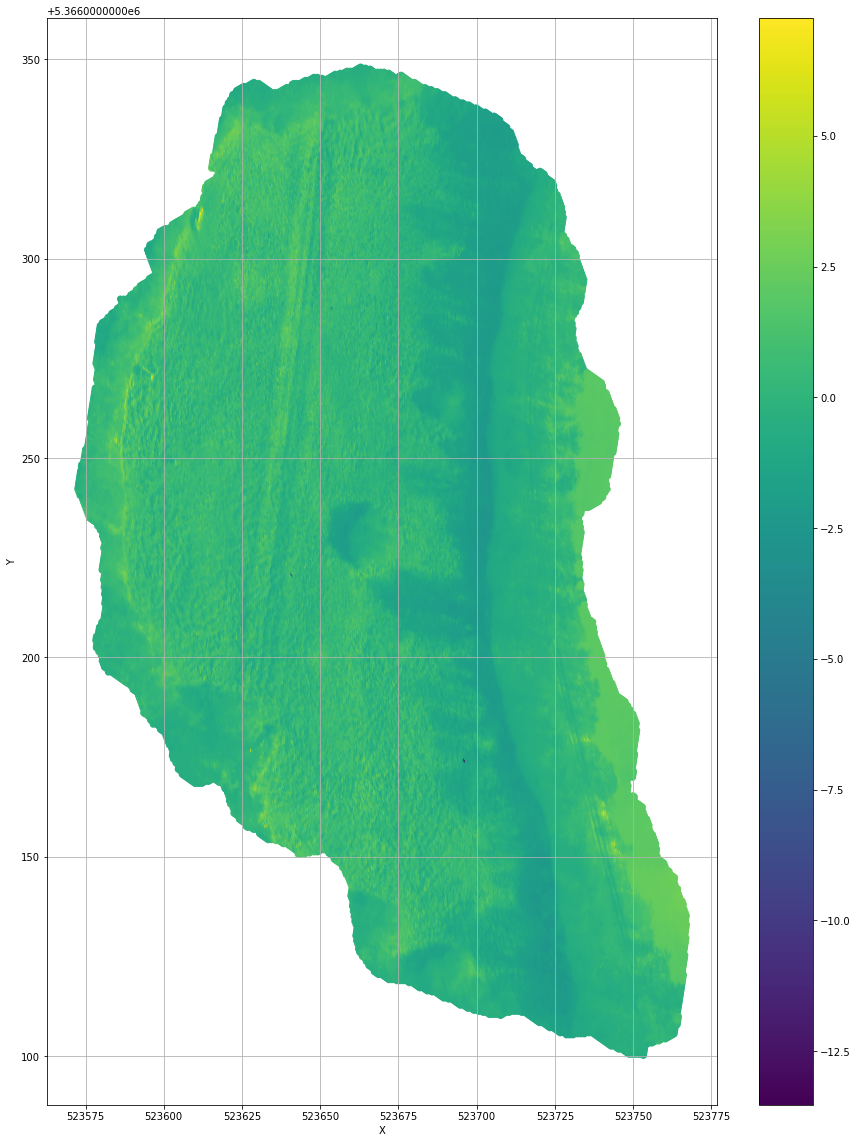

In [16]:
# On check les matrices crées, prend du temps à zaper si on s'en fout
ech = 1
fig,ax=plt.subplots(1,1, figsize = (15,20))
img0 = ax.scatter(X[::ech],Y[::ech],c = Z[::ech])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
fig.colorbar(img0, ax=ax)

## Calcul du Variogram 

In [ ]:
direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 191889
Iteration 10000 / 191889
Iteration 20000 / 191889
<NULL> 30000 <NULL> 191889
<NULL> 40000 <NULL> 191889
<NULL> 50000 <NULL> 191889


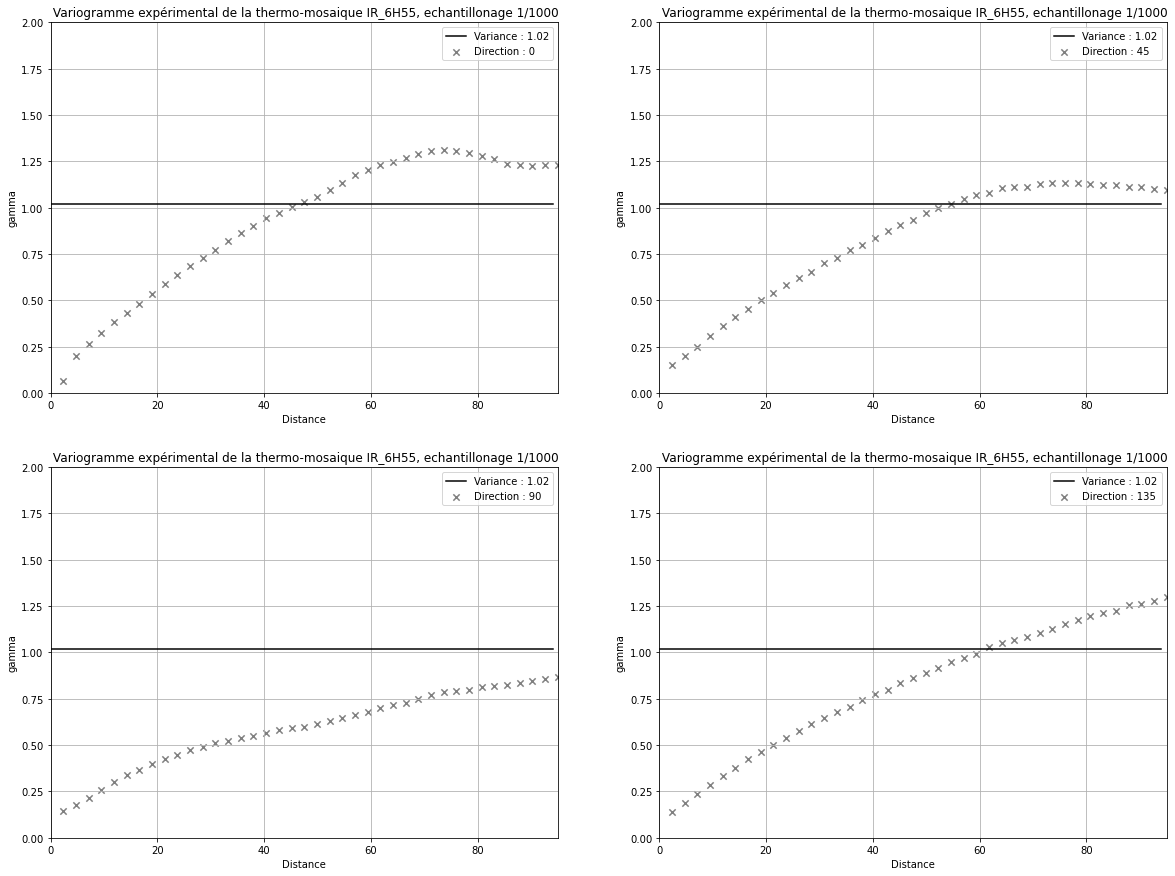

In [192]:
ones = np.ones(shape=(int(L))) * varr_z
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(varr_z))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    ax[ii,jj].set_title(" Variogramme expérimental de la thermo-mosaique "+str(requested_IR)+", echantillonage " + str(echantillonage) )
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

## Save

In [296]:
for direction in dist :
    if direction == 45 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 135 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2 = pd.DataFrame()
varc_2["Lag Distance"] = dist_array
varc_2["Number of Pairs"] = count_array
varc_2["Variogram Value"] = gam_array
varc_2["Variogram Index"] = index_array 

In [297]:
varc_2

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
0          2.375           7934.0         0.152326              1.0
1          4.750          23135.0         0.201084              1.0
2          7.125          38448.0         0.249080              1.0
3          9.500          51700.0         0.310359              1.0
4         11.875          65821.0         0.360253              1.0
..           ...              ...              ...              ...
75        85.500         263482.0         1.226205              2.0
76        87.875         262789.0         1.253657              2.0
77        90.250         259823.0         1.263180              2.0
78        92.625         260399.0         1.276504              2.0
79        95.000         258029.0         1.298519              2.0

[80 rows x 4 columns]

In [298]:
low_secondary = pd.DataFrame(np.array([X,Y,Z]).T,columns = [["X","Y","Secondary"]])
low_secondary.to_csv('./varr/low_secondary.csv',index=False)
header = ["Lag Distance","Number of Pairs","Variogram Value","Variogram Index"]
varc_2.to_csv('./varr/varc_2.csv',index=False,header = header)

# Utilisation d'un espace réduit autour des sondes (convex)

In [1]:
Condition = True 
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_df = reading_gps_file(filename_Sensor_txt)
Sensor_df.loc[Sensor_df["SensorName"] != "S3-AIR"]

if Condition :
    echantillonage = 10
    filetif = ['6H55', '7H29', '8H22', '9H28', '10H22', '11H27', '12H31', '13H26', '15H59', '17H27']
    ls_path_tif,filetif = get_tif(filetif)
    dict_IR_convex_space = reading_IR_only_sensor(filetif,ls_path_tif,Sensor_df,echantillonage)
    np.save("dict_IR_convex_space_ech10.npy",dict_IR_convex_space)

NameError: name 'reading_gps_file' is not defined

### Choix d'une IR

In [9]:
dict_IR_convex_space = np.load("dict_IR_convex_space.npy",allow_pickle='TRUE').item()
dict_IR_convex_space.keys()

dict_IR_convex_space = np.load("dict_IR_convex_space_ech10.npy",allow_pickle='TRUE').item()
dict_IR_convex_space.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [10]:
dict_IR_convex_space["IR_9H28"]["Secondary"].to_csv("9h28_to_surfer.csv")

In [11]:
requested_IR = ["IR_9H28"]

filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_df = reading_gps_file(filename_Sensor_txt)
Sensor_df.loc[Sensor_df["SensorName"] != "S3-AIR"]

for IR in requested_IR :
    Secondary_convex = dict_IR_convex_space[IR]["Secondary"]
    echantillonage_convex = dict_IR_convex_space[IR]["echantillonage"]

In [12]:
X = Secondary_convex["X"].astype(float).values
Y = Secondary_convex["Y"].astype(float).values
Z = Secondary_convex["Secondary"].astype(float).values

In [13]:
Secondary_convex

X             Y    band 1  Secondary
0       523628.710  5.366174e+06  7.034997  -0.104540
1       523628.710  5.366175e+06  7.159491  -0.013046
2       523628.710  5.366175e+06  7.542570   0.268489
3       523628.710  5.366176e+06  7.740776   0.414155
4       523628.710  5.366177e+06  7.329526   0.111917
...            ...           ...       ...        ...
317332  523696.655  5.366295e+06  4.240493  -2.158290
317333  523696.655  5.366295e+06  4.327398  -2.094422
317334  523696.655  5.366296e+06  4.453441  -2.001790
317335  523696.655  5.366296e+06  4.334847  -2.088947
317336  523696.655  5.366297e+06  4.456080  -1.999850

[317337 rows x 4 columns]

In [14]:
X.shape

(317337,)

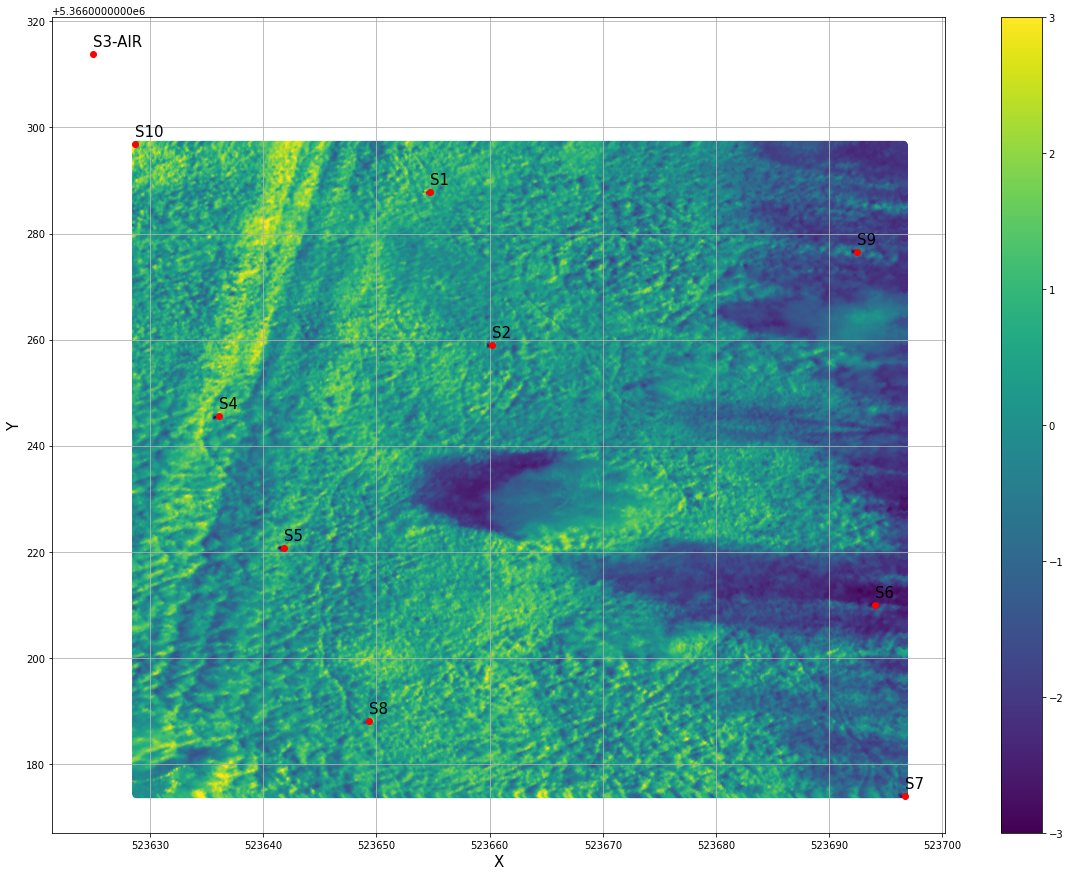

In [15]:
condition = True
if condition :
    # On check les matrices crées, prend du temps à zaper si on s'en fout
    ech = 1
    fig,ax=plt.subplots(1,1, figsize = (20,15))
    img0 = ax.scatter(X[::ech],Y[::ech],c = Z[::ech],vmin = -3, vmax = 3)
    ax.set_xlabel('X', size = 15)
    ax.set_ylabel('Y', size = 15)
    ax.grid()
    fig.colorbar(img0, ax=ax)

    Target_x = np.array(Sensor_df["x"],dtype = float)
    Target_y = np.array(Sensor_df["y"],dtype = float)
    Sensor_Name = np.array(Sensor_df["SensorName"],dtype = str)

    plt.plot(Target_x,Target_y,"ro")
    for k in range(len(Target_x)) :
        plt.text(Target_x[k],Target_y[k]+1.5,Sensor_Name[k], size = 15)


In [16]:
L=(max(X)-min(X))*2/3 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 1.0 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 523696.655  	 Distance maximale retenue : 45.29666666667132
nlag : 45


## Calcul du Variogram 

In [17]:
direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 317337
Iteration 10000 / 317337
Iteration 20000 / 317337
Iteration 30000 / 317337
Iteration 40000 / 317337
Iteration 50000 / 317337
Iteration 60000 / 317337
Iteration 70000 / 317337
Iteration 80000 / 317337
Iteration 90000 / 317337
Iteration 100000 / 317337
Iteration 110000 / 317337
Iteration 120000 / 317337
Iteration 130000 / 317337
Iteration 140000 / 317337
Iteration 150000 / 317337
Iteration 160000 / 317337
Iteration 170000 / 317337
Iteration 180000 / 317337
Iteration 190000 / 317337
Iteration 200000 / 317337
Iteration 210000 / 317337
Iteration 220000 / 317337
Iteration 230000 / 317337
Iteration 240000 / 317337
Iteration 250000 / 317337
Iteration 260000 / 317337
Iteration 270000 / 317337
Iteration 280000 / 317337
Iteration 290000 / 317337
Iteration 300000 / 317337
Iteration 310000 / 317337
direction done : 0
RUN TIME : 1535.9128139999957
Iteration 0 / 317337
Iteration 10000 / 317337
Iteration 20000 / 317337
Iteration 30000 / 317337
Iteration 40000 / 317337
Iteration 50

In [19]:
gam[Dir].shape

(45,)

## Save

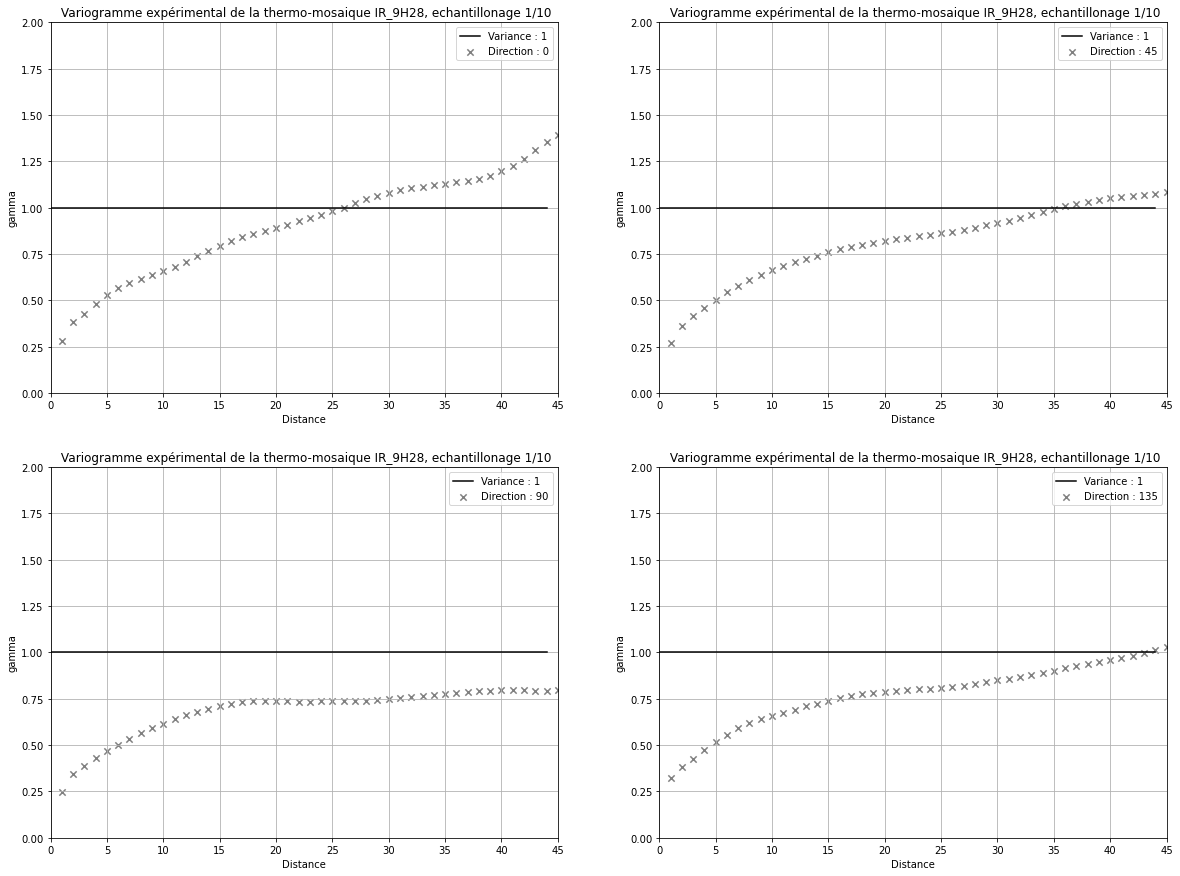

In [20]:
ones = np.ones(shape=(int(L))) * 1
H    = np.arange(0,int(L))
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].plot(H,ones,"black", label = "Variance : " + str(1))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    ax[ii,jj].set_ylim([0,2])
    ax[ii,jj].set_xlim([0,max(dist_dir)])
    ax[ii,jj].set_title(" Variogramme expérimental de la thermo-mosaique "+str(requested_IR[0])+", echantillonage 1/" + str(echantillonage_convex) )
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [21]:
for direction in dist :
    if direction == 45 :
        index_major = np.ones((1,len(dist[direction])))
        dist_major  = dist[direction]
        gam_major   = gam[direction]
        count_major = counts[direction]
    elif direction == 135 :
        index_minor = np.ones((1,len(dist[direction]))) * 2
        dist_minor  = dist[direction]
        gam_minor   = gam[direction]
        count_minor = counts[direction]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_2_convex = pd.DataFrame()
varc_2_convex["Lag Distance"] = dist_array
varc_2_convex["Number of Pairs"] = count_array
varc_2_convex["Variogram Value"] = gam_array
varc_2_convex["Variogram Index"] = index_array 

In [22]:
varc_2_convex

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
0            1.0        4394965.0         0.267947              1.0
1            2.0       14239973.0         0.362020              1.0
2            3.0       22551592.0         0.415167              1.0
3            4.0       31795502.0         0.459532              1.0
4            5.0       38363470.0         0.504418              1.0
..           ...              ...              ...              ...
85          41.0      172441604.0         0.972503              2.0
86          42.0      172879362.0         0.983623              2.0
87          43.0      171729558.0         0.997237              2.0
88          44.0      171920803.0         1.011524              2.0
89          45.0      171581854.0         1.030889              2.0

[90 rows x 4 columns]

In [322]:
condition = False
if condition :
    low_secondary.to_csv('./varr/low_secondary.csv',index=False)
    header = ["Lag Distance","Number of Pairs","Variogram Value","Variogram Index"]
    varc_2_convex.to_csv('./varr/varc_2_convex.csv',index=False,header = header )

In [116]:
Secondary_variogram = {"DataFrame": Secondary_convex ,
                     "Variogram" : varc_2_convex,
                     "enchantillonage" : echantillonage_convex ,
                     "IR_time" :requested_IR[0]}

filename = "./varr/Secondary_variogram/"+str(requested_IR[0])+"_"+str(TEMP)+"_convex.npy"
np.save(filename,Secondary_variogram)

In [24]:
varc_2_convex = pd.DataFrame()
varc_2_convex["Lag Distance"] = dist_array
varc_2_convex["Number of Pairs"] = count_array
varc_2_convex["Variogram Value"] = gam_array
varc_2_convex["Variogram Index"] = index_array 

Secondary_variogram = {"DataFrame": Secondary_convex ,
                 "Variogram" : varc_2_convex,
                 "enchantillonage" : echantillonage_convex ,
                 "IR_time" : requested_IR[0]}

filename = "./varr/Secondary_variogram/Boucle/"+str(requested_IR[0])+"_ech10_convex.npy"
np.save(filename,Secondary_variogram)
print("Complited :",IR)

Complited : IR_9H28


In [23]:
IR

'IR_9H28'

## Boucle

In [95]:
dict_IR_convex_space.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [100]:
dict_IR_convex_space = np.load("dict_IR_convex_space.npy",allow_pickle='TRUE').item()
for IR in dict_IR_convex_space :
    Secondary_convex = dict_IR_convex_space[IR]["Secondary"]
    echantillonage_convex = dict_IR_convex_space[IR]["echantillonage"]

    X = Secondary_convex["X"].astype(float).values
    Y = Secondary_convex["Y"].astype(float).values
    Z = Secondary_convex["Secondary"].astype(float).values
    varr_z = 1

    L=(max(X)-min(X))*2/3 # distance maximale
    print("max x :", max(X), " \t Distance maximale retenue :",L)
    w = 1.0 # width, taille des lags
    print("nlag :" , np.int(np.fix(L/w)))

    direction = [0,45,90,135]
    angle_tolerance = 22.5
    dist, counts, gam = {}, {}, {}

    for Dir in direction :
        st1 = timeit.default_timer()
        dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir)
        print("direction done :", Dir)
        st2 = timeit.default_timer()
        print("RUN TIME : {0}".format(st2-st1))

    for direction in dist :
        if direction == 45 :
            index_major = np.ones((1,len(dist[direction])))
            dist_major  = dist[direction]
            gam_major   = gam[direction]
            count_major = counts[direction]
        elif direction == 135 :
            index_minor = np.ones((1,len(dist[direction]))) * 2
            dist_minor  = dist[direction]
            gam_minor   = gam[direction]
            count_minor = counts[direction]

    index_array = np.append(index_major,index_minor)
    dist_array  = np.append(dist_major,dist_minor)
    gam_array   = np.append(gam_major,gam_minor)
    count_array   = np.append(count_major,count_minor)

    varc_2_convex = pd.DataFrame()
    varc_2_convex["Lag Distance"] = dist_array
    varc_2_convex["Number of Pairs"] = count_array
    varc_2_convex["Variogram Value"] = gam_array
    varc_2_convex["Variogram Index"] = index_array 
    
    Secondary_variogram = {"DataFrame": Secondary_convex ,
                     "Variogram" : varc_2_convex,
                     "enchantillonage" : echantillonage_convex ,
                     "IR_time" : IR}
    
    filename = "./varr/Secondary_variogram/Boucle/"+str(IR)+"_convex.npy"
    np.save(filename,Secondary_variogram)
    print("Complited :",IR)

max x : 523696.655  	 Distance maximale retenue : 45.29666666667132
nlag : 45
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 0
RUN TIME : 14.258189000014681
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 45
RUN TIME : 14.510142499988433
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 90
RUN TIME : 14.203027199982898
Iteration 0 / 29801
Iteration 10000 / 29801
Iteration 20000 / 29801
direction done : 135
RUN TIME : 14.680984700011322
Complited : IR_6H55
max x : 523696.655  	 Distance maximale retenue : 45.29666666667132
nlag : 45
Iteration 0 / 33183
Iteration 10000 / 33183
Iteration 20000 / 33183
Iteration 30000 / 33183
direction done : 0
RUN TIME : 17.647905599995283
Iteration 0 / 33183
Iteration 10000 / 33183
Iteration 20000 / 33183
Iteration 30000 / 33183
direction done : 45
RUN TIME : 17.965282999997726
Iteration 0 / 33183
Iteration 10000 / 33183
Iteration 20000 / 33183
I

## Importation des données de Température (Z)

#### Importation de l'heure de vole du drone (Requested_IR)

In [168]:
requested_IR = ["IR_10H22"]
print("IR sélectionnée :",requested_IR[0])

IR sélectionnée : IR_10H22


In [170]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
IR_time = dict_PT_all_temp[requested_IR[0]]['IR_time']
TEMP = 'T1'
dict_PT_all_temp.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [171]:
print("IR sélectionnée :",requested_IR[0])
print("sensor sélectionné :",TEMP)

IR sélectionnée : IR_10H22
sensor sélectionné : T1


In [183]:
IR_time

Timestamp('2019-04-14 10:30:00')

In [184]:
date_1='2019-04-14 06:00:00'
date_2='2019-04-14 18:30:00'
dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Primary = reading_gps_file(filename_Sensor_txt)
Primary[TEMP] = 0
for sensor in dict_temp_sensor :
    value = dict_temp_sensor[sensor][TEMP].loc[dict_temp_sensor[sensor]["Time"] == IR_time]
    Primary[TEMP].loc[Primary["SensorName"] == sensor] = value.values

Primary = Primary.loc[Primary["SensorName"] != "S3-AIR"]
Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score

C:\Users\Alexandre\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Mise en place de la variable Primaire : **Primary**

In [173]:
Primary

SensorName           x            y      T1   Primary
0        S10   523628.71   5366296.81  10.998 -0.058948
1         S1   523654.74   5366287.75  10.498 -0.240997
2         S9   523692.47   5366276.57  10.363 -0.290150
3         S2   523660.22   5366258.91   9.624 -0.559220
4         S4  523636.075  5366245.545  10.850 -0.112834
5         S5  523641.825   5366220.67   9.895 -0.460549
6         S8   523649.33   5366188.02  10.122 -0.377898
7         S7  523696.655    5366174.0  10.576 -0.212597
8         S6   523694.05   5366209.93   9.403 -0.639685

In [186]:
varr = np.var(Primary["Primary"].values)
varr = float("{:.2f}".format(varr))
print("Variance :",varr)

Variance : 1.0


In [187]:
# On utilise les valeurs transformées
X = Primary["x"].astype(float).values
Y = Primary["y"].astype(float).values
Z = Primary["Primary"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 9
Y : 9
Z : 9


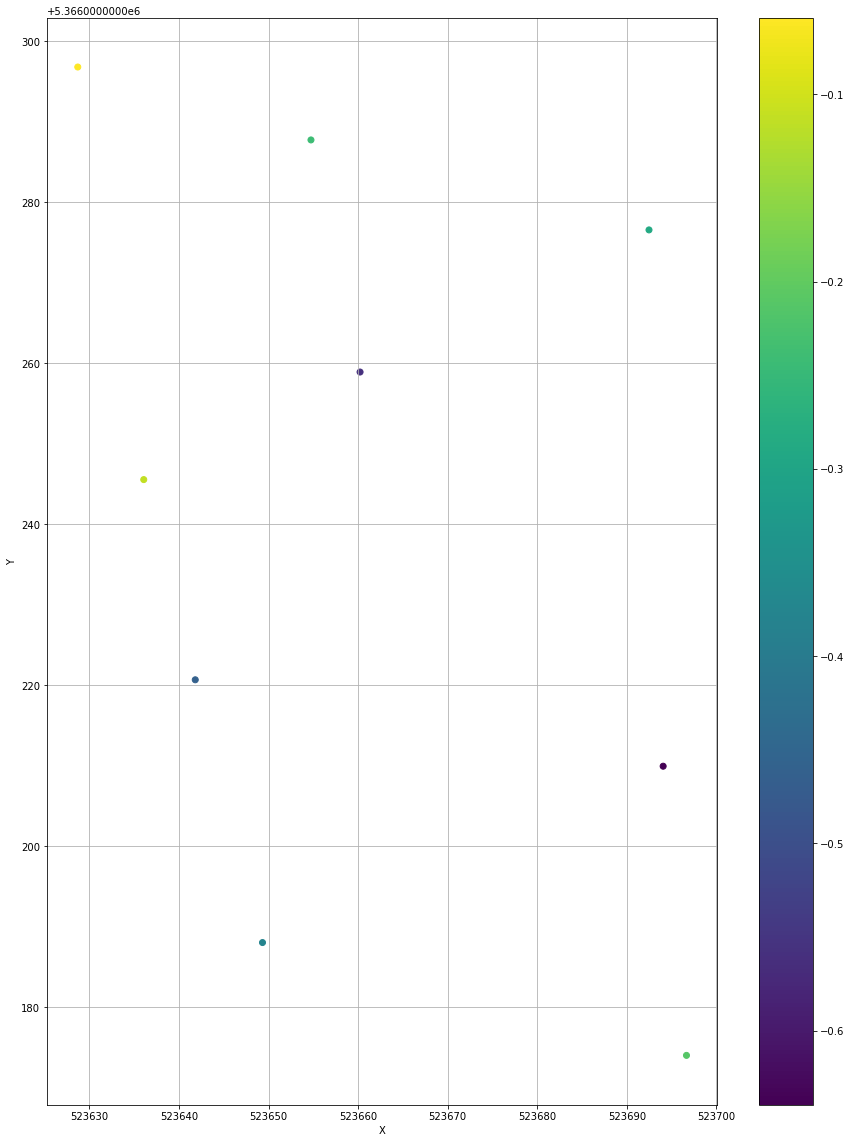

In [176]:
Condition = False
if Condition :
    # On check les matrices crées, prend du temps à zaper si on s'en fout
    fig,ax=plt.subplots(1,1, figsize = (15,20))
    img0 = ax.scatter(X,Y,c = Z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    fig.colorbar(img0, ax=ax)

##### Estiamtion de la distance maximale à retenir

In [188]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 140.35248171977688


In [189]:
L = distance_variable * 2/3
print("Distance maximale retenue :",L)
#w = 15.0 # width, taille des lags
w =15
print("nlag :" , np.int(np.fix(L/w)))

Distance maximale retenue : 93.56832114651792
nlag : 6


In [190]:
direction = [0]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Iteration 0 / 9
direction done : 0
RUN TIME : 0.0005811000000903732


In [191]:
print("Valeurs du semi-variogramme :",gam[0])
print("Nombres de pairs :",counts[0])

Valeurs du semi-variogramme : [0.         1.22874764 0.06675582 0.94437036 1.85776048 2.31180463]
Nombres de pairs : [9. 3. 2. 7. 4. 2.]


In [718]:
Condition = False
if Condition :
    dist[0] = np.delete(dist[0],1)
    counts[0] = np.delete(counts[0],1)
    gam[0] = np.delete(gam[0],1)

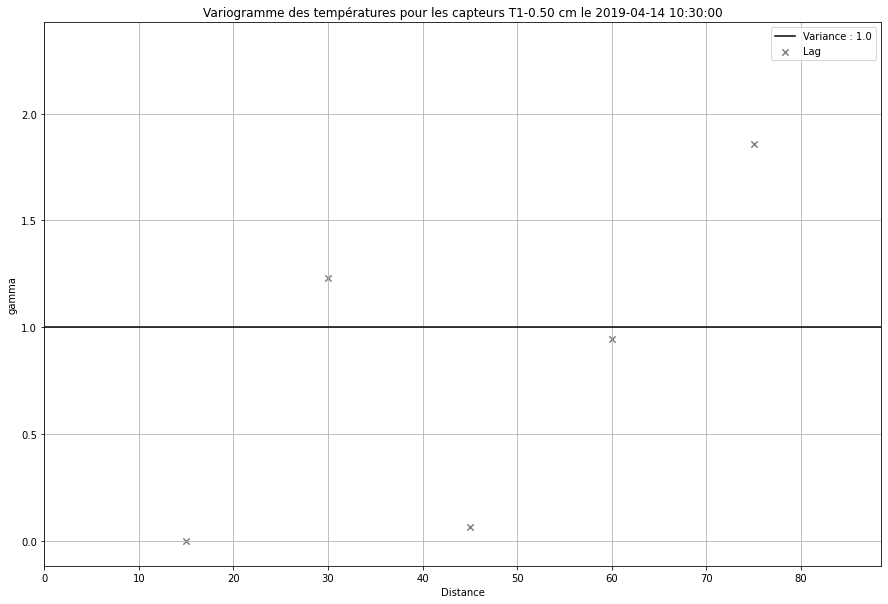

In [192]:
ones = np.ones(shape=(100)) * varr
H    = np.arange(0,100)
fig,ax=plt.subplots(1,1,figsize = (15,10))
LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
sensor = str(LABEL[int(TEMP[-1])-1])
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
    ax.plot(H,ones,"black",label = "Variance : " + str(varr))
    ax.set_xlabel('Distance')
    ax.set_ylabel('gamma')
    ax.grid()
    ax.legend()
    ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
    ax.set_xlim([0,88.5])


## Save

In [23]:
distonce = [1,2]

In [24]:
for direction in distonce :
    if direction == 1 :
        index_major = np.ones((1,len(dist[0])))
        dist_major  = dist[0]
        gam_major   = gam[0]
        count_major = counts[0]
    elif direction == 2 :
        index_minor = np.ones((1,len(dist[0]))) * 2
        dist_minor  = dist[0]
        gam_minor   = gam[0]
        count_minor = counts[0]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_1 = pd.DataFrame()
varc_1["Lag Distance"] = dist_array
varc_1["Number of Pairs"] = count_array
varc_1["Variogram Value"] = gam_array
varc_1["Variogram Index"] = index_array 

### Sauvegarde d'un package

In [31]:
condition = False
if condition :
    Primary.to_csv('./varr/Primary.csv',index=False)
    header = ["Lag Distance","Number of Pairs","Variogram Value","Variogram Index"]
    varc_1.to_csv('./varr/varc_1.csv',index=False,header = header)

In [79]:
Primary_variogram = {"DataFrame": Primary ,
                     "Variogram" : varc_1,
                     "sensor" : TEMP,
                     "IR_time" :requested_IR[0]}

In [80]:
filename = "./varr/Primary_variogram/"+str(requested_IR[0])+"_"+str(TEMP)+".npy"
np.save(filename,Primary_variogram)

## Boucle

In [54]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
for requested_IR in dict_PT_all_temp :
    for TEMP in ["T1","T2","T3","T4"] :
        IR_time = dict_PT_all_temp[requested_IR]['IR_time']
        # Données sondes
        date_1='2019-04-14 06:00:00'
        date_2='2019-04-14 18:30:00'
        dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
        filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
        Primary_c = reading_gps_file(filename_Sensor_txt)
        Primary_c[TEMP] = 0
        for sensor in dict_temp_sensor :
            value = dict_temp_sensor[sensor][TEMP].loc[dict_temp_sensor[sensor]["Time"] == IR_time]
            Primary_c[TEMP].loc[Primary_c["SensorName"] == sensor] = value.values

        Primary = Primary_c.loc[Primary_c["SensorName"] != "S3-AIR"] 
        Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score
        
        X = Primary["x"].astype(float).values
        Y = Primary["y"].astype(float).values
        Z = Primary["Primary"].astype(float).values
        
        ## Distance à retenir
        distance_variable = 0
        for i in range(0,len(X)) :
            for j in range (0,len(X)) :
                x = X[i] - X[j]
                y = Y[i] - Y[j]
                dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
                if dist_temp > distance_variable :
                    distance_variable = dist_temp
        
        ## Calcul du variogram
        L = distance_variable * 2/3
        w =15
        direction = [0]
        angle_tolerance = 90
        dist, counts, gam = {}, {}, {}

        for Dir in direction :
            st1 = timeit.default_timer()
            dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
            st2 = timeit.default_timer()
            print("RUN TIME : {0}".format(st2-st1))
        
        ## Save
        for direction in [1,2] :
            if direction == 1 :
                index_major = np.ones((1,len(dist[0])))
                dist_major  = dist[0]
                gam_major   = gam[0]
                count_major = counts[0]
            elif direction == 2 :
                index_minor = np.ones((1,len(dist[0]))) * 2
                dist_minor  = dist[0]
                gam_minor   = gam[0]
                count_minor = counts[0]

        index_array = np.append(index_major,index_minor)
        dist_array  = np.append(dist_major,dist_minor)
        gam_array   = np.append(gam_major,gam_minor)
        count_array   = np.append(count_major,count_minor)

        varc_1 = pd.DataFrame()
        varc_1["Lag Distance"] = dist_array
        varc_1["Number of Pairs"] = count_array
        varc_1["Variogram Value"] = gam_array
        varc_1["Variogram Index"] = index_array 
            
        Primary_variogram = {"DataFrame": Primary ,
                     "Variogram" : varc_1,
                     "sensor" : TEMP,
                     "IR_time" :requested_IR}
        
        filename = "./varr/Primary_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
        np.save(filename,Primary_variogram)
    print("Complited :",requested_IR)
        

C:\Users\Alexandre\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-54-f14018c3f86b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score


Iteration 0 / 9
RUN TIME : 0.00034829997457563877
Iteration 0 / 9
RUN TIME : 0.00028420001035556197
Iteration 0 / 9
RUN TIME : 0.0010100000072270632
Iteration 0 / 9
RUN TIME : 0.0003648999845609069
Complited : IR_6H55
Iteration 0 / 9
RUN TIME : 0.0008491000044159591
Iteration 0 / 9
RUN TIME : 0.00017189999925903976
Iteration 0 / 9
RUN TIME : 0.0001871999993454665
Iteration 0 / 9
RUN TIME : 0.00017070001922547817
Complited : IR_7H29
Iteration 0 / 9
RUN TIME : 0.0002605999761726707
Iteration 0 / 9
RUN TIME : 0.00032950000604614615
Iteration 0 / 9
RUN TIME : 0.00018499998259358108
Iteration 0 / 9
RUN TIME : 0.00022960000205785036
Complited : IR_8H22
Iteration 0 / 9
RUN TIME : 0.00028589999419637024
Iteration 0 / 9
RUN TIME : 0.00024210000992752612
Iteration 0 / 9
RUN TIME : 0.00017970000044442713
Iteration 0 / 9
RUN TIME : 0.00016510000568814576
Complited : IR_9H28
Iteration 0 / 9
RUN TIME : 0.0001700000138953328
Iteration 0 / 9
RUN TIME : 0.00017010001465678215
Iteration 0 / 9
RUN TIME :

In [55]:
dict_PT_all_temp.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [63]:
REQUESTED_IR = "IR_7H29"
TEMP = "T2"
varr = 1

[0.         1.22695552 0.09508573 0.94046728 1.87719811 2.30827486]
[0.         0.72468019 1.8792194  1.46104271 1.01014959 1.44272061]
[0.         1.6884071  0.70428339 0.66700086 1.71268346 2.91578946]
[0.         2.71399118 0.7153406  0.78661665 0.87517767 1.92542864]
[0.         1.22608362 0.09137765 0.94104309 1.87463883 2.30860396]
[0.         0.72742449 1.89124445 1.45929119 1.00719284 1.4442718 ]
[0.         1.72412817 0.74378006 0.66128515 1.69877887 2.95671677]
[0.         2.71986832 0.64317111 0.79288642 0.87040157 1.89522644]
[0.         1.22721952 0.08309088 0.94172496 1.8711048  2.30906662]
[0.         0.73670228 1.92163407 1.45448553 0.99862916 1.44911488]
[0.         1.78969548 0.81428572 0.65368355 1.66681529 3.02994011]
[0.         2.56003724 0.37750101 0.55034706 1.21805607 1.88426822]
[0.         1.22825997 0.07532414 0.94225455 1.86636799 2.31125158]
[0.         0.74600264 1.95595625 1.45045229 0.9879771  1.45585633]
[0.         1.84141235 0.86687724 0.65096938 1.6

<ipython-input-65-334c5f6e53a2>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1,figsize = (15,10))


[0.         0.79283267 0.86491259 1.48847723 1.46830853 2.70938831]
[0.         1.22948378 0.05061266 0.949815   1.83764252 2.31762785]
[0.         0.77789077 2.05778725 1.43756916 0.95447634 1.4813031 ]
[0.         1.82746928 0.72870507 0.70297103 1.59519005 3.19223943]
[0.         0.91339832 1.05705391 1.53575411 1.30818323 2.22484629]
[0.         1.22884495 0.04288974 0.95316156 1.82847841 2.31756978]
[0.         0.79124322 2.0857495  1.4315522  0.94657857 1.49525833]
[0.         1.72652227 0.57579018 0.74299186 1.61870182 3.13888679]
[0.         1.25460595 1.2074944  1.35334364 0.80556432 1.96782472]
[0.         1.23104359 0.03070207 0.96257673 1.79613546 2.32782654]
[0.         0.80991045 2.10948932 1.42734379 0.9356953  1.51853637]
[0.         1.3473255  0.19244684 0.88088033 1.67787065 2.77794312]
[0.         0.75529584 0.74986083 1.01990392 1.1718244  0.82229554]
[0.         1.23469213 0.02794397 0.9660794  1.7809698  2.3382933 ]
[0.         0.81217059 2.08728151 1.42910152 0.9

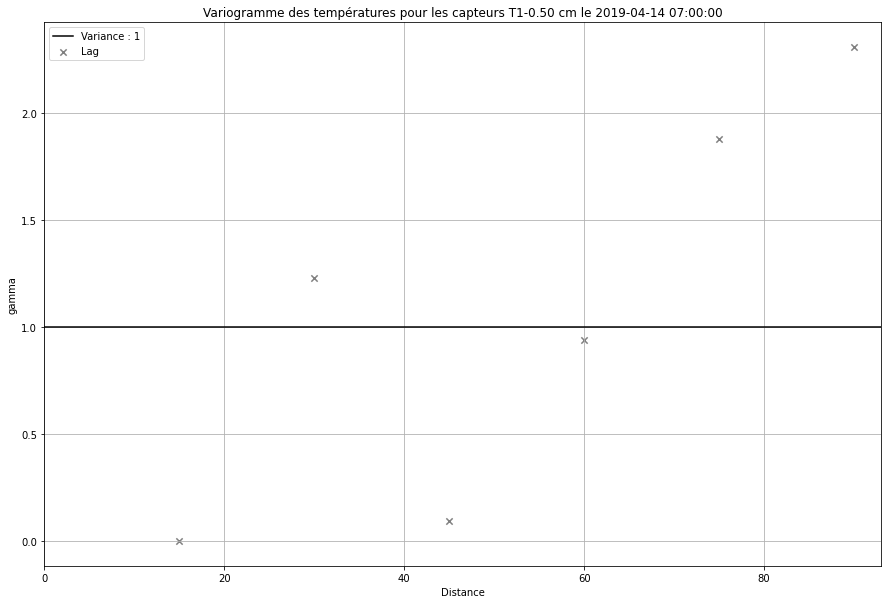

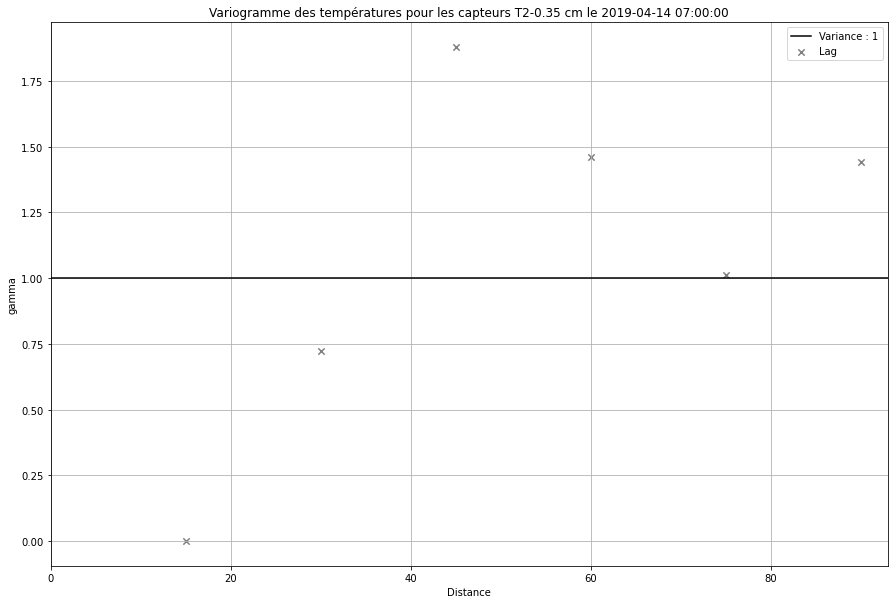

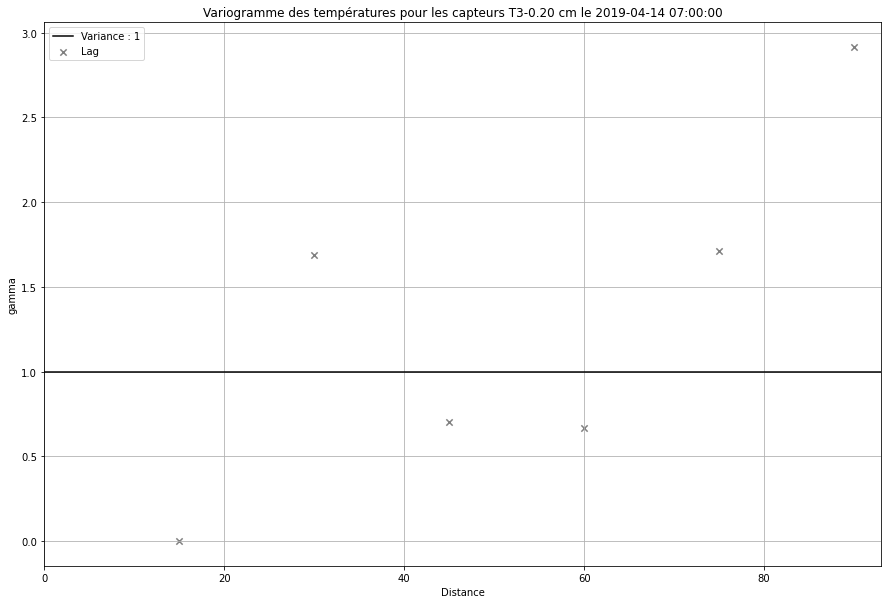

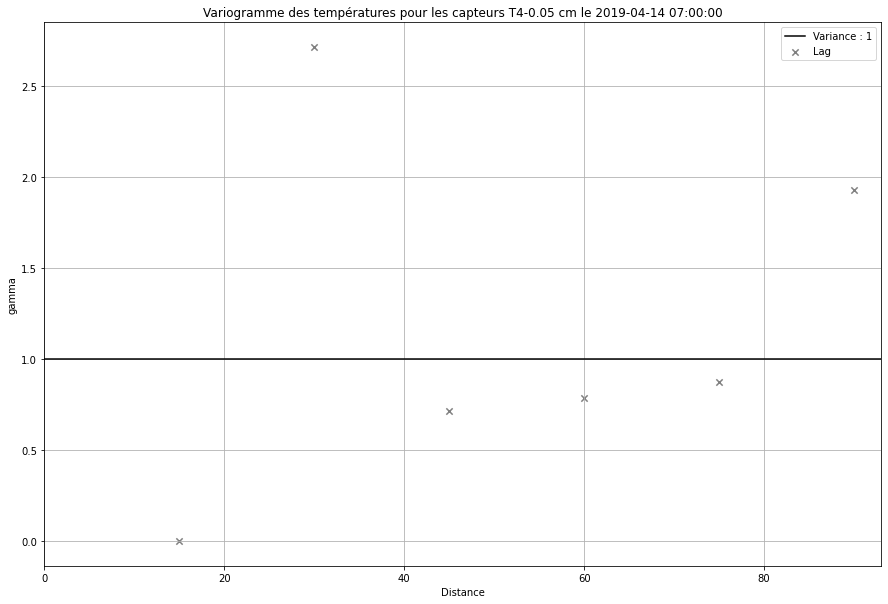

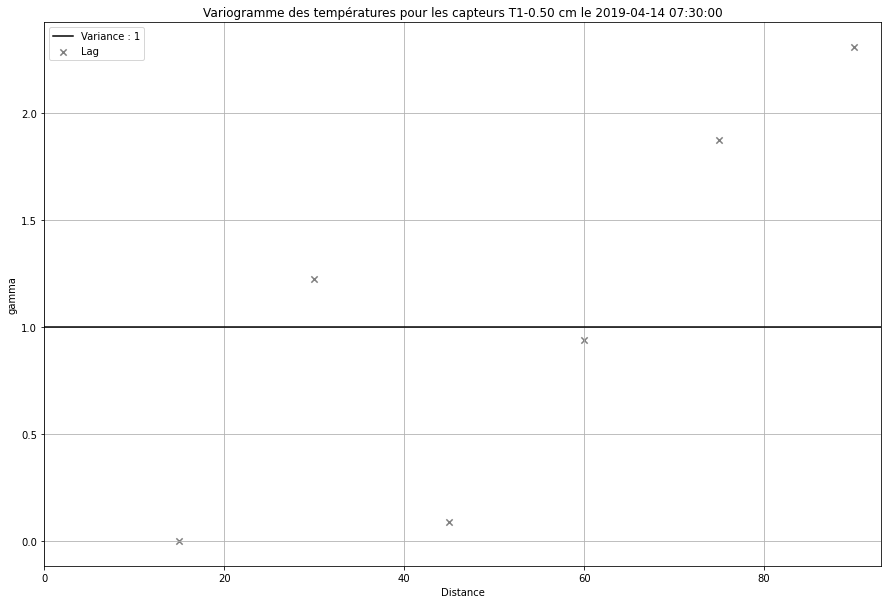

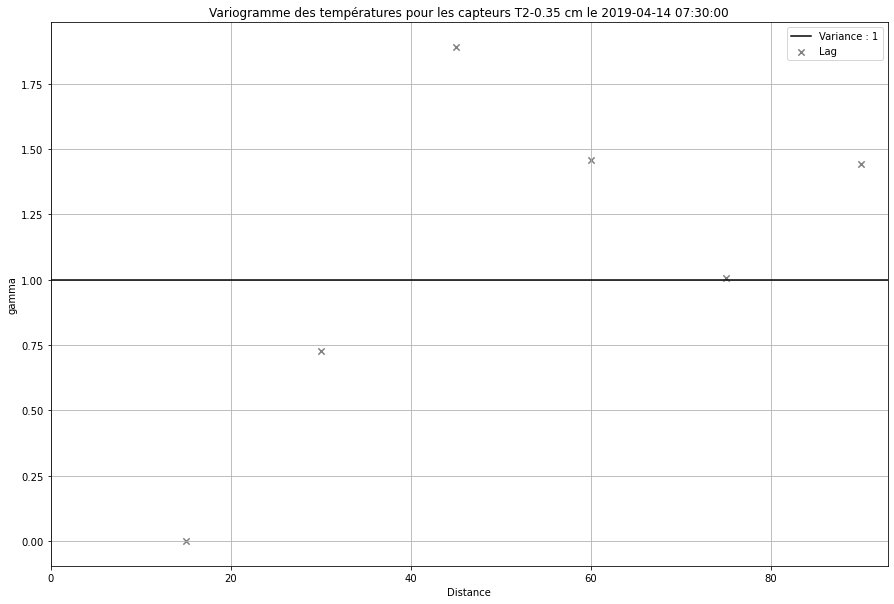

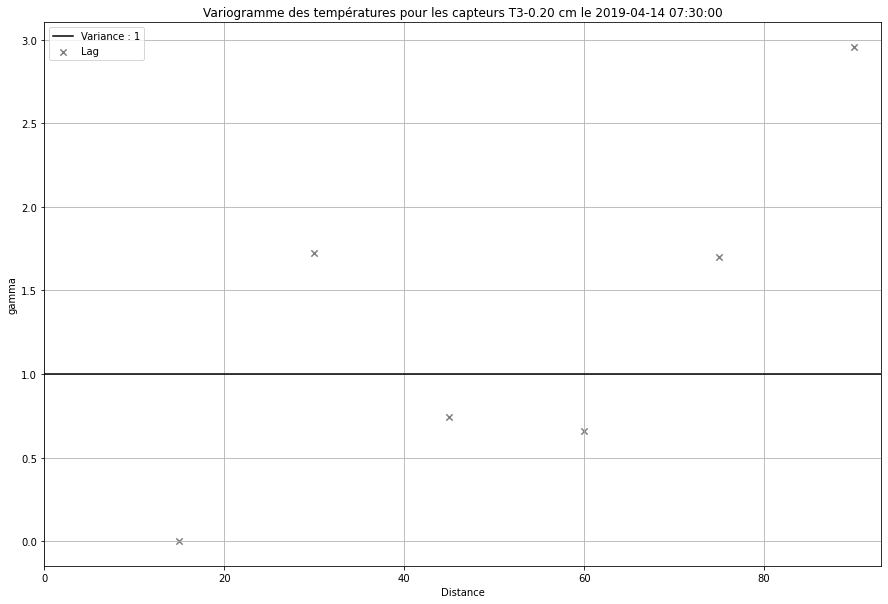

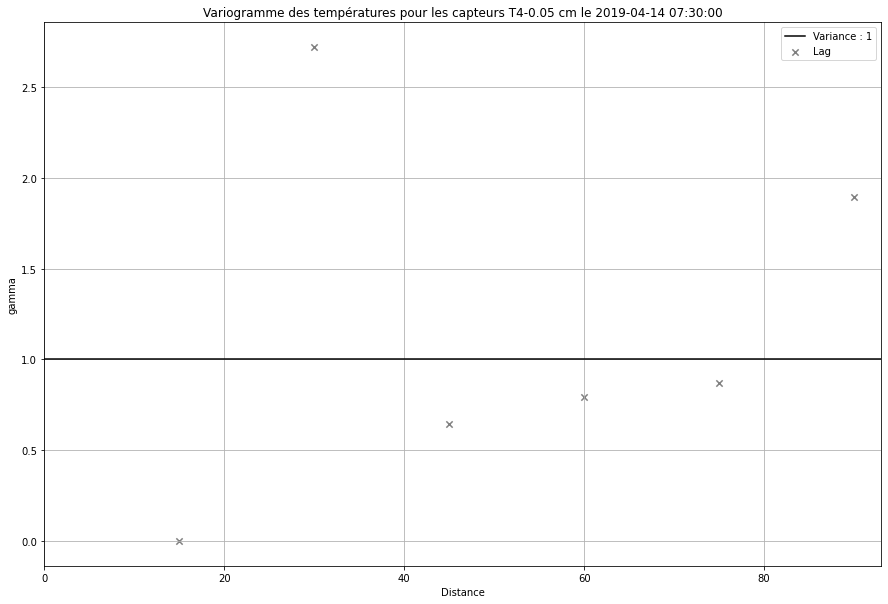

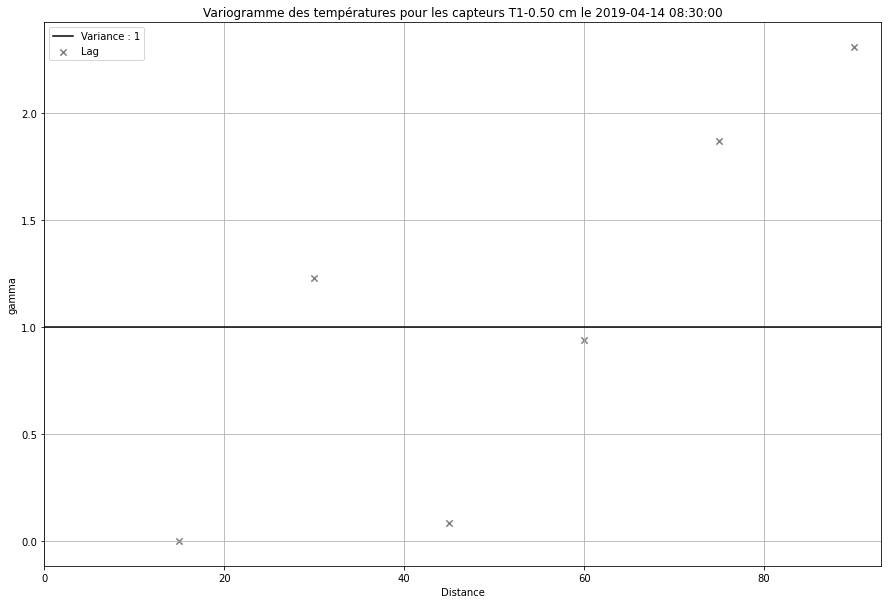

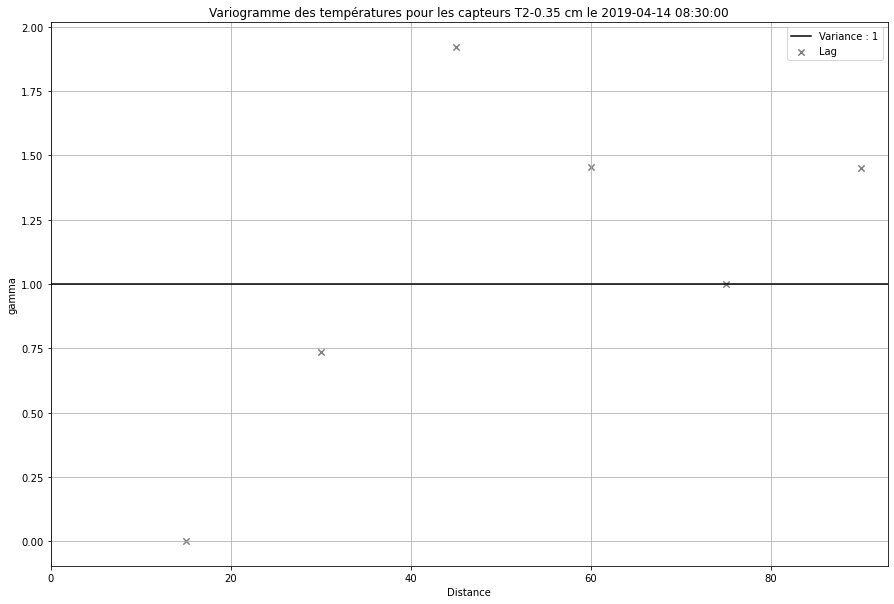

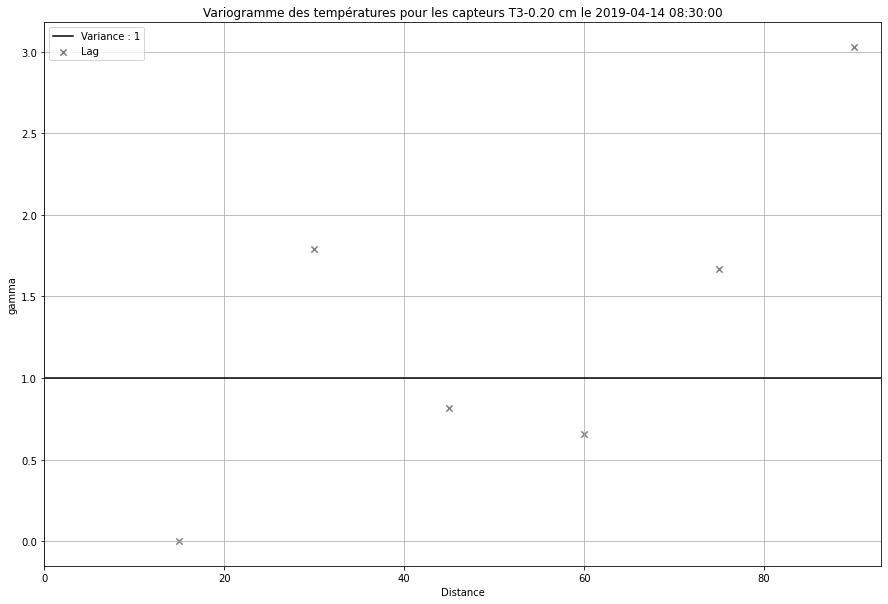

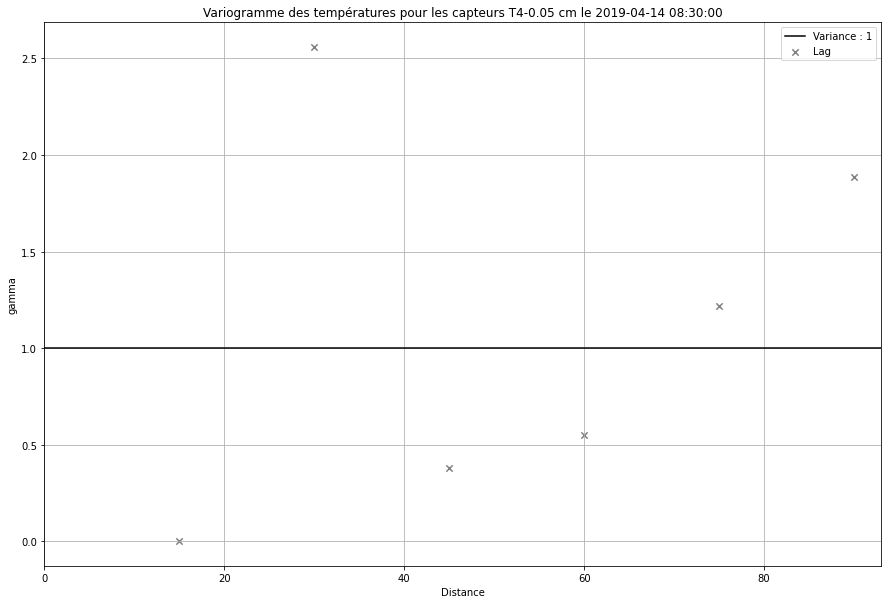

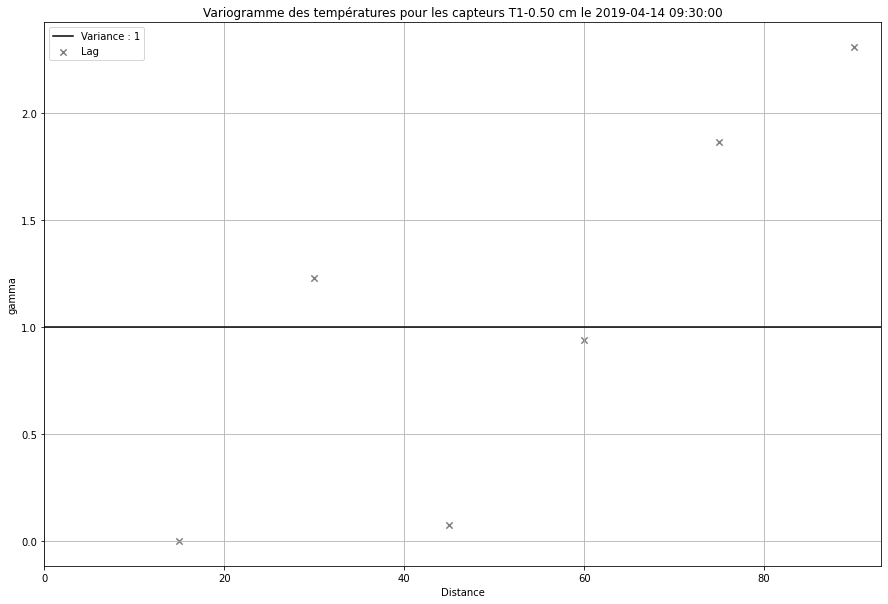

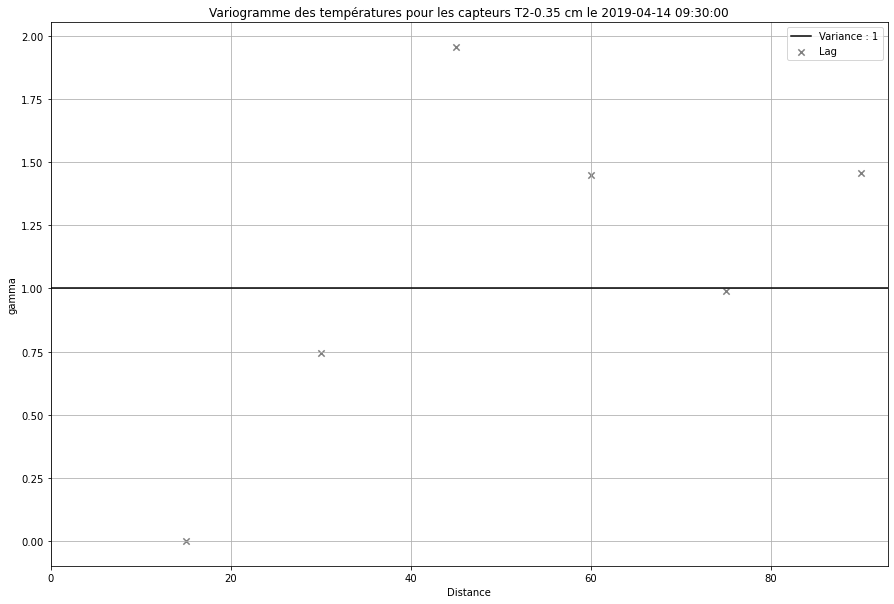

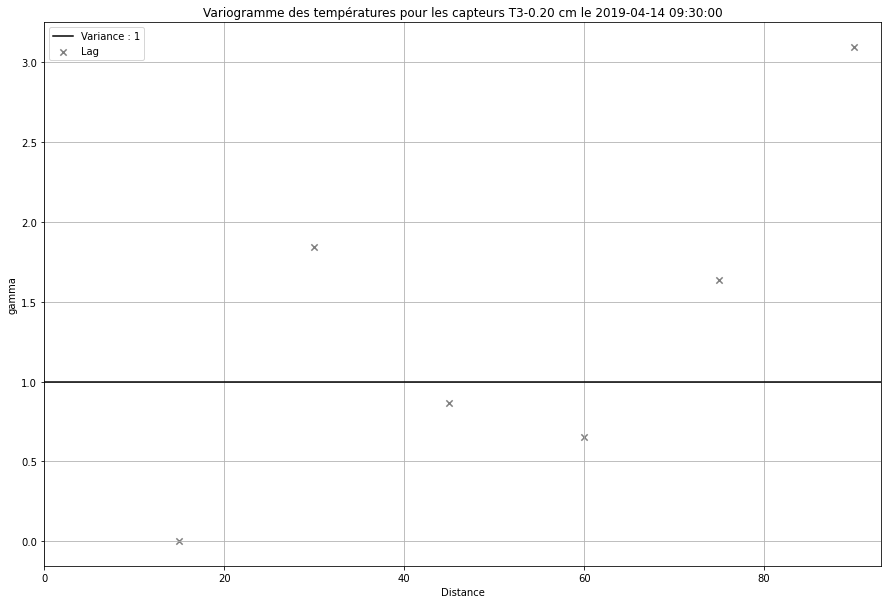

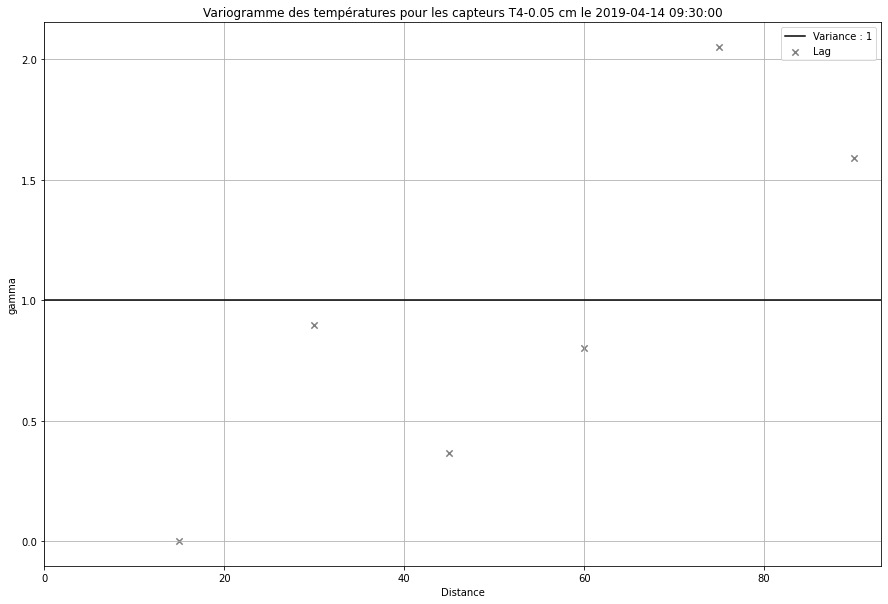

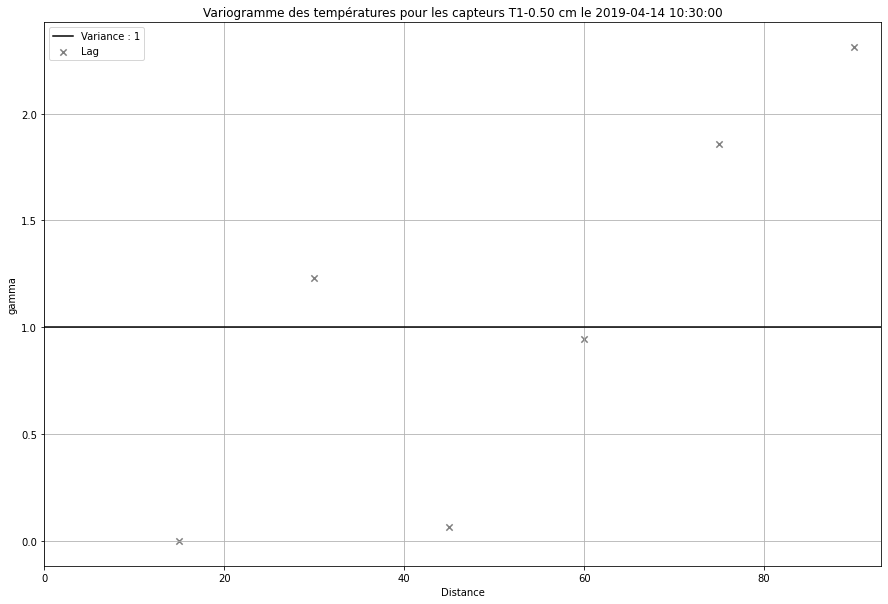

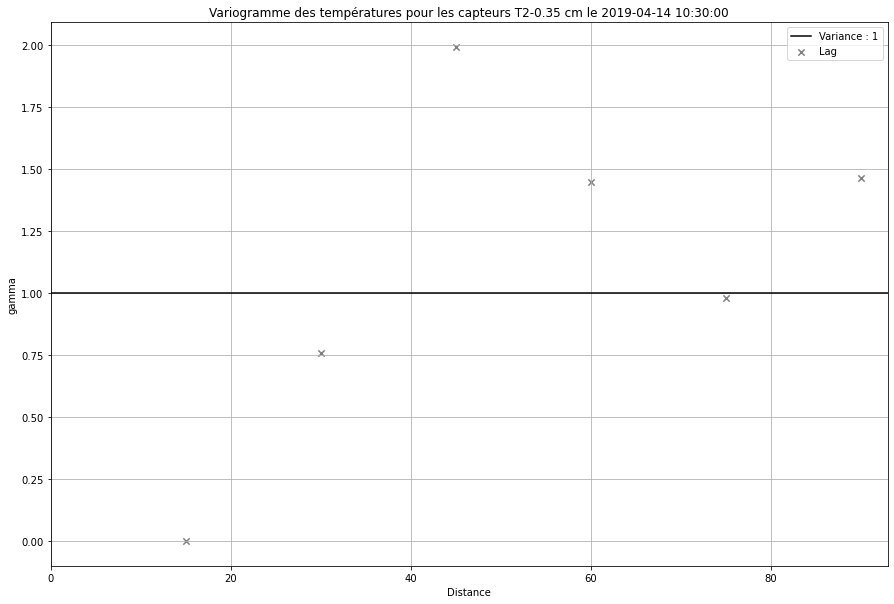

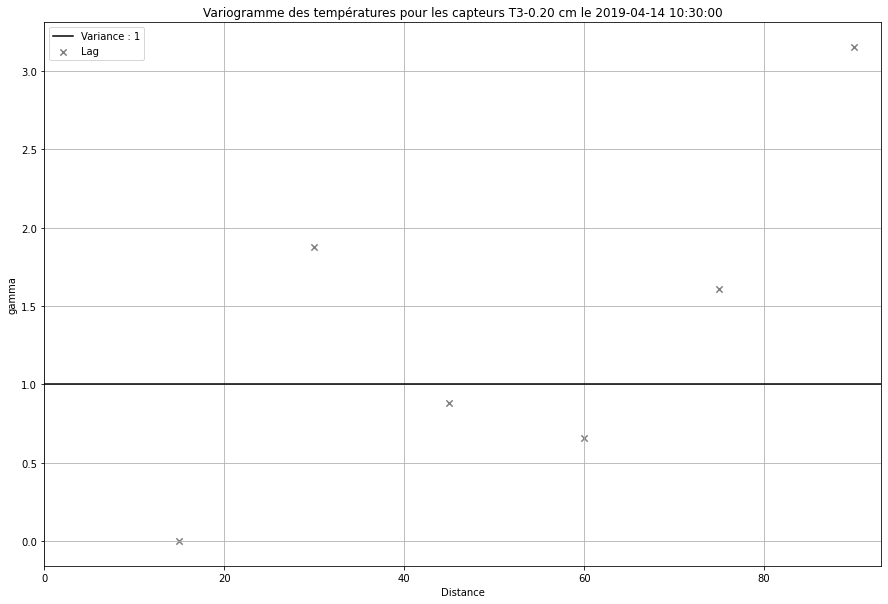

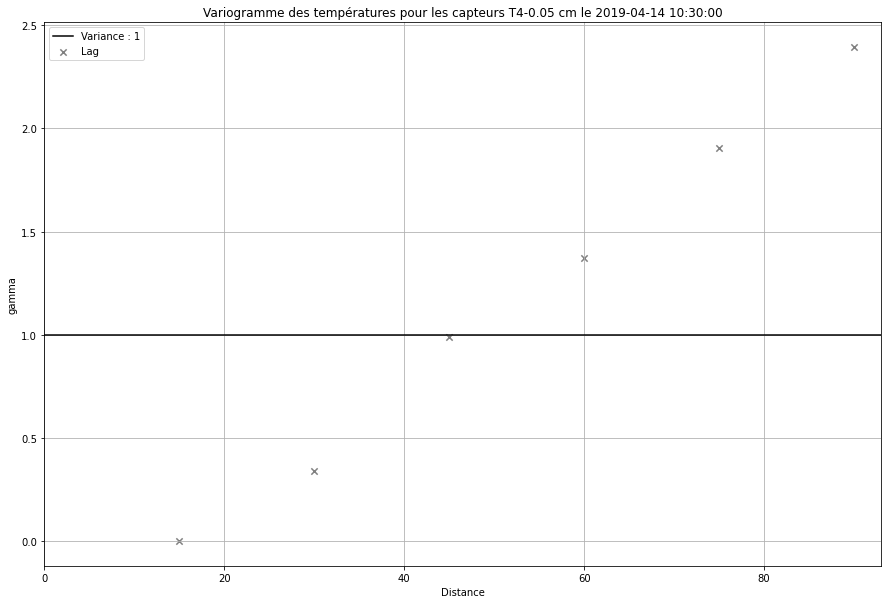

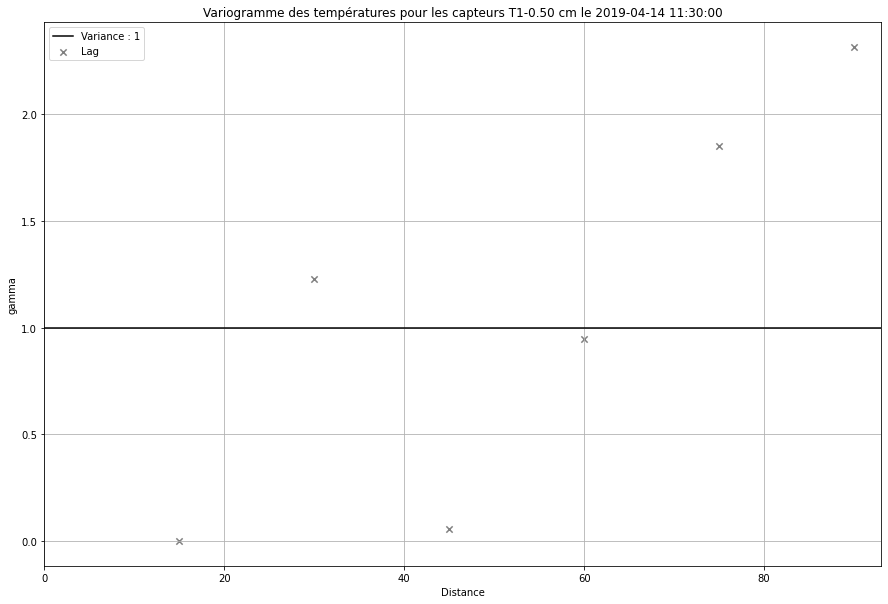

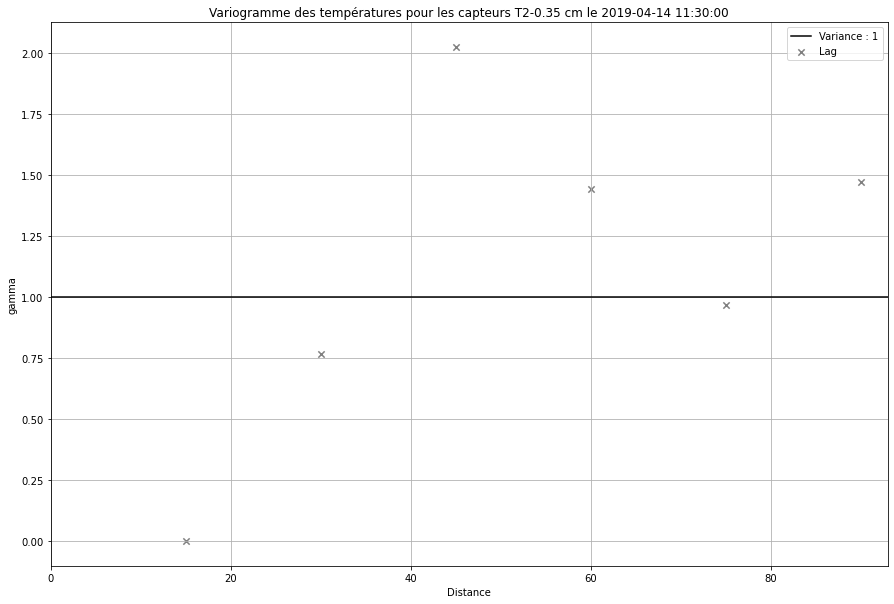

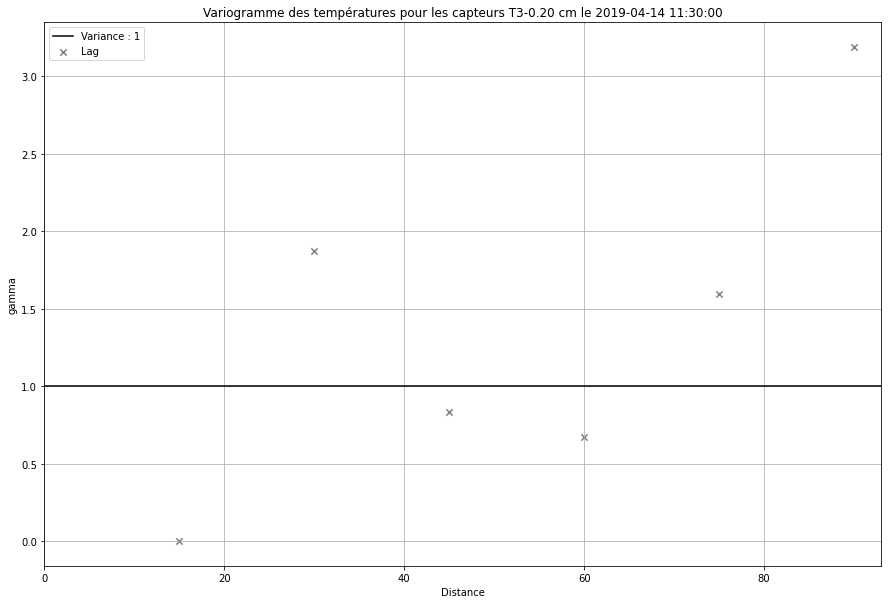

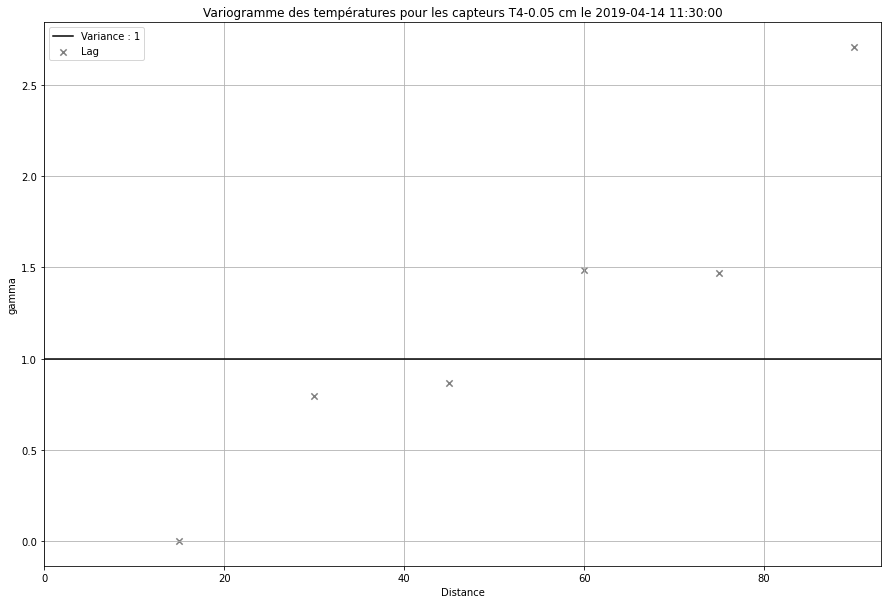

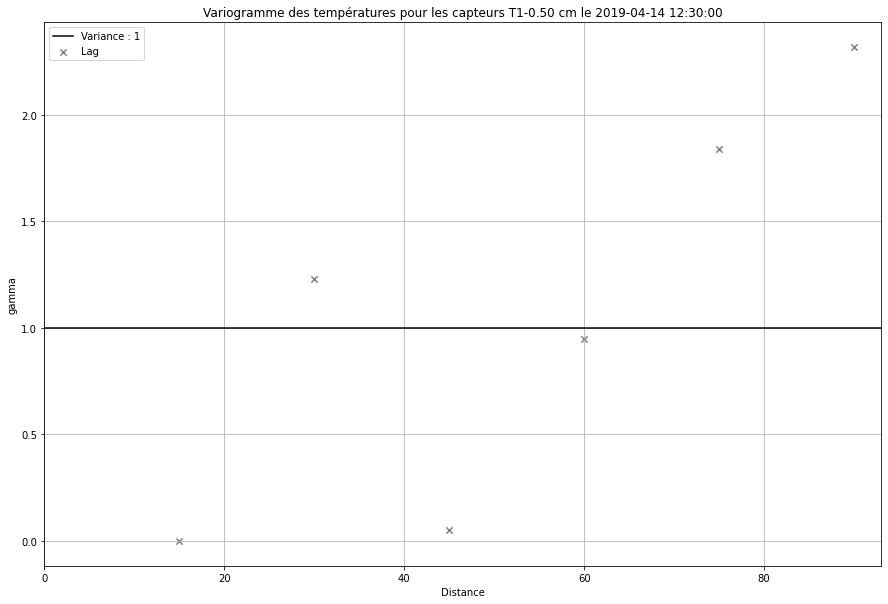

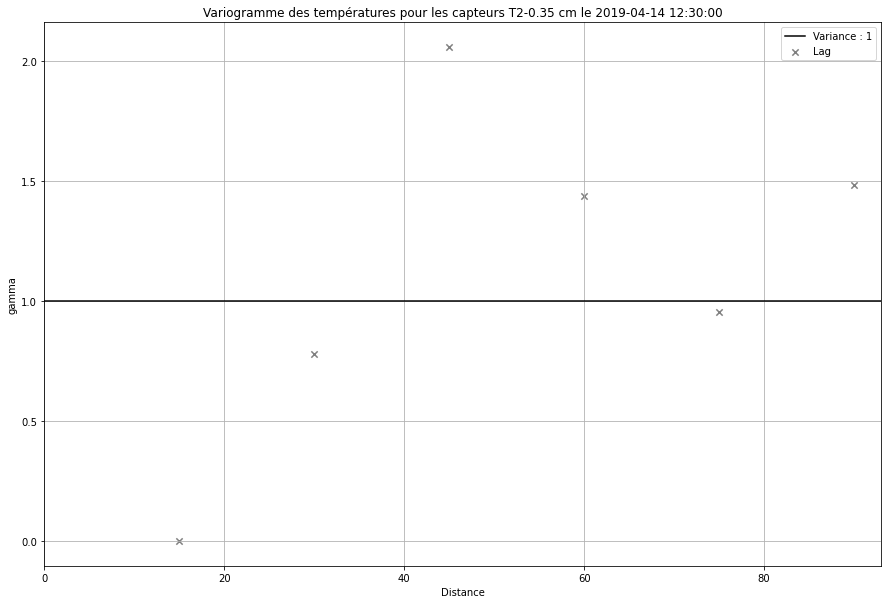

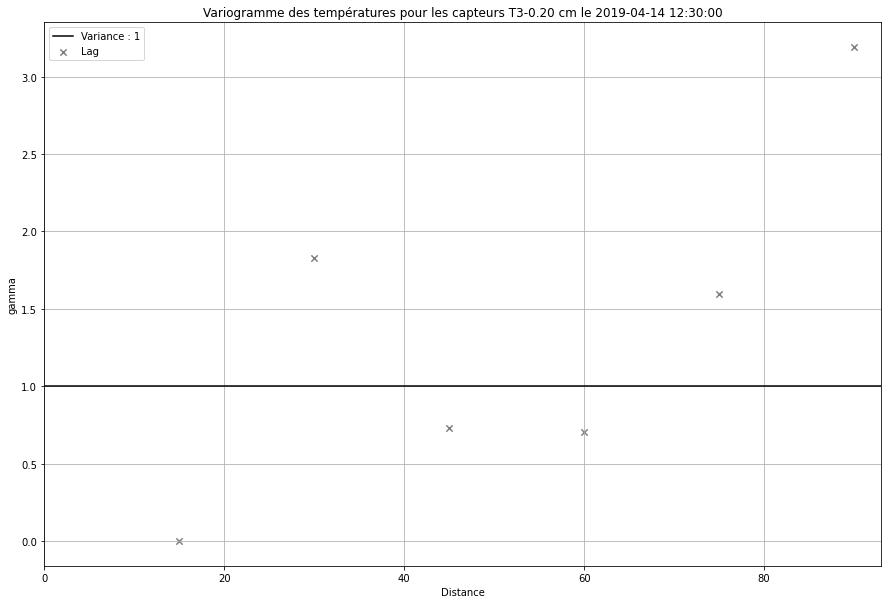

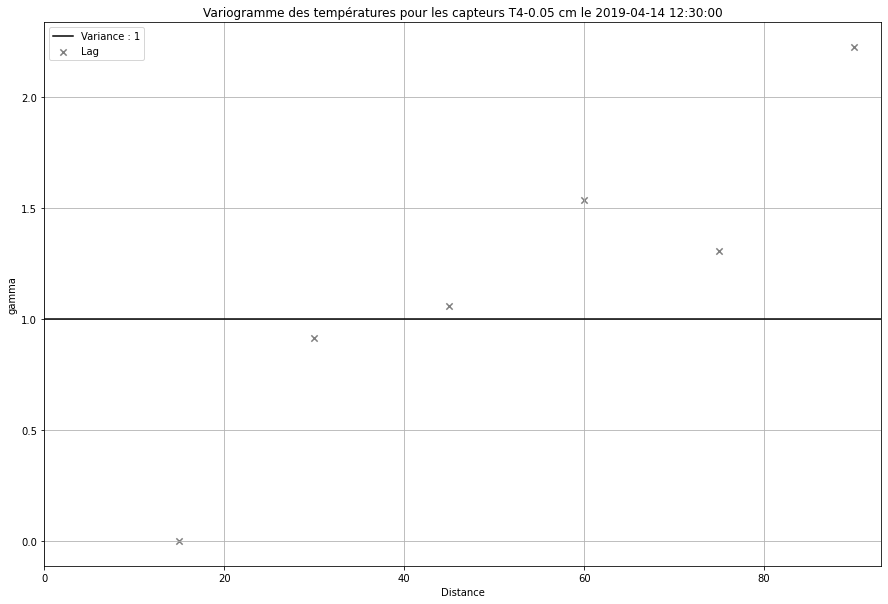

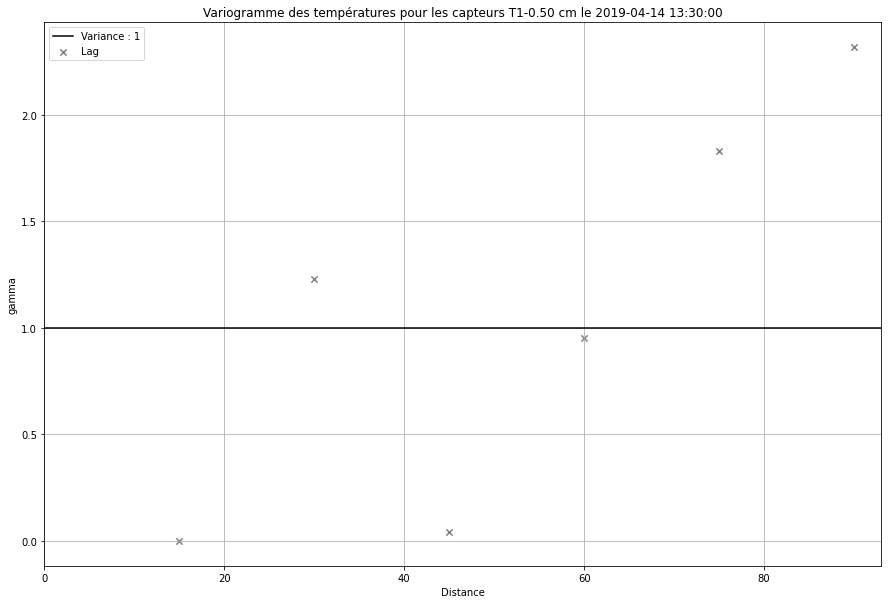

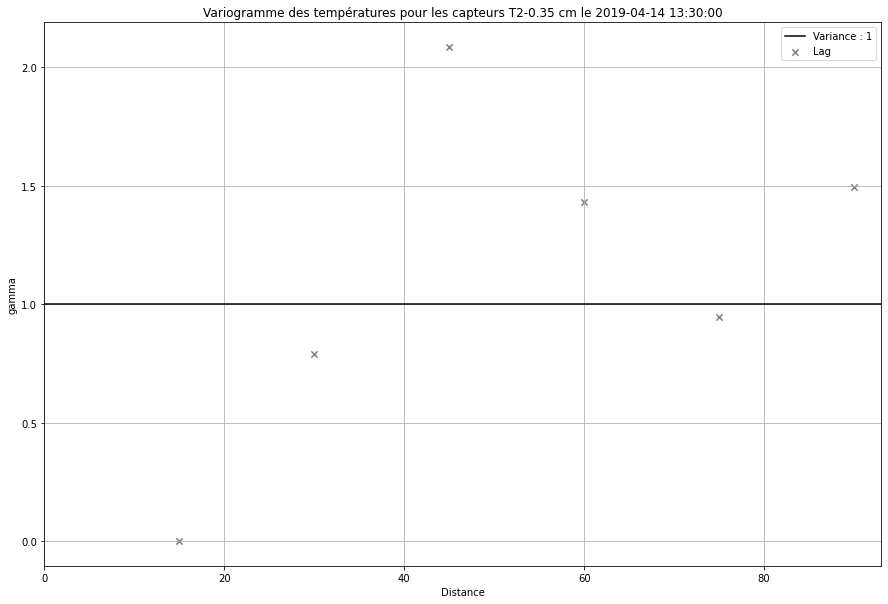

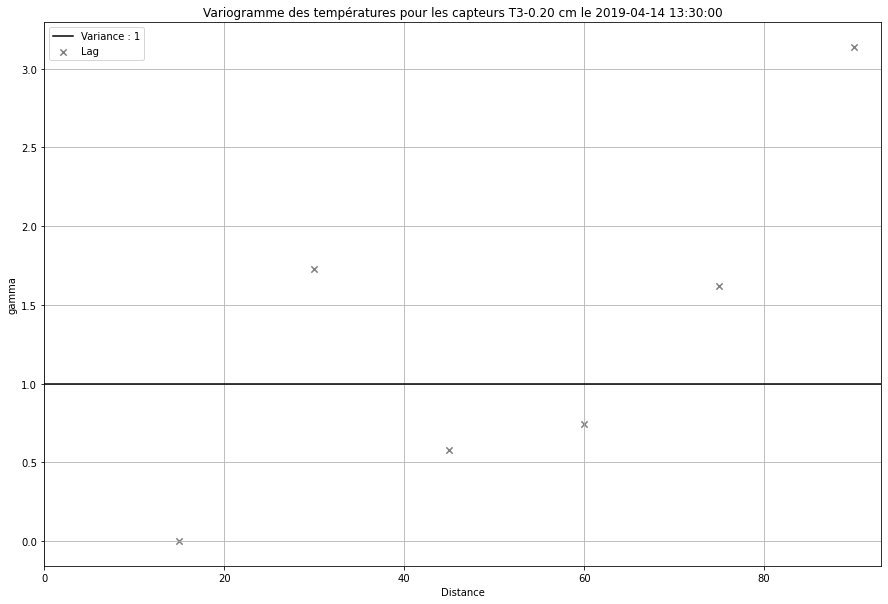

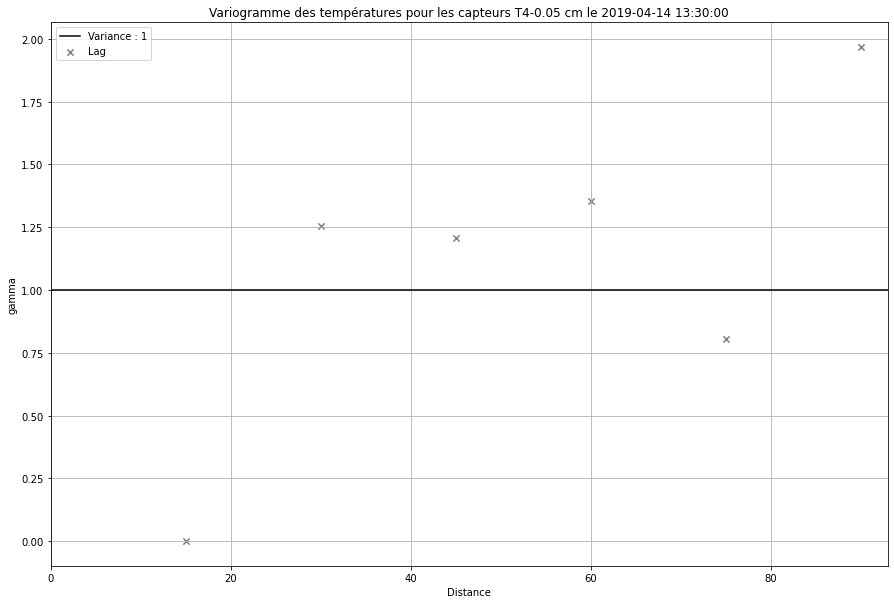

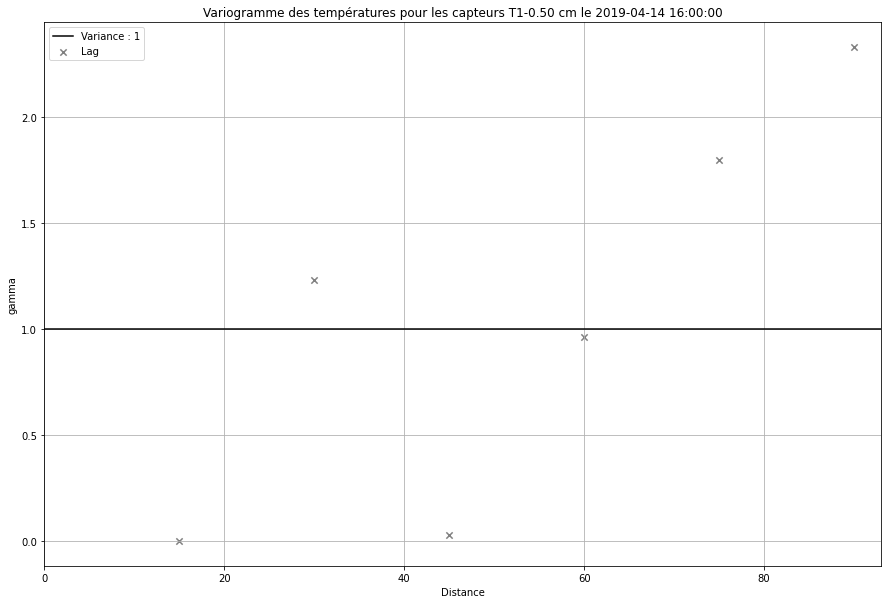

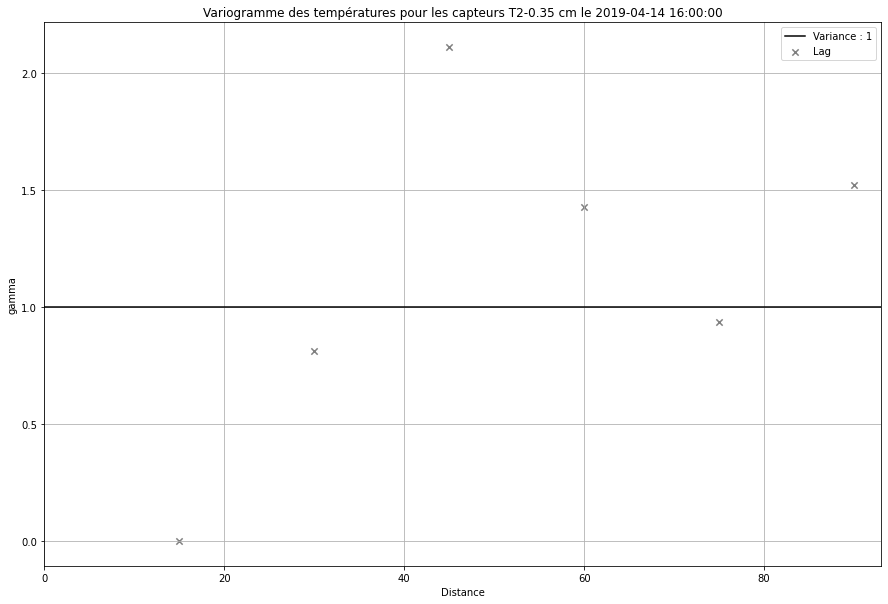

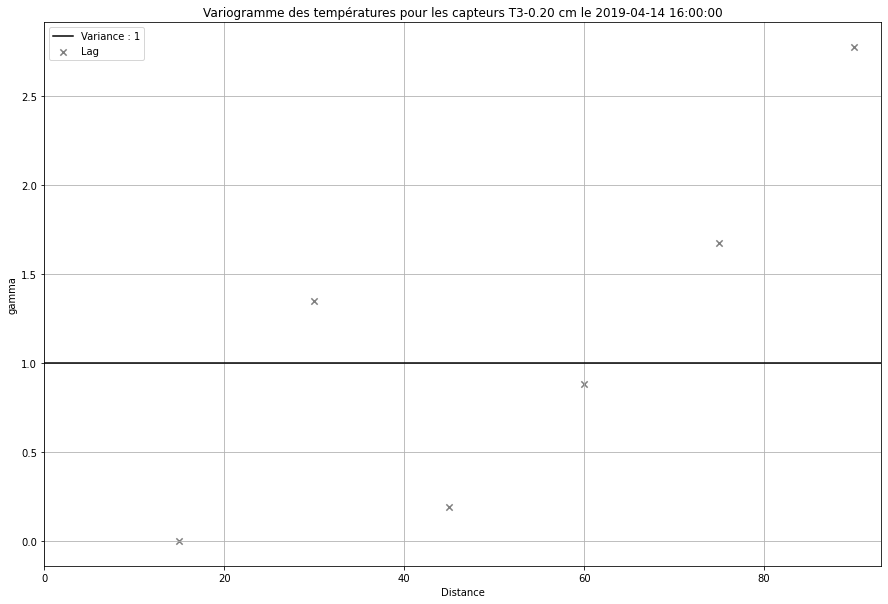

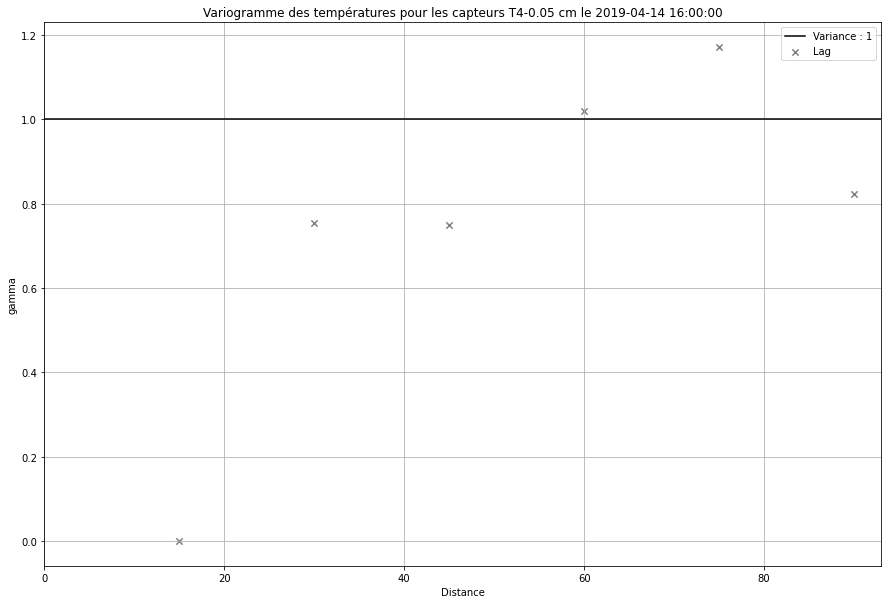

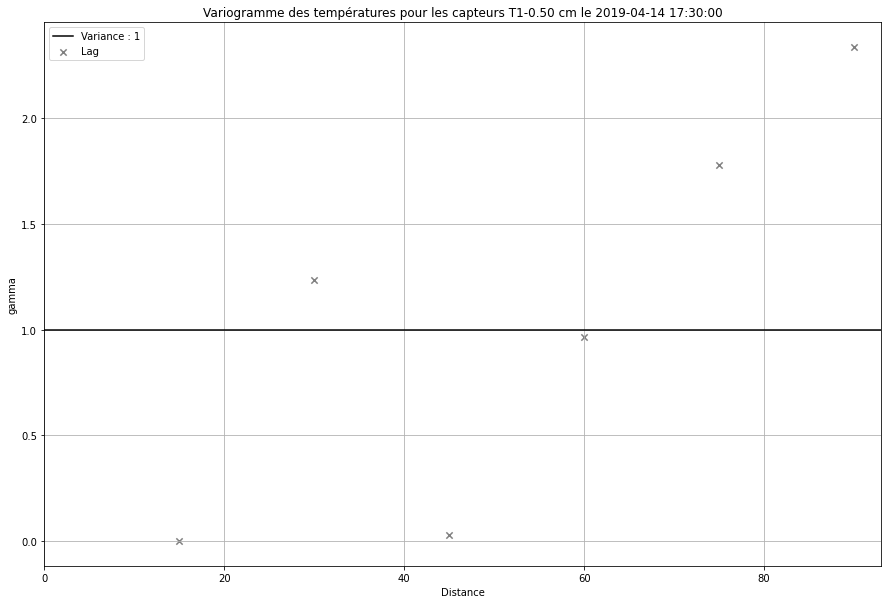

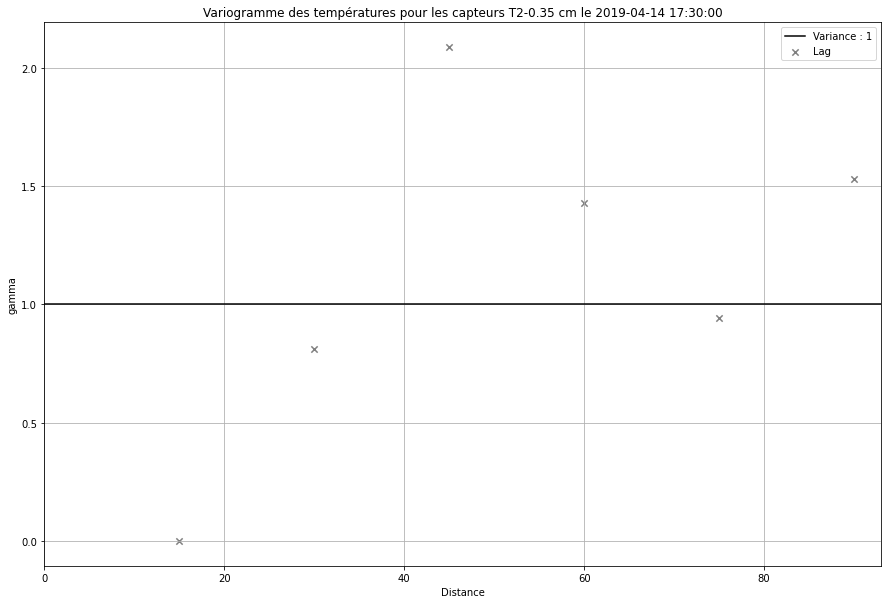

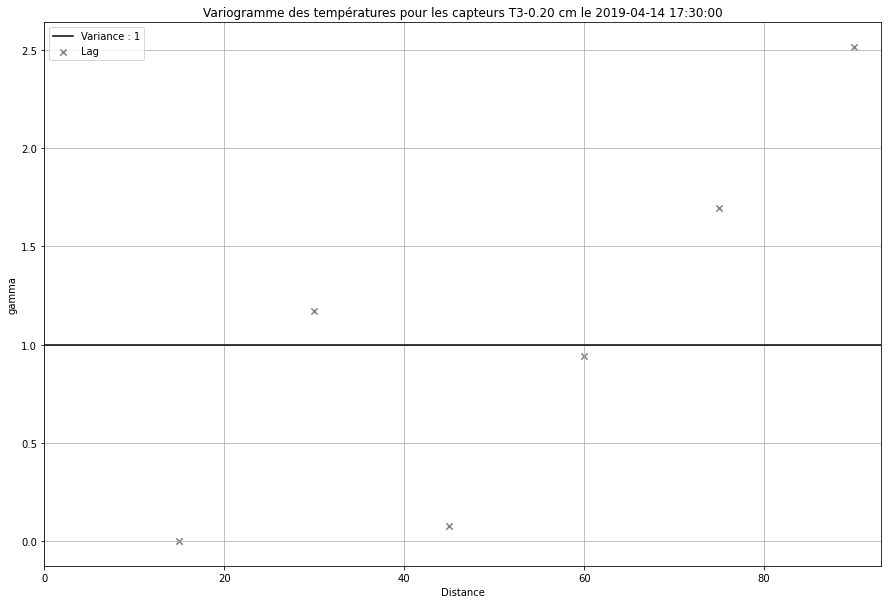

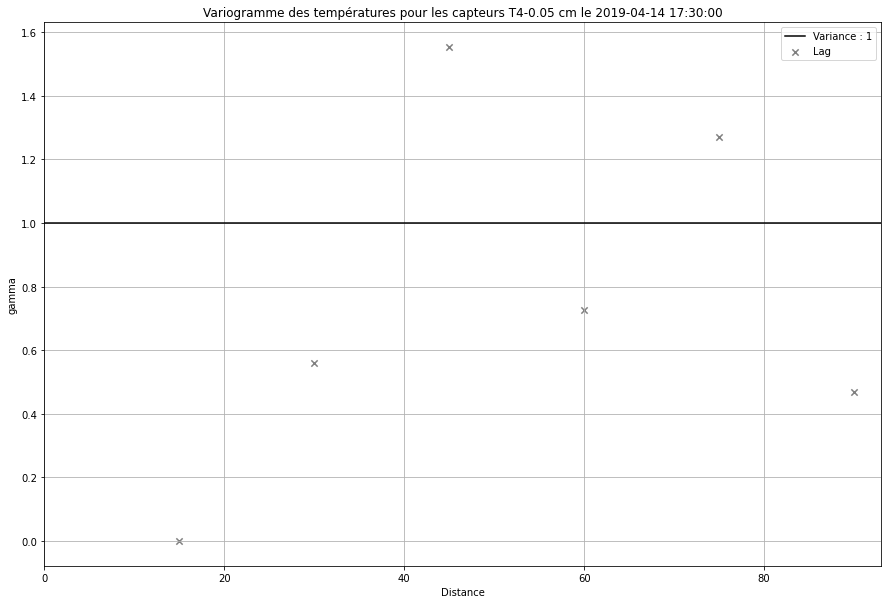

In [65]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
for REQUESTED_IR in dict_PT_all_temp :
    for TEMP in ["T1","T2","T3","T4"] :
        filename = "./varr/Primary_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        dict_Primary = np.load(filename,allow_pickle='TRUE').item()
        IR_time = dict_PT_all_temp[REQUESTED_IR]['IR_time']
        Primary_variogram = dict_Primary["Variogram"]

        dist_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Lag Distance"].values
        gam_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Variogram Value"].values
        print(gam_dir)

        ones = np.ones(shape=(100)) * varr
        H    = np.arange(0,100)
        fig,ax=plt.subplots(1,1,figsize = (15,10))
        LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
        sensor = str(LABEL[int(TEMP[-1])-1])
        ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
        ax.plot(H,ones,"black",label = "Variance : " + str(varr))
        ax.set_xlabel('Distance')
        ax.set_ylabel('gamma')
        ax.grid()
        ax.legend()
        ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
        ax.set_xlim([0,int(L)])


# Cross Variogram

In [21]:
requested_IR = ["IR_10H22"]

In [68]:
print("IR sélectionnée :",requested_IR[0])
print("sensor sélectionné :",TEMP)

IR sélectionnée : I
sensor sélectionné : T4


In [32]:
Condition = True
if Condition :
    dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
    IR_time = dict_PT_all_temp[requested_IR[0]]['IR_time']
    TEMP = 'T4'
    Pseudo_temperature = dict_PT_all_temp[requested_IR[0]]['IR_temp_value']
    Sensor_list = dict_PT_all_temp[requested_IR[0]]['Sensor_list']

In [33]:
dict_PT_all_temp

{'IR_6H55': {'T1': [10.53,
   11.018,
   9.643,
   10.883,
   9.929,
   9.416,
   10.603,
   10.211,
   10.387],
  'T2': [10.449, 11.012, 9.577, 10.707, 9.792, 9.423, 10.563, 11.61, 10.38],
  'T3': [9.595, 10.368, 8.971, 10.078, 8.556, 8.874, 9.898, 9.481, 9.846],
  'T4': [2.552, 3.543, 4.046, 4.704, 0.228, 2.633, 2.496, 2.232, 2.815],
  'IR_time': Timestamp('2019-04-14 07:00:00'),
  'IR_temp_value': [-2.397539068983635,
   -1.436520570341762,
   -2.55904933180569,
   -0.44974210376401025,
   -1.05655847824503,
   -1.6839822347640565,
   -0.5063835227451885,
   -1.2992396968240434,
   -1.056512213007008],
  'Sensor_list': {'S1': -2.397539068983635,
   'S10': -1.436520570341762,
   'S2': -2.55904933180569,
   'S4': -0.44974210376401025,
   'S5': -1.05655847824503,
   'S6': -1.6839822347640565,
   'S7': -0.5063835227451885,
   'S8': -1.2992396968240434,
   'S9': -1.056512213007008}},
 'IR_7H29': {'T1': [10.527,
   11.017,
   9.641,
   10.879,
   9.926,
   9.415,
   10.602,
   10.202,
   

In [34]:
file_requested = "./varr/Primary_variogram/"+str(requested_IR[0])+"_"+str(TEMP)+".npy"
Primary_variogram = np.load(file_requested,allow_pickle='TRUE').item()

In [39]:
Primary_variogram.keys()

dict_keys(['DataFrame', 'Variogram', 'sensor', 'IR_time'])

In [40]:
Primary = Primary_variogram["DataFrame"]

# Pseudo Température
df_PT = pd.DataFrame()
df_PT["Sensor_list"] = Sensor_list
df_PT["Pseudo_temp"] = Pseudo_temperature

In [38]:
Primary_variogram

{'DataFrame':   SensorName           x            y     T4   Primary  Pseudo_temp  Secondary
 0        S10   523628.71   5366296.81  7.854  1.100701    13.718418   0.975867
 1         S1   523654.74   5366287.75  7.646  0.936031    12.967944   0.596757
 2         S9   523692.47   5366276.57  5.424 -0.823084    10.989703  -0.402573
 3         S2   523660.22   5366258.91  5.850 -0.485828    12.650801   0.436549
 4         S4  523636.075  5366245.545  7.517  0.833904    13.107202   0.667105
 5         S5  523641.825   5366220.67  7.498  0.818862    13.113620   0.670347
 6         S8   523649.33   5366188.02  6.325 -0.109780    11.764269  -0.011292
 7         S7  523696.655    5366174.0  6.306 -0.124822    10.933354  -0.431038
 8         S6   523694.05   5366209.93  3.753 -2.145983     6.834295  -2.501721,
 'Variogram':     Lag Distance  Number of Pairs  Variogram Value  Variogram Index
 0             15              9.0         0.000000              1.0
 1             30              3.0 

In [41]:
list_value = []
for sensor in Primary["SensorName"] :
    list_value.append(df_PT["Pseudo_temp"].loc[df_PT["Sensor_list"] == sensor].mean())
copy_df = Primary.copy()
copy_df["Pseudo_temp"] = list_value
# Normal score
Primary['Pseudo_temp'] = list_value
Primary["Secondary"] = (copy_df["Pseudo_temp"]- np.mean(copy_df["Pseudo_temp"].values)) / np.sqrt(np.var(copy_df["Pseudo_temp"].values))

In [42]:
np.corrcoef(Primary["Primary"], Primary["Secondary"])[0,1]

0.7248903099966796

In [43]:
Primary

SensorName           x            y     T4   Primary  Pseudo_temp  Secondary
0        S10   523628.71   5366296.81  7.854  1.100701    13.735751   1.053959
1         S1   523654.74   5366287.75  7.646  0.936031    10.306053  -0.518897
2         S9   523692.47   5366276.57  5.424 -0.823084    10.999175  -0.201032
3         S2   523660.22   5366258.91  5.850 -0.485828    12.942797   0.690311
4         S4  523636.075  5366245.545  7.517  0.833904    13.723410   1.048299
5         S5  523641.825   5366220.67  7.498  0.818862    13.133507   0.777770
6         S8   523649.33   5366188.02  6.325 -0.109780    12.003869   0.259719
7         S7  523696.655    5366174.0  6.306 -0.124822     9.131672  -1.057467
8         S6   523694.05   5366209.93  3.753 -2.145983     6.961596  -2.052662

In [45]:
X = Primary["x"].astype(float).values
Y = Primary["y"].astype(float).values
Z = Primary["Secondary"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 9
Y : 9
Z : 9


##### Estiamtion de la distance maximale à retenir

In [46]:
distance_variable = 0
for i in range(0,len(X)) :
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
        if dist_temp > distance_variable :
            distance_variable = dist_temp
        
print("distance maximale:", distance_variable)

distance maximale: 140.35248171977688


In [47]:
L = distance_variable * 2/3
print("Distance maximale retenue :",L)
#w = 15.0 # width, taille des lags
w =15
print("nlag :" , np.int(np.fix(L/w)))

Distance maximale retenue : 93.56832114651792
nlag : 6


In [52]:
direction = [0]
angle_tolerance = 90
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))
    varr = 1

Iteration 0 / 9
direction done : 0
RUN TIME : 0.00037590001011267304


In [49]:
print("Valeurs du semi-variogramme :",gam[0])
print("Nombres de pairs :",counts[0])

Valeurs du semi-variogramme : [0.         0.66820815 0.09235378 1.66939093 2.24844981 0.60717875]
Nombres de pairs : [9. 3. 2. 7. 4. 2.]


In [533]:
Condition = False
if Condition :
    dist[0] = np.delete(dist[0],1)
    counts[0] = np.delete(counts[0],1)
    gam[0] = np.delete(gam[0],1)

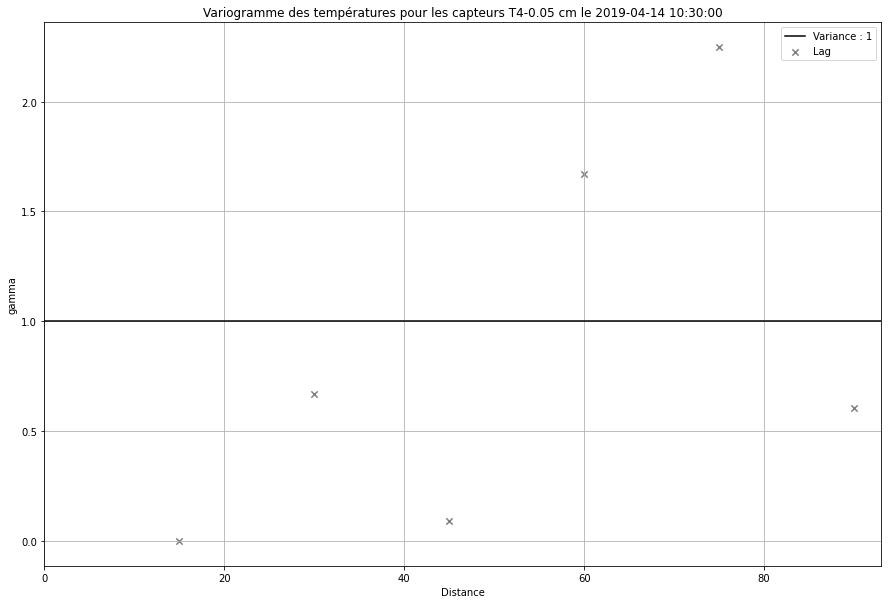

In [53]:
ones = np.ones(shape=(100)) * varr
H    = np.arange(0,100)
fig,ax=plt.subplots(1,1,figsize = (15,10))
LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
sensor = str(LABEL[int(TEMP[-1])-1])
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
    ax.plot(H,ones,"black",label = "Variance : " + str(varr))
    ax.set_xlabel('Distance')
    ax.set_ylabel('gamma')
    ax.grid()
    ax.legend()
    ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
    ax.set_xlim([0,int(L)])


## Save

In [77]:
for direction in [1,2] :
    if direction == 1 :
        index_major = np.ones((1,len(dist[0])))
        dist_major  = dist[0]
        gam_major   = gam[0]
        count_major = counts[0]
    elif direction == 2 :
        index_minor = np.ones((1,len(dist[0]))) * 2
        dist_minor  = dist[0]
        gam_minor   = gam[0]
        count_minor = counts[0]
        
index_array = np.append(index_major,index_minor)
dist_array  = np.append(dist_major,dist_minor)
gam_array   = np.append(gam_major,gam_minor)
count_array   = np.append(count_major,count_minor)

varc_3 = pd.DataFrame()
varc_3["Lag Distance"] = dist_array
varc_3["Number of Pairs"] = count_array
varc_3["Variogram Value"] = gam_array
varc_3["Variogram Index"] = index_array 

In [78]:
varc_3

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
0             15              9.0         0.000000              1.0
1             30              3.0         0.028234              1.0
2             45              2.0         0.365823              1.0
3             60              7.0         1.851450              1.0
4             75              4.0         2.195129              1.0
5             90              2.0         2.423477              1.0
6             15              9.0         0.000000              2.0
7             30              3.0         0.028234              2.0
8             45              2.0         0.365823              2.0
9             60              7.0         1.851450              2.0
10            75              4.0         2.195129              2.0
11            90              2.0         2.423477              2.0

In [32]:
condition = False
if condition :
    header = ["Lag Distance","Number of Pairs","Variogram Value","Variogram Index"]
    varc_3.to_csv('./varr/varc_3.csv',index=False, header = header)
    Primary.to_csv('./varr/Primary_2.csv',index=False)

In [83]:
Cross_variogram = {"DataFrame ": Primary ,
                    "Variogram" : varc_3,
                    "sensor" : TEMP,
                     "IR_time" :requested_IR[0]}

In [84]:
filename = "./varr/Cross_variogram/"+str(requested_IR[0])+"_"+str(TEMP)+".npy"
np.save(filename,Cross_variogram)

## Boucle

In [79]:
file_requested = "./varr/Primary_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
Primary_variogram = np.load(file_requested,allow_pickle='TRUE').item()

In [109]:
dict_PT_all_temp.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [81]:
copy_df

SensorName           x            y     T4   Primary  Pseudo_temp  Secondary
0        S10   523628.71   5366296.81  7.854  1.100701    13.735751   0.975867
1         S1   523654.74   5366287.75  7.646  0.936031    10.306053   0.596757
2         S9   523692.47   5366276.57  5.424 -0.823084    10.999175  -0.402573
3         S2   523660.22   5366258.91  5.850 -0.485828    12.942797   0.436549
4         S4  523636.075  5366245.545  7.517  0.833904    13.723410   0.667105
5         S5  523641.825   5366220.67  7.498  0.818862    13.133507   0.670347
6         S8   523649.33   5366188.02  6.325 -0.109780    12.003869  -0.011292
7         S7  523696.655    5366174.0  6.306 -0.124822     9.131672  -0.431038
8         S6   523694.05   5366209.93  3.753 -2.145983     6.961596  -2.501721

In [83]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
for requested_IR in dict_PT_all_temp :
    for TEMP in ["T1","T2","T3","T4"] :
        IR_time = dict_PT_all_temp[requested_IR]['IR_time']
        Pseudo_temperature = dict_PT_all_temp[requested_IR]['IR_temp_value']
        Sensor_list = dict_PT_all_temp[requested_IR]['Sensor_list']
        file_requested = "./varr/Primary_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
        Primary_variogram = np.load(file_requested,allow_pickle='TRUE').item()
        Primary = Primary_variogram["DataFrame"]
        
        # Pseudo Température
        df_PT = pd.DataFrame()
        df_PT["Sensor_list"] = Sensor_list
        df_PT["Pseudo_temp"] = Pseudo_temperature
        list_value = []
        for sensor in Primary["SensorName"] :
            list_value.append(df_PT["Pseudo_temp"].loc[df_PT["Sensor_list"] == sensor].mean())
        Primary['Pseudo_temp'] = list_value
        # Normal score
        Primary["Secondary"] = (Primary["Pseudo_temp"]- np.mean(Primary["Pseudo_temp"].values)) / np.sqrt(np.var(Primary["Pseudo_temp"].values))
        
        X = Primary["x"].astype(float).values
        Y = Primary["y"].astype(float).values
        Z = Primary["Secondary"].astype(float).values
        
        ## Distance à retenir
        distance_variable = 0
        for i in range(0,len(X)) :
            for j in range (0,len(X)) :
                x = X[i] - X[j]
                y = Y[i] - Y[j]
                dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
                if dist_temp > distance_variable :
                    distance_variable = dist_temp
        
        ## Calcul du variogram
        L = distance_variable * 2/3
        w =15
        direction = [0]
        angle_tolerance = 90
        dist, counts, gam = {}, {}, {}

        for Dir in direction :
            st1 = timeit.default_timer()
            dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
            st2 = timeit.default_timer()
            #print("RUN TIME : {0}".format(st2-st1))
            #print("Variogram Value :", gam[Dir])
            #print("Z :", gam[Dir],"\n")
        
        ## Save
        for direction in [1,2] :
            if direction == 1 :
                index_major = np.ones((1,len(dist[0])))
                dist_major  = dist[0]
                gam_major   = gam[0]
                count_major = counts[0]
            elif direction == 2 :
                index_minor = np.ones((1,len(dist[0]))) * 2
                dist_minor  = dist[0]
                gam_minor   = gam[0]
                count_minor = counts[0]

        index_array = np.append(index_major,index_minor)
        dist_array  = np.append(dist_major,dist_minor)
        gam_array   = np.append(gam_major,gam_minor)
        count_array   = np.append(count_major,count_minor)

        varc_3 = pd.DataFrame()
        varc_3["Lag Distance"] = dist_array
        varc_3["Number of Pairs"] = count_array
        varc_3["Variogram Value"] = gam_array
        varc_3["Variogram Index"] = index_array 
            
        Cross_variogram = {"DataFrame": Primary ,
                     "Variogram" : varc_3,
                     "sensor" : TEMP,
                     "IR_time" :IR_time}
        
        filename = "./varr/Cross_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
        np.save(filename,Cross_variogram)
    print("Complited :",requested_IR)
        

Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_6H55
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_7H29
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_8H22
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_9H28
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_10H22
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_11H27
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_12H31
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_13H26
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_15H59
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Iteration 0 / 9
Complited : IR_17H27


In [67]:
dict_PT_all_temp.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [84]:
Requested_IR = "IR_8H22"
TEMP = "T4"
filename = "./varr/Cross_variogram/Boucle/"+str(Requested_IR)+"_"+str(TEMP)+".npy"
np.load(filename,allow_pickle='TRUE').item()['Variogram']

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
0             15              9.0         0.000000              1.0
1             30              3.0         0.414727              1.0
2             45              2.0         0.002221              1.0
3             60              7.0         1.345532              1.0
4             75              4.0         1.890331              1.0
5             90              2.0         0.147939              1.0
6             15              9.0         0.000000              2.0
7             30              3.0         0.414727              2.0
8             45              2.0         0.002221              2.0
9             60              7.0         1.345532              2.0
10            75              4.0         1.890331              2.0
11            90              2.0         0.147939              2.0

In [85]:
Requested_IR = "IR_12H31"
TEMP = "T4"
filename = "./varr/Cross_variogram/Boucle/"+str(Requested_IR)+"_"+str(TEMP)+".npy"
np.load(filename,allow_pickle='TRUE').item()['Variogram']

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
0             15              9.0         0.000000              1.0
1             30              3.0         2.314664              1.0
2             45              2.0         0.044983              1.0
3             60              7.0         0.709159              1.0
4             75              4.0         0.889457              1.0
5             90              2.0         2.122783              1.0
6             15              9.0         0.000000              2.0
7             30              3.0         2.314664              2.0
8             45              2.0         0.044983              2.0
9             60              7.0         0.709159              2.0
10            75              4.0         0.889457              2.0
11            90              2.0         2.122783              2.0

SensorName           x            y      T4   Primary  Pseudo_temp  \
0        S10   523628.71   5366296.81  13.305 -0.156627    14.147304   
1         S1   523654.74   5366287.75  13.249 -0.186965    14.160220   
2         S9   523692.47   5366276.57  16.537  1.594320    13.822776   
3         S2   523660.22   5366258.91  11.116 -1.342525    13.987761   
4         S4  523636.075  5366245.545  12.736 -0.464885    13.486543   
5         S5  523641.825   5366220.67  15.361  0.957218    13.100141   
6         S8   523649.33   5366188.02  12.142 -0.786686    13.386816   
7         S7  523696.655    5366174.0  16.123  1.370034    14.116577   
8         S6   523694.05   5366209.93  11.778 -0.983884    13.184495   

   Secondary  
0   1.088165  
1   1.120325  
2   0.280085  
3   0.690901  
4  -0.557139  
5  -1.519287  
6  -0.805461  
7   1.011656  
8  -1.309246

In [90]:
dict_PT_all_temp[REQUESTED_IR]['IR_time']

Timestamp('2019-04-14 17:30:00')

<ipython-input-93-a4c4f19df92a>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1,figsize = (15,10))


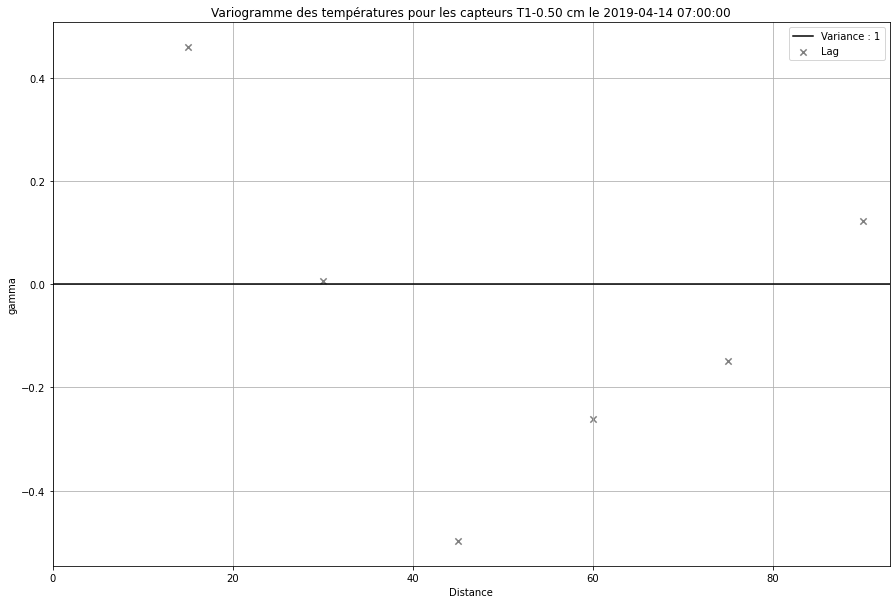

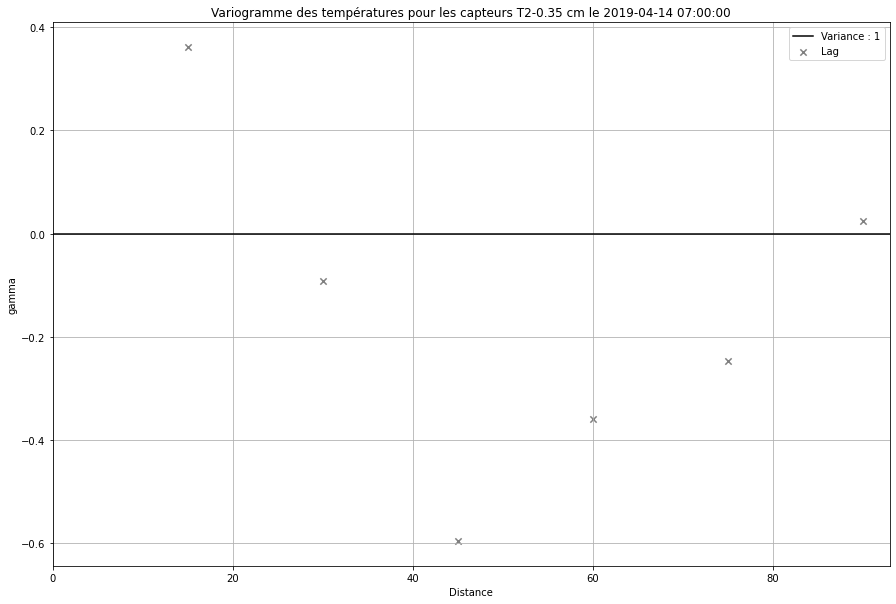

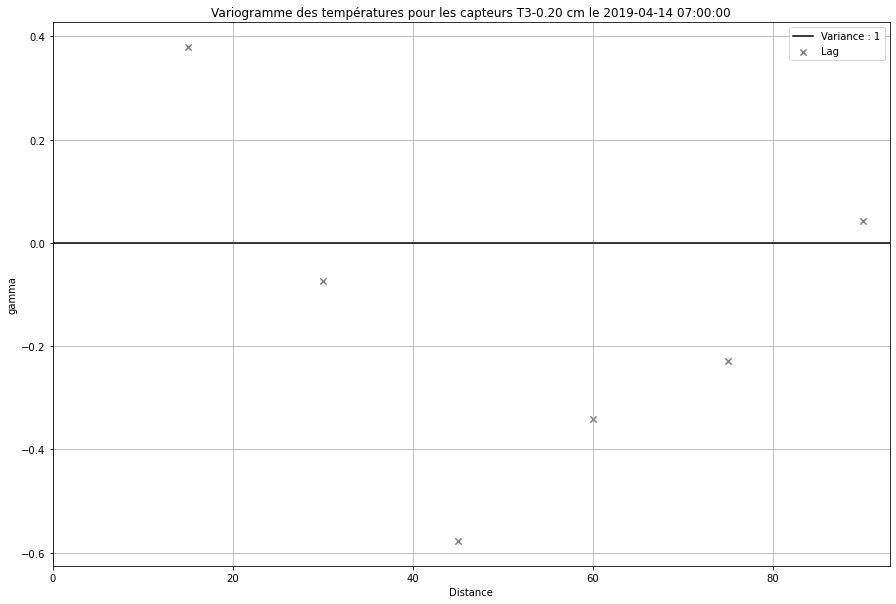

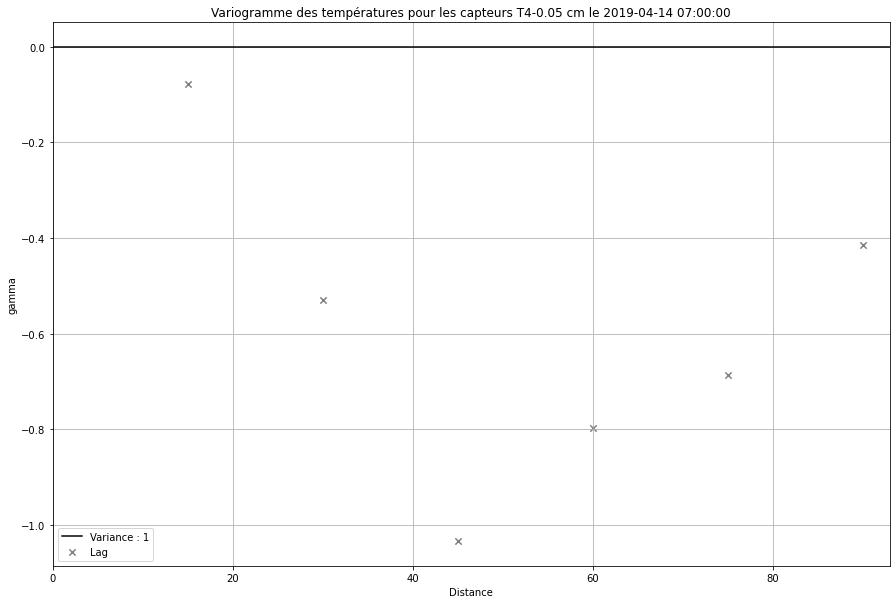

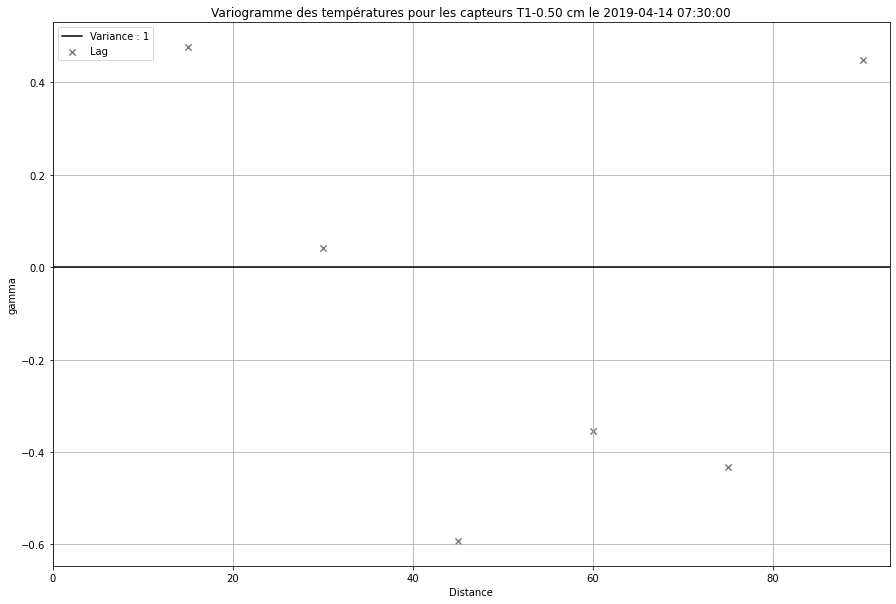

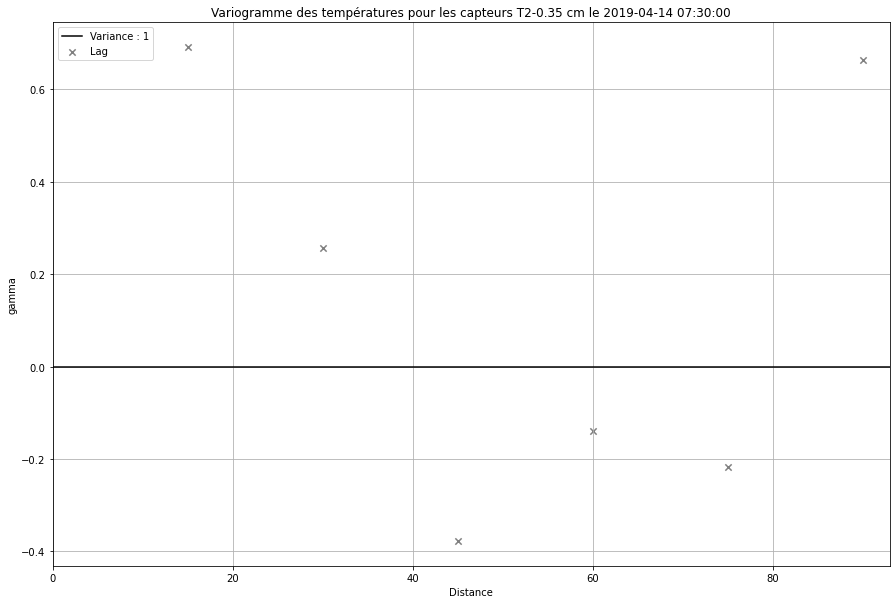

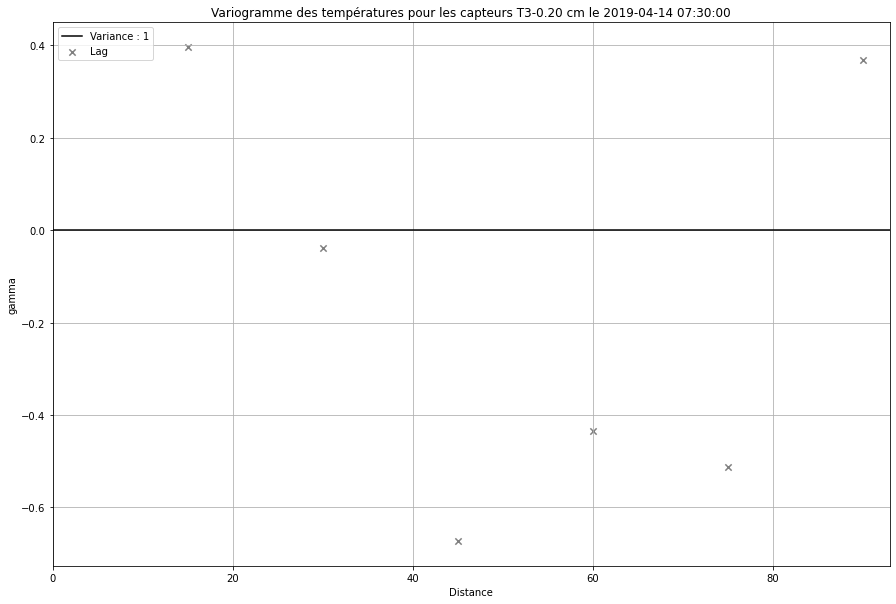

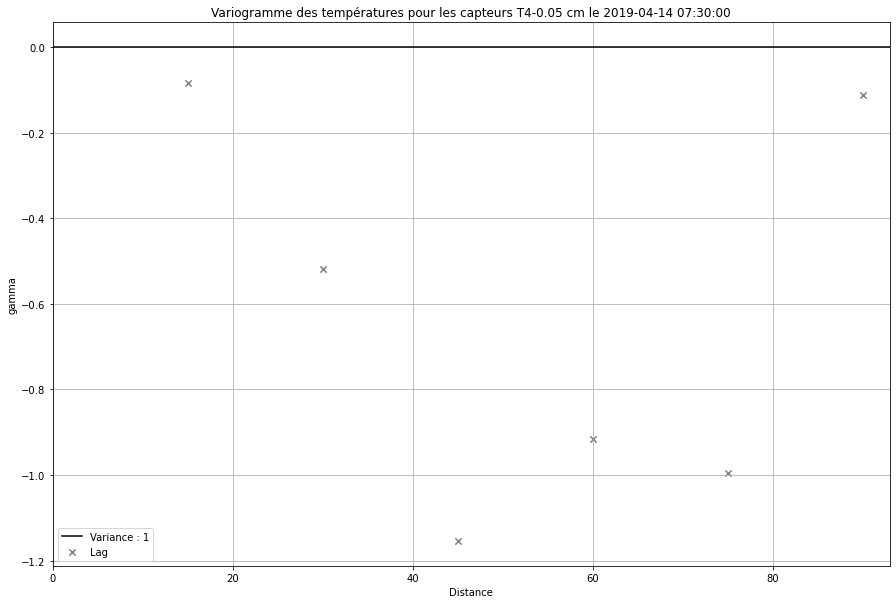

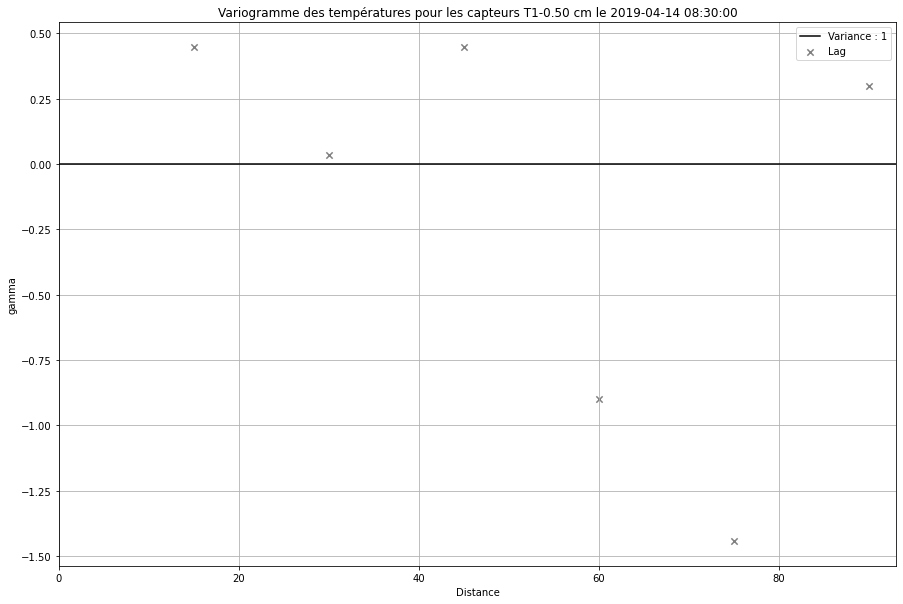

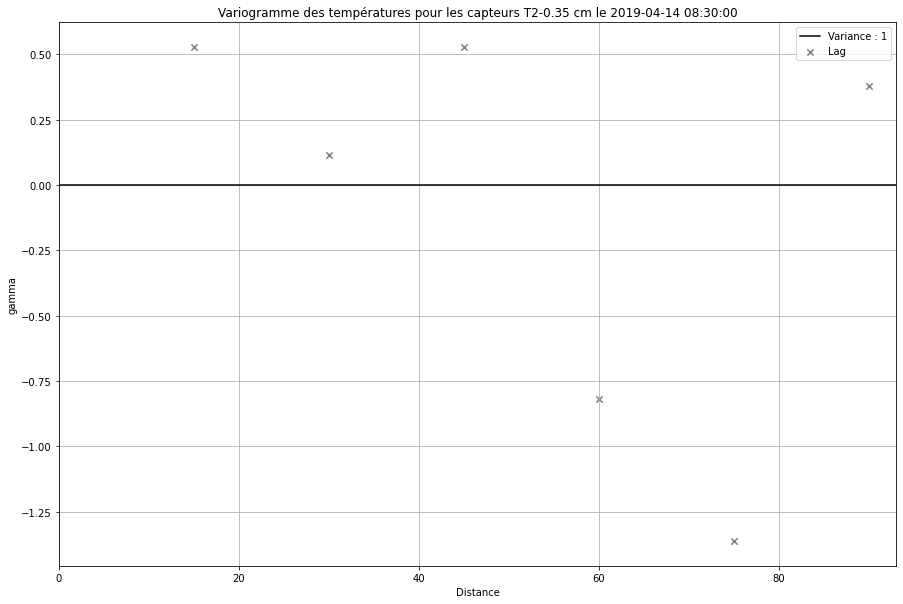

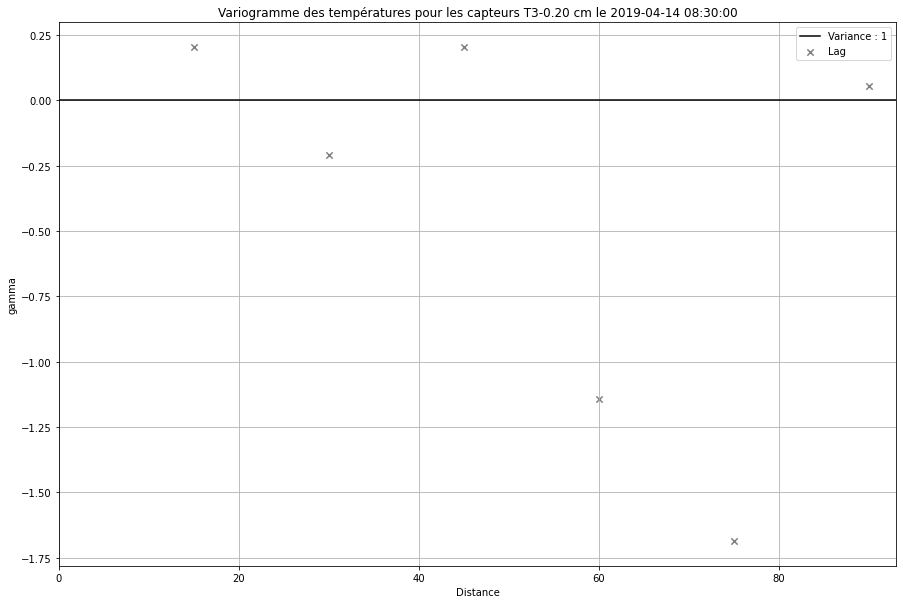

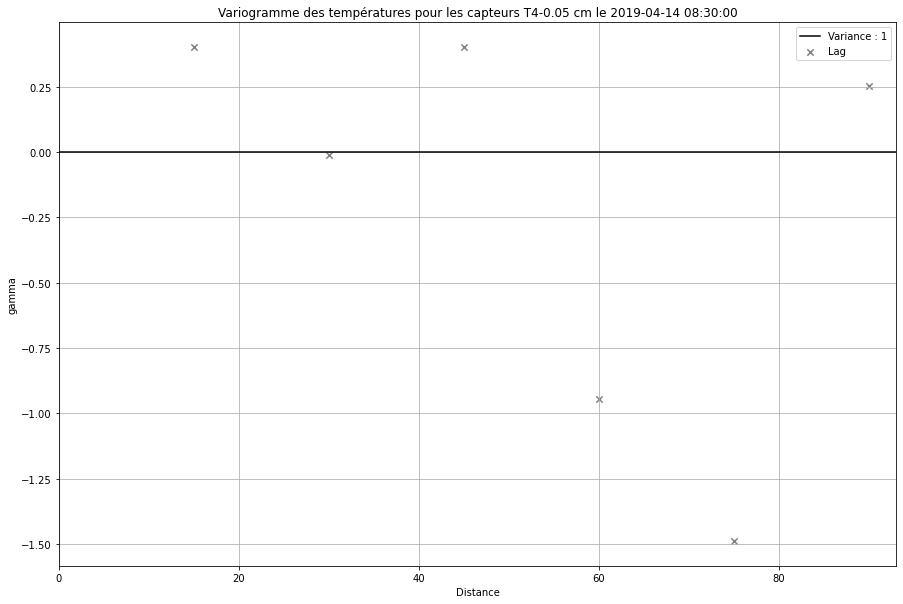

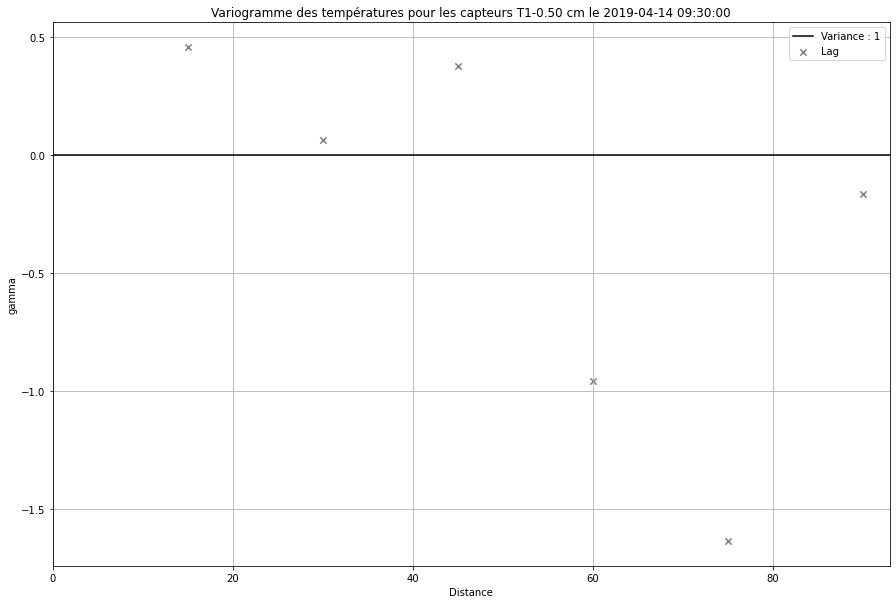

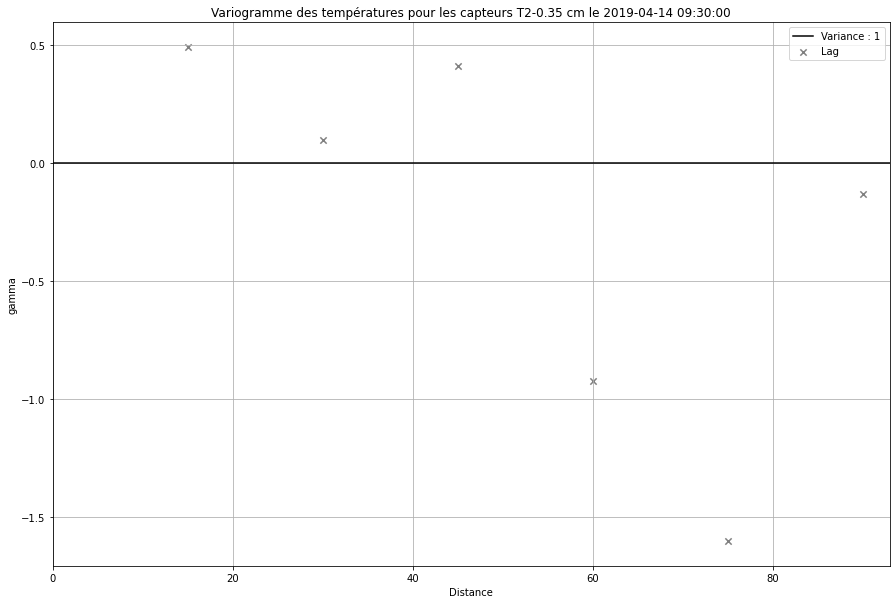

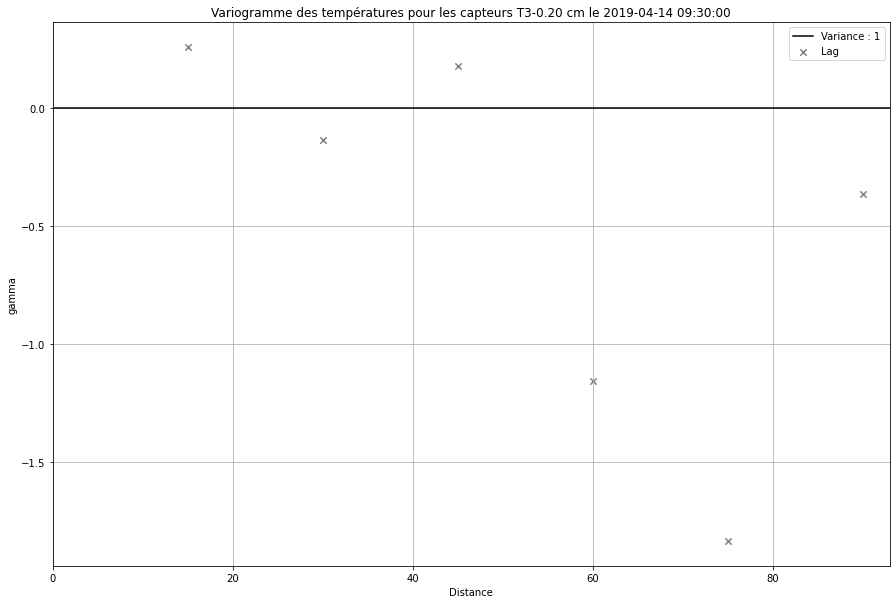

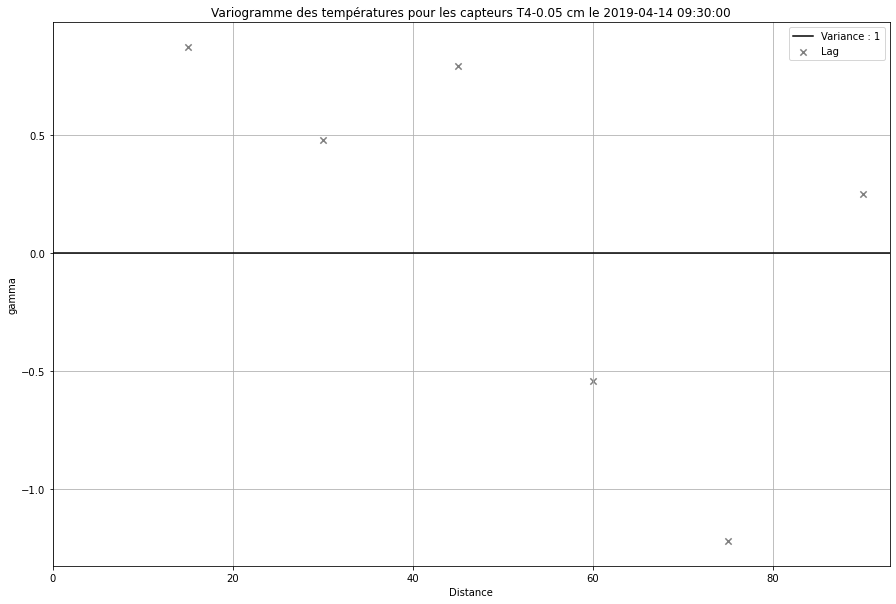

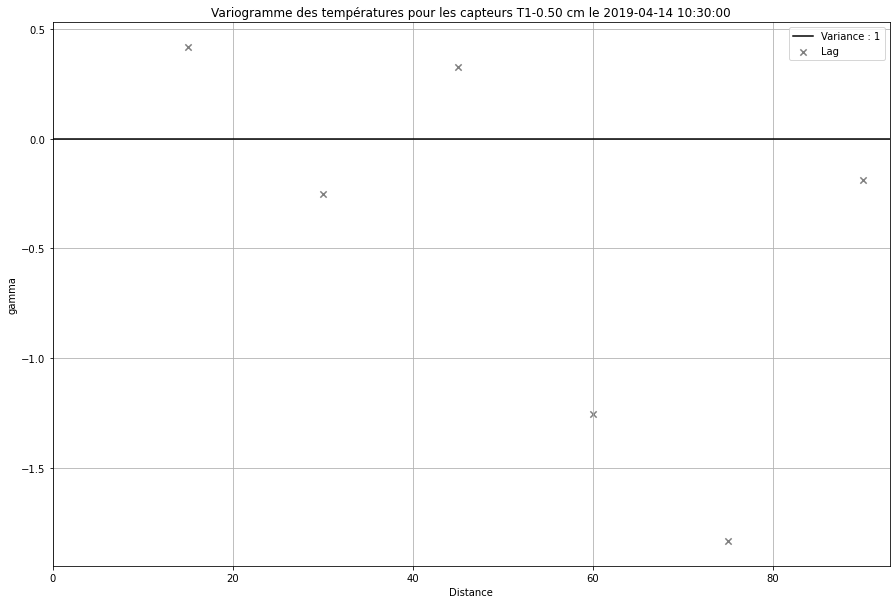

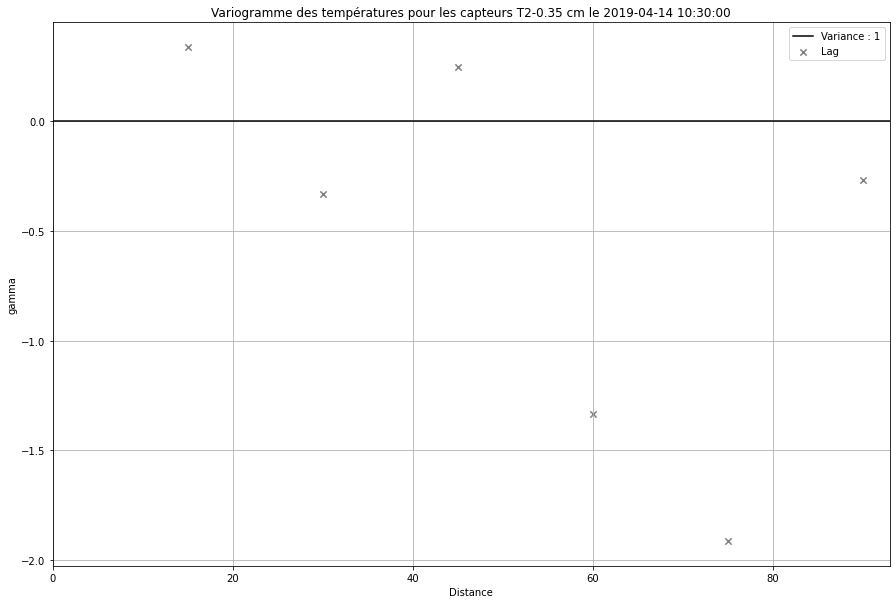

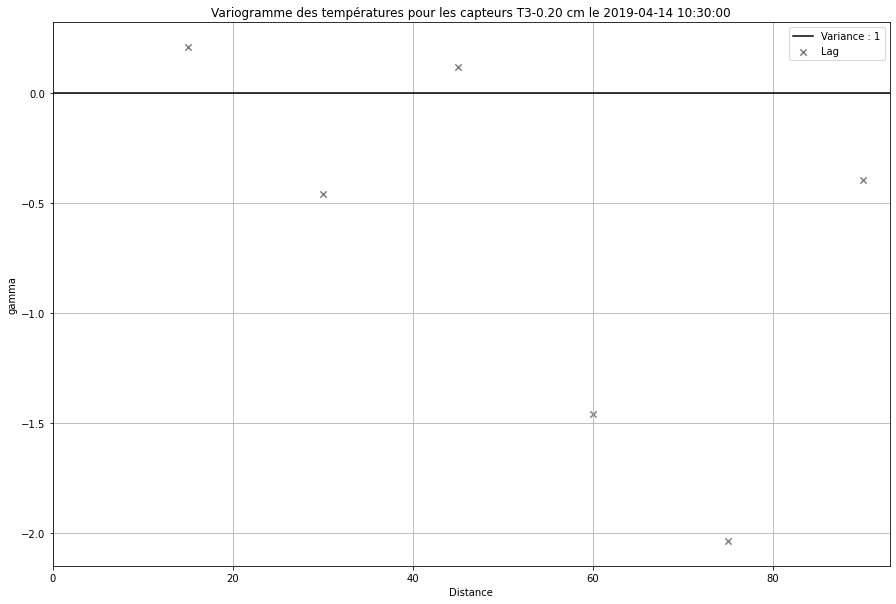

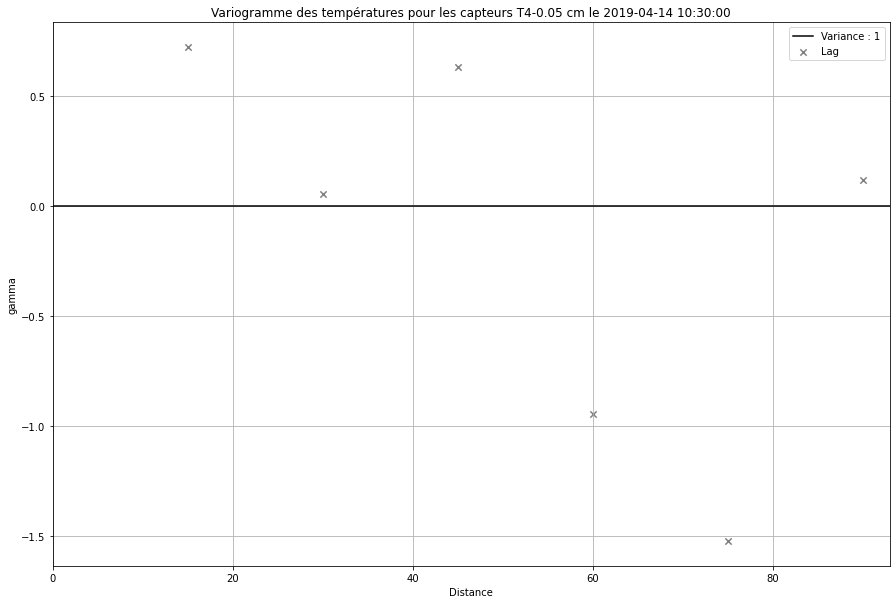

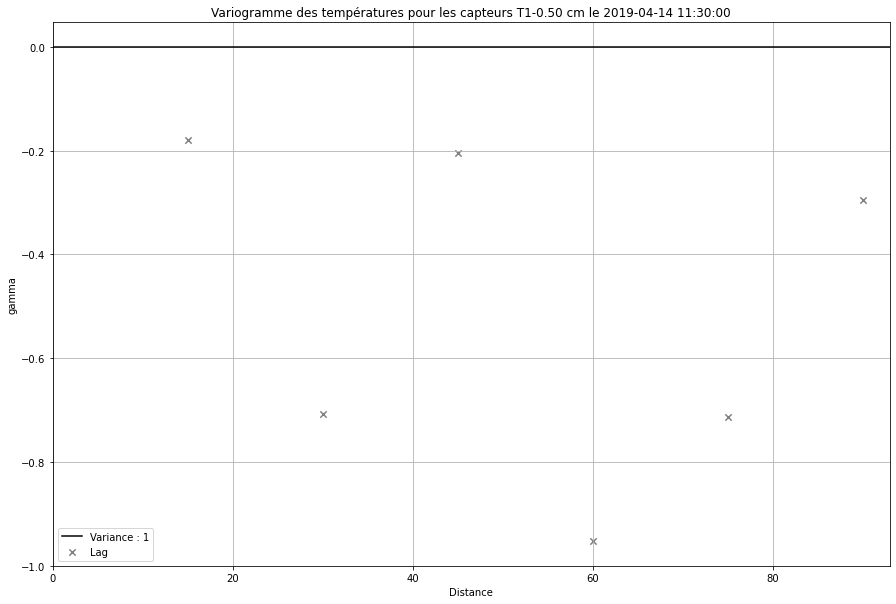

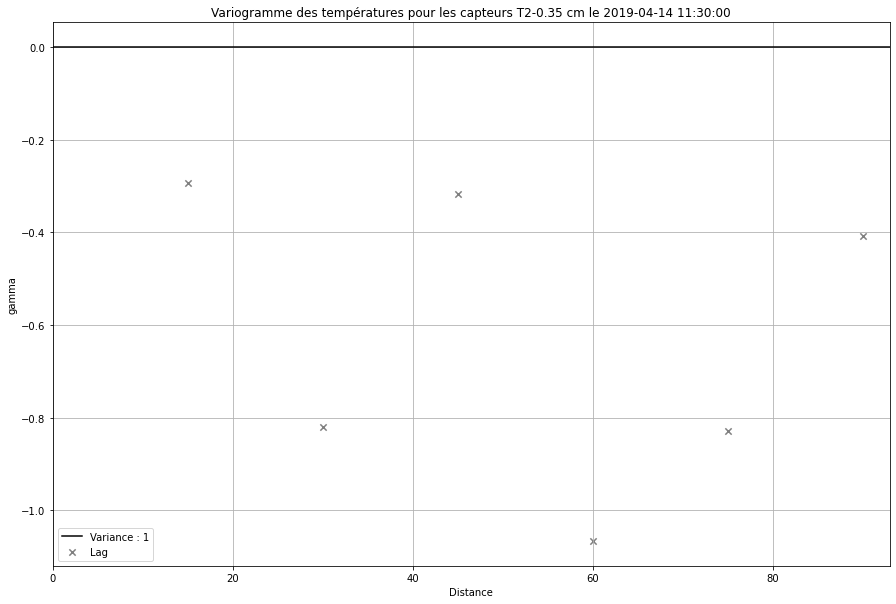

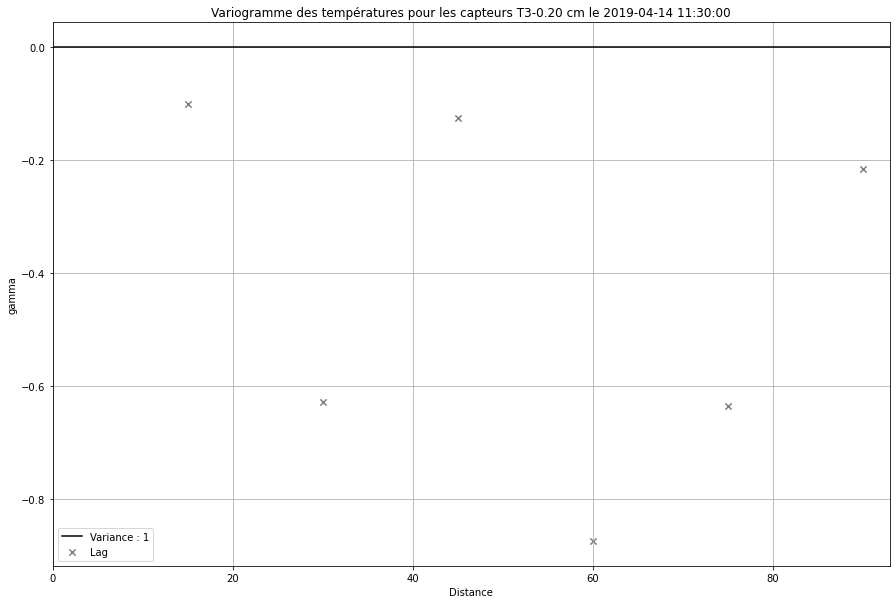

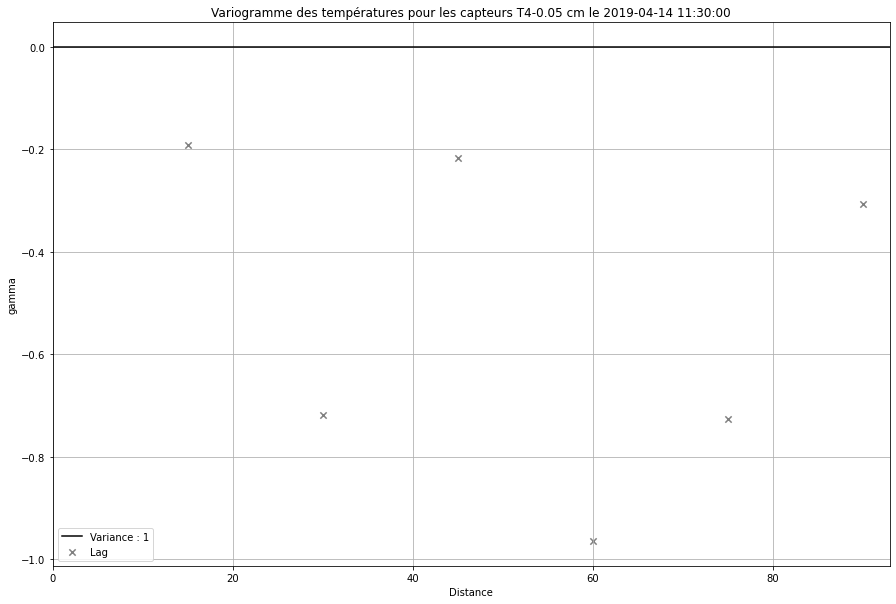

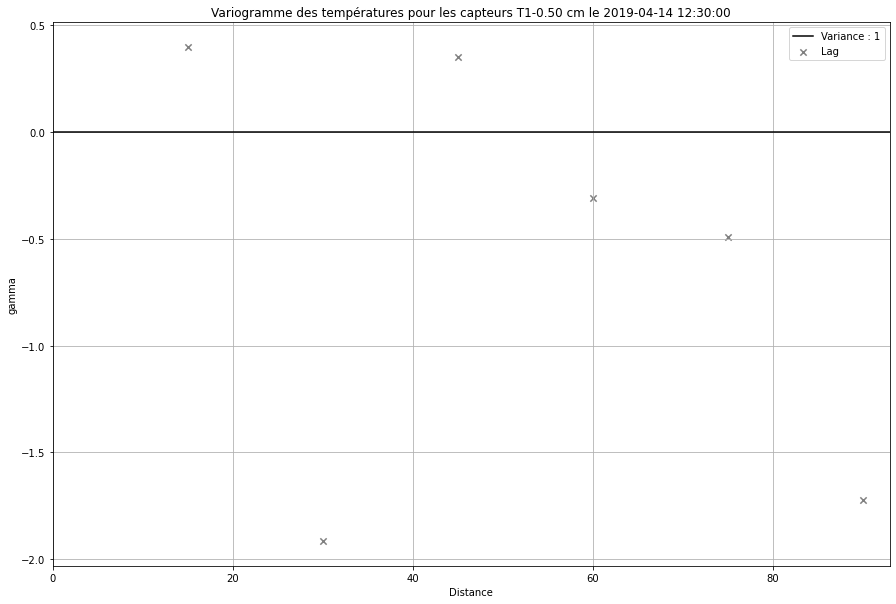

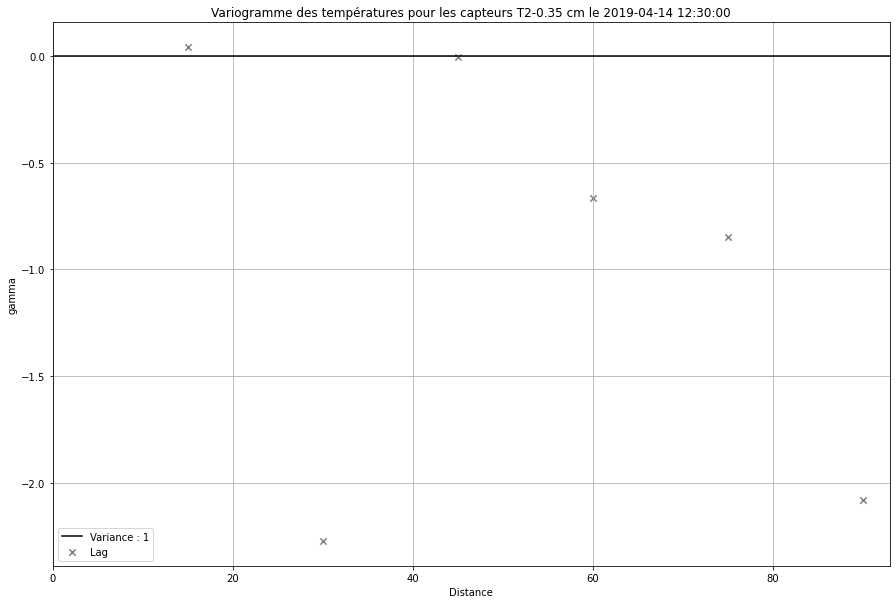

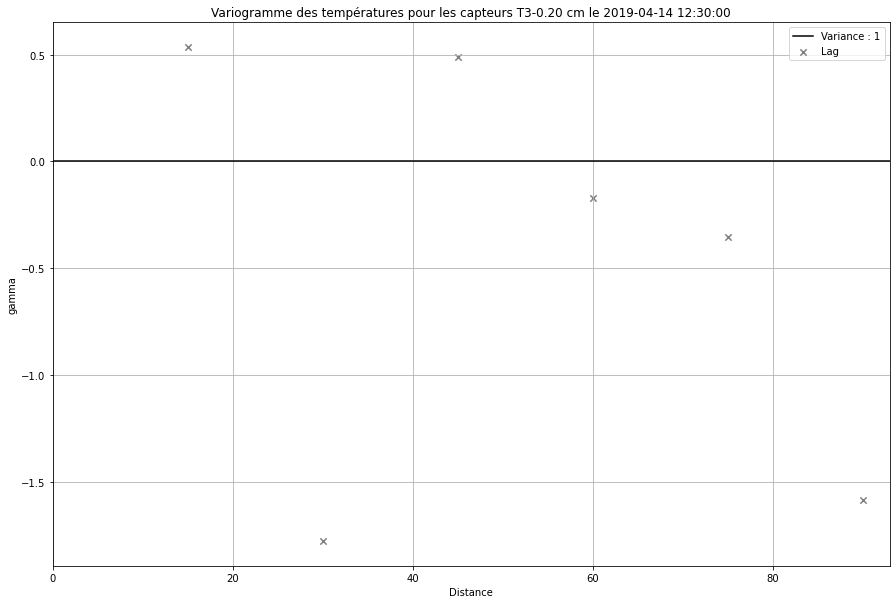

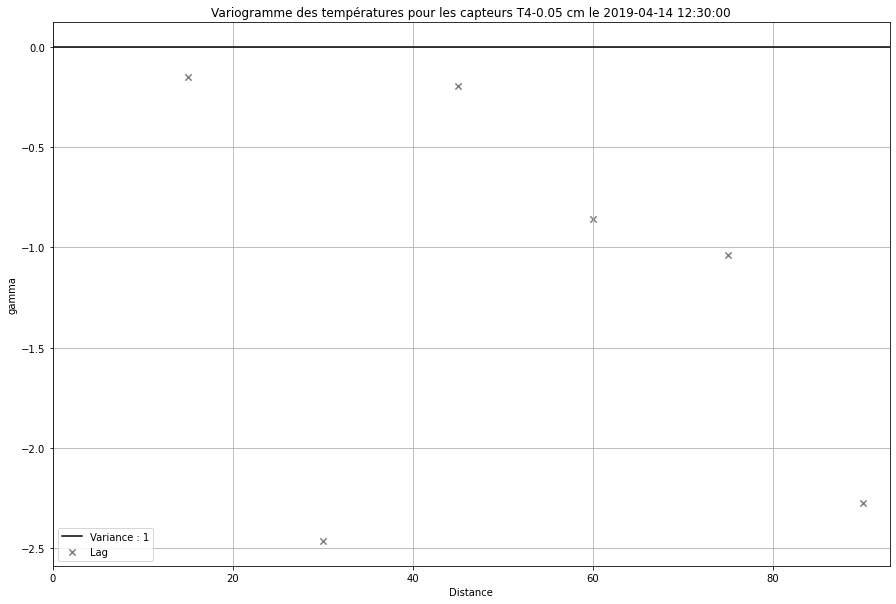

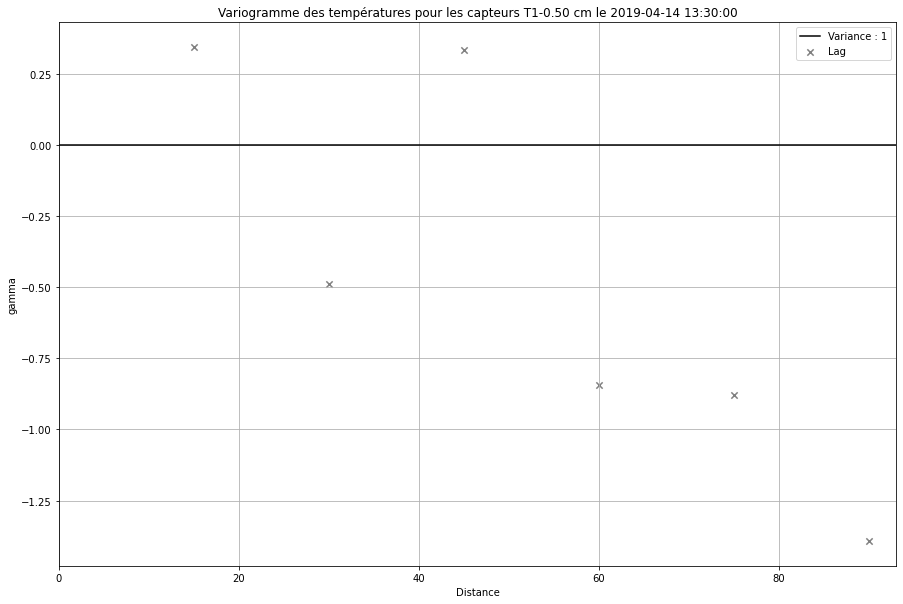

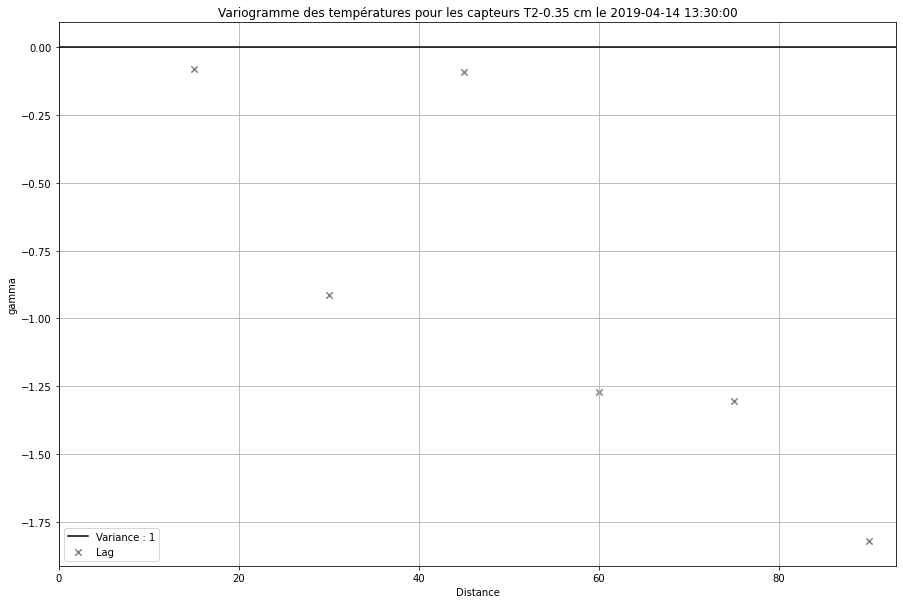

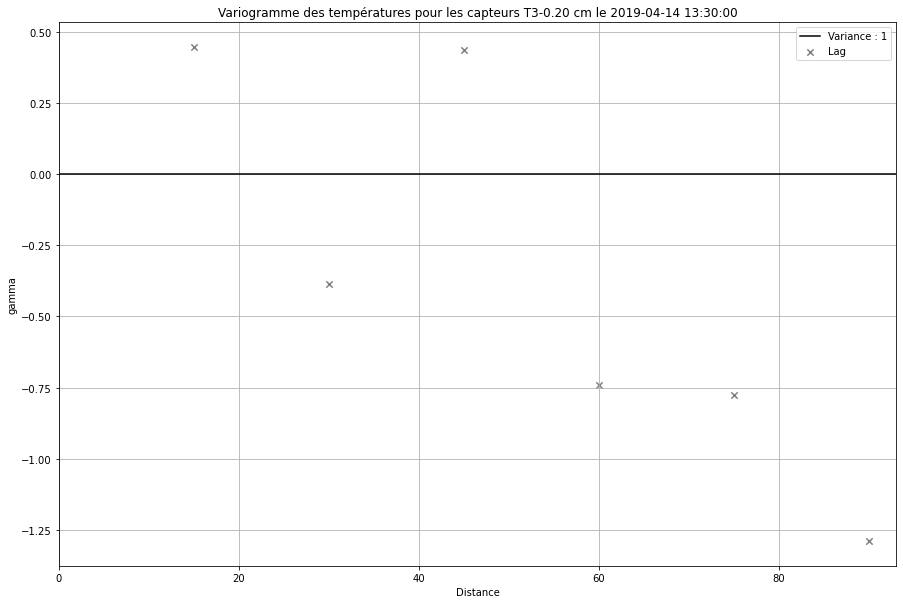

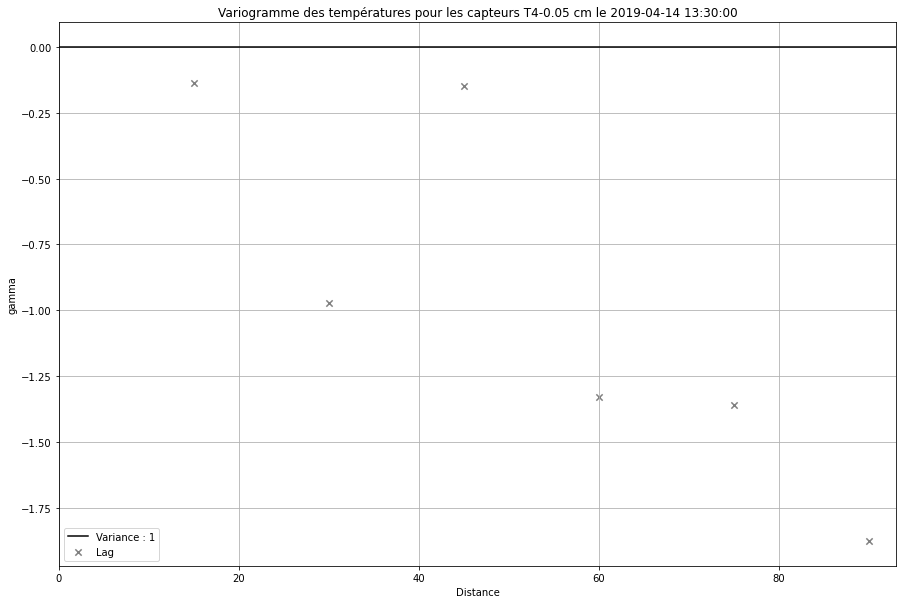

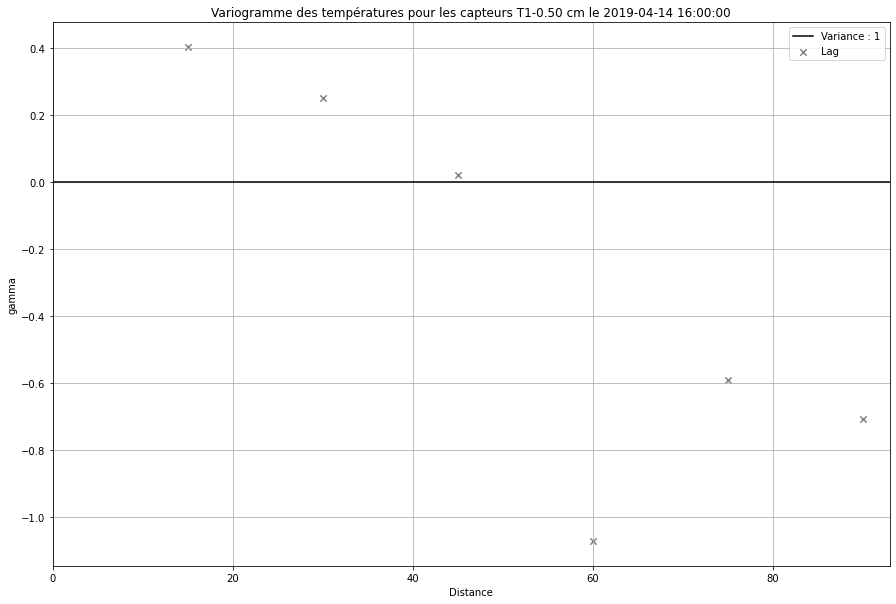

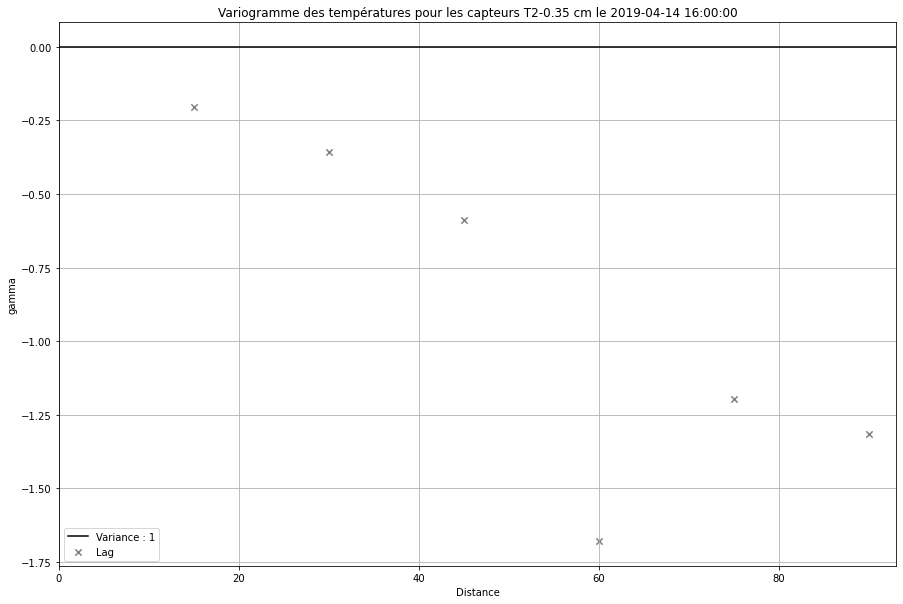

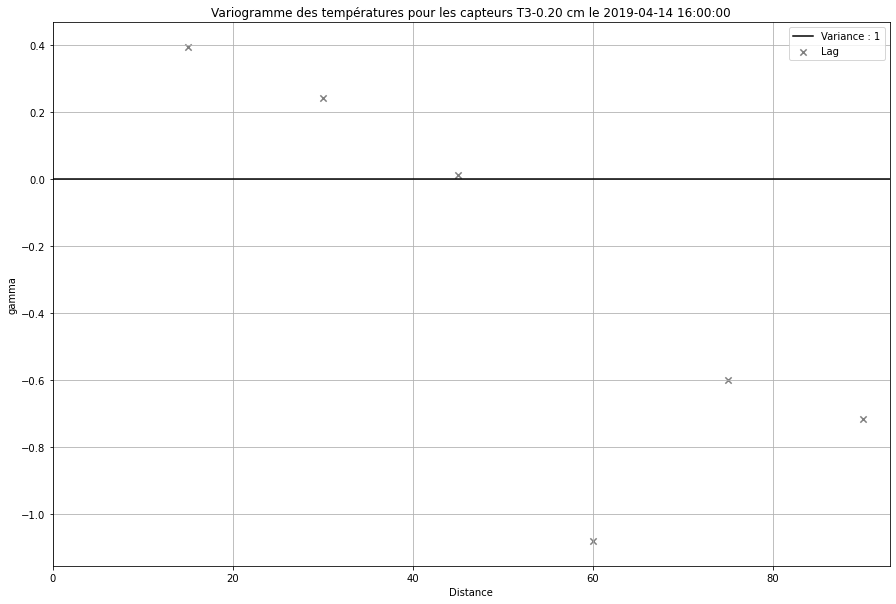

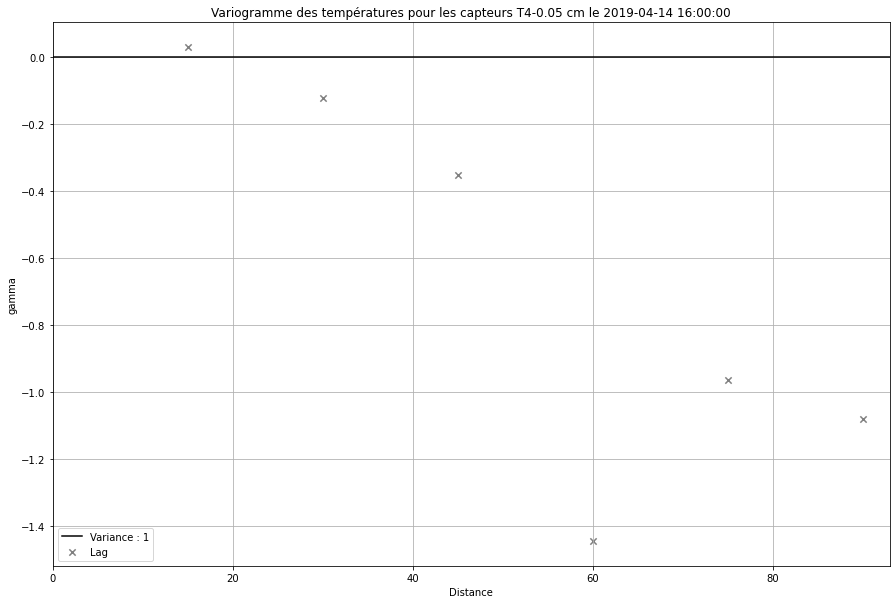

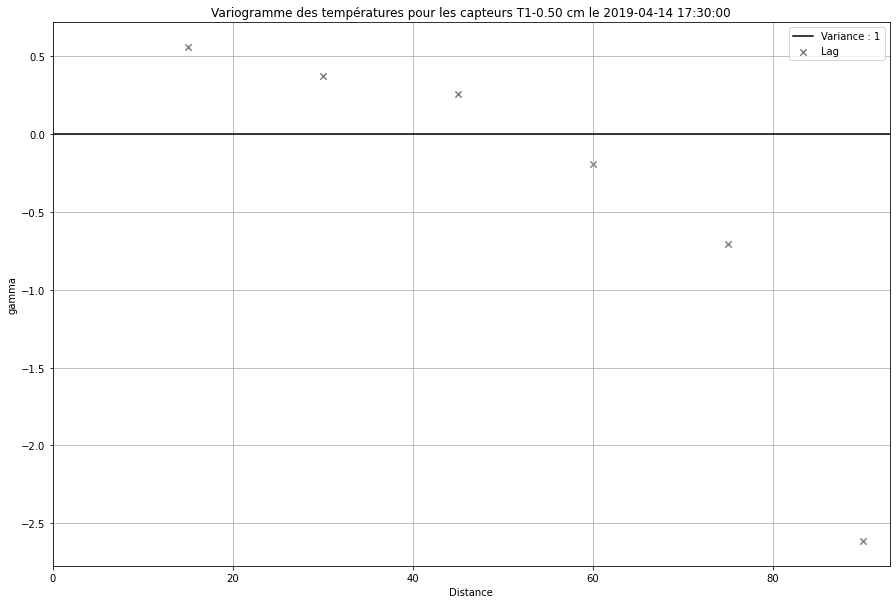

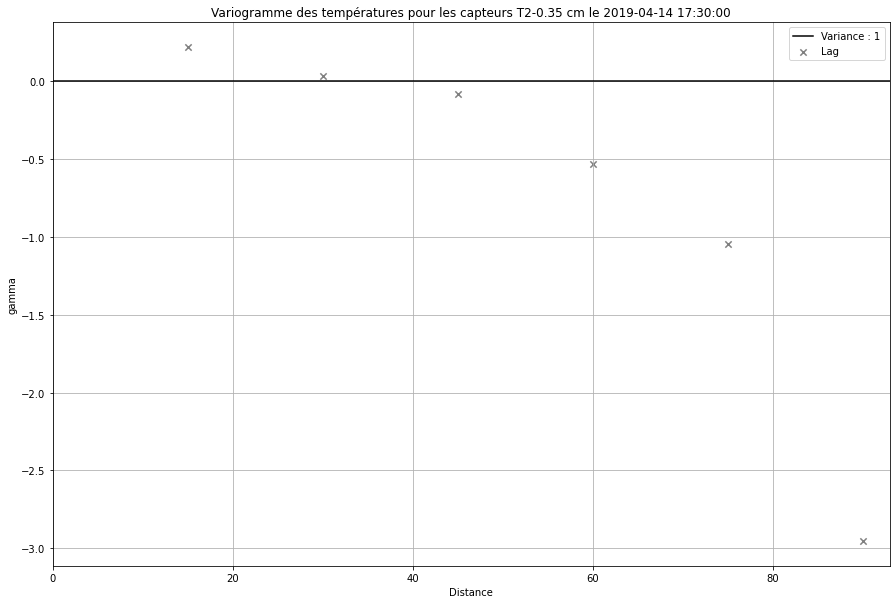

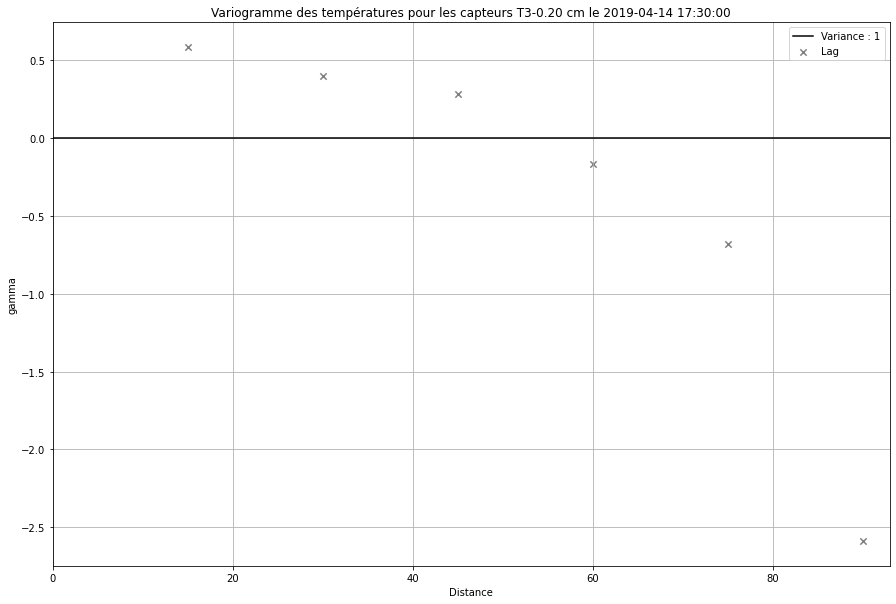

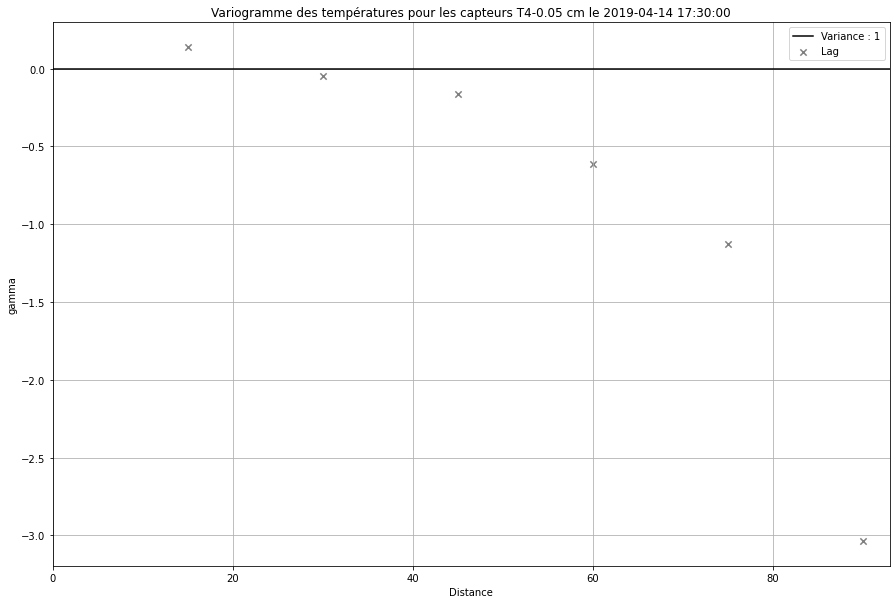

In [93]:
dict_PT_all_temp = np.load("dict_PT_all_temp_labelized_cluster.npy",allow_pickle='TRUE').item()
for REQUESTED_IR in dict_PT_all_temp :
    for TEMP in ["T1","T2","T3","T4"] :
        # Chemin d'accès du package correspondant à l'IR + capteur d'une sonde
        filename = "./varr/Cross_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        Cross_variogram = np.load(filename,allow_pickle='TRUE').item()
        # Timestamp de l'IR pour affichage
        IR_time = dict_PT_all_temp[REQUESTED_IR]['IR_time']
        
        #Coefficient de correlation
        corr = np.corrcoef(Cross_variogram["DataFrame"]["Primary"], Cross_variogram["DataFrame"]["Secondary"])[0, 1]
        #Nombre de pair
        dist_dir = Cross_variogram["Variogram"].loc[Cross_variogram["Variogram"]["Variogram Index"]== 1.0]["Lag Distance"].values
        # Variogram / Correlogram
        gam_dir = corr - Cross_variogram["Variogram"].loc[Cross_variogram["Variogram"]["Variogram Index"]== 1.0]["Variogram Value"].values

        # Une ligne située à la variance = 1
        ones = np.ones(shape=(100)) * 0
        H    = np.arange(0,100)
        
        fig,ax=plt.subplots(1,1,figsize = (15,10))
        LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
        sensor = str(LABEL[int(TEMP[-1])-1])
        ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
        ax.plot(H,ones,"black",label = "Variance : " + str(varr))
        ax.set_xlabel('Distance')
        ax.set_ylabel('gamma')
        ax.grid()
        ax.legend()
        ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
        ax.set_xlim([0,int(L)])


# Test avec des valeurs de Temp à +/- 15 minutes, à améliorer  

In [130]:
def variogram_primary(requested_IR,TEMP,dict_PT_all_temp,IR_time) :
    # Données sondes
    date_1='2019-04-14 06:00:00'
    date_2='2019-04-14 18:30:00'
    dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    Primary_c = reading_gps_file(filename_Sensor_txt)
    Primary_c[TEMP] = 0
    for sensor in dict_temp_sensor :
        value = dict_temp_sensor[sensor][TEMP].loc[dict_temp_sensor[sensor]["Time"] == IR_time]
        Primary_c[TEMP].loc[Primary_c["SensorName"] == sensor] = value.values

    Primary = Primary_c.loc[Primary_c["SensorName"] != "S3-AIR"] 
    Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score

    X = Primary["x"].astype(float).values
    Y = Primary["y"].astype(float).values
    Z = Primary["Primary"].astype(float).values

    ## Distance à retenir
    distance_variable = 0
    for i in range(0,len(X)) :
        for j in range (0,len(X)) :
            x = X[i] - X[j]
            y = Y[i] - Y[j]
            dist_temp = np.sqrt((x)**2+(y)**2) # distance euclidienne
            if dist_temp > distance_variable :
                distance_variable = dist_temp

    ## Calcul du variogram
    L = distance_variable * 2/3
    w =15
    direction = [0]
    angle_tolerance = 90
    dist, counts, gam = {}, {}, {}

    for Dir in direction :
        st1 = timeit.default_timer()
        dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
        st2 = timeit.default_timer()
        print("RUN TIME : {0}".format(st2-st1))

    ## Save
    for direction in [1,2] :
        if direction == 1 :
            index_major = np.ones((1,len(dist[0])))
            dist_major  = dist[0]
            gam_major   = gam[0]
            count_major = counts[0]
        elif direction == 2 :
            index_minor = np.ones((1,len(dist[0]))) * 2
            dist_minor  = dist[0]
            gam_minor   = gam[0]
            count_minor = counts[0]

    index_array = np.append(index_major,index_minor)
    dist_array  = np.append(dist_major,dist_minor)
    gam_array   = np.append(gam_major,gam_minor)
    count_array   = np.append(count_major,count_minor)

    varc_1 = pd.DataFrame()
    varc_1["Lag Distance"] = dist_array
    varc_1["Number of Pairs"] = count_array
    varc_1["Variogram Value"] = gam_array
    varc_1["Variogram Index"] = index_array 

    Primary_variogram = {"DataFrame": Primary ,
                         "Variogram" : varc_1,
                         "sensor" : TEMP,
                         "IR_time" :requested_IR,
                        "Timestamp" : IR_time}

    #filename = "./varr/Primary_variogram/Boucle/"+str(requested_IR)+"_"+str(TEMP)+".npy"
    #np.save(filename,Primary_variogram)
    print("Complited :",requested_IR)
    return Primary_variogram

###  dict_variogram_min_plus : contient les variogram pour une seul profondeur / une seule IR

In [131]:
np.load("dict_PT_all_temp.npy",allow_pickle='TRUE').item().keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [136]:
dict_PT_all_temp = np.load("dict_PT_all_temp.npy",allow_pickle='TRUE').item()
IR = ["IR_8H22"]
requested_TEMP = ["T1"]
dict_variogram_min_plus = {}
Temp_label = ["plus","equal","minus"]
for requested_IR in IR :
    for TEMP in requested_TEMP :
        dict_IR_time_variation = {}
        IR_time_plus  = dict_PT_all_temp[requested_IR]['IR_time'] + pd.Timedelta("15min")
        IR_time_equal = dict_PT_all_temp[requested_IR]['IR_time']
        IR_time_minus = dict_PT_all_temp[requested_IR]['IR_time'] - pd.Timedelta("15min")
        for ii,IR_time in enumerate([IR_time_plus,IR_time_equal,IR_time_minus]) :
            print(requested_IR,TEMP,IR_time)
            Primary_variogram = variogram_primary(requested_IR,TEMP,dict_PT_all_temp,IR_time)
            dict_variogram_min_plus[Temp_label[ii]] = Primary_variogram



IR_8H22 T1 2019-04-14 08:45:00


C:\Users\Alexandre\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-130-8999c88de882>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Primary["Primary"] = (Primary[TEMP]- np.mean(Primary[TEMP].values)) / np.sqrt(np.var(Primary[TEMP].values)) # Normal score


Iteration 0 / 9
RUN TIME : 0.001318300001003081
Complited : IR_8H22
IR_8H22 T1 2019-04-14 08:30:00
Iteration 0 / 9
RUN TIME : 0.0002860000004147878
Complited : IR_8H22
IR_8H22 T1 2019-04-14 08:15:00
Iteration 0 / 9
RUN TIME : 0.0009805999998206971
Complited : IR_8H22


In [142]:
dict_variogram_min_plus["plus"].keys()

dict_keys(['DataFrame', 'Variogram', 'sensor', 'IR_time', 'Timestamp'])

In [74]:
np.load("dict_PT_all_temp.npy",allow_pickle='TRUE').item().keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

2019-04-14 08:45:00 -> Variogram value : [0.         1.22964536 0.08214275 0.94147788 1.86754436 2.31130337]
2019-04-14 08:30:00 -> Variogram value : [0.         1.22721952 0.08309088 0.94172496 1.8711048  2.30906662]
2019-04-14 08:15:00 -> Variogram value : [0.         1.22770145 0.08519752 0.94116277 1.87187643 2.30887216]


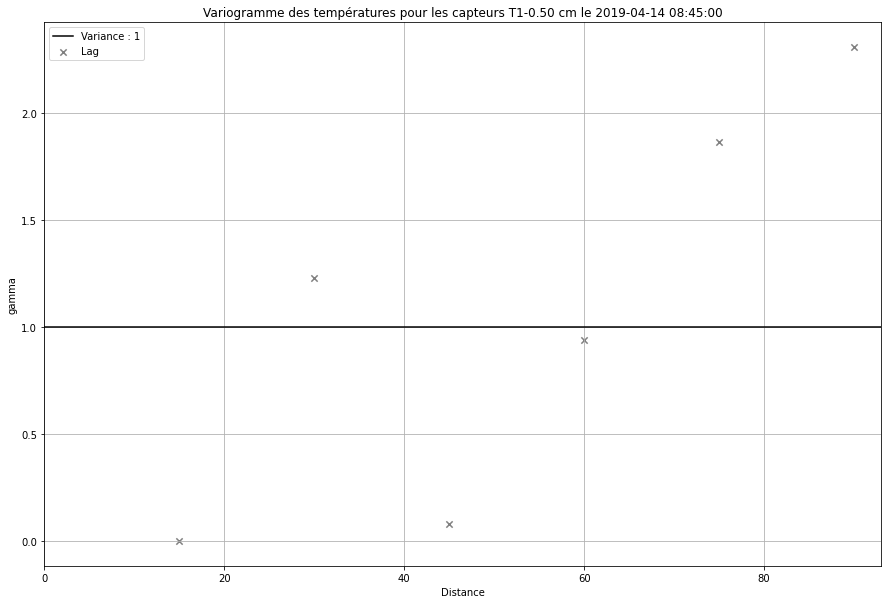

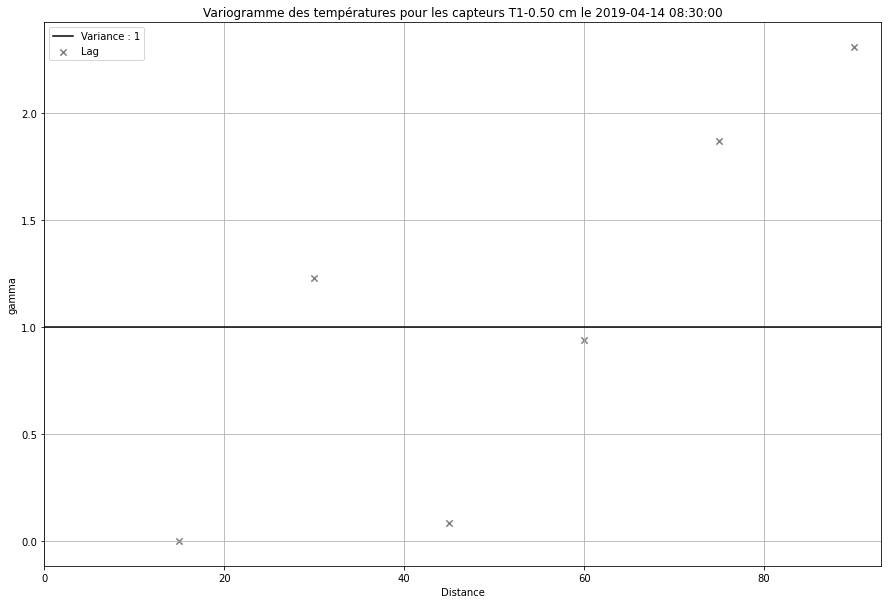

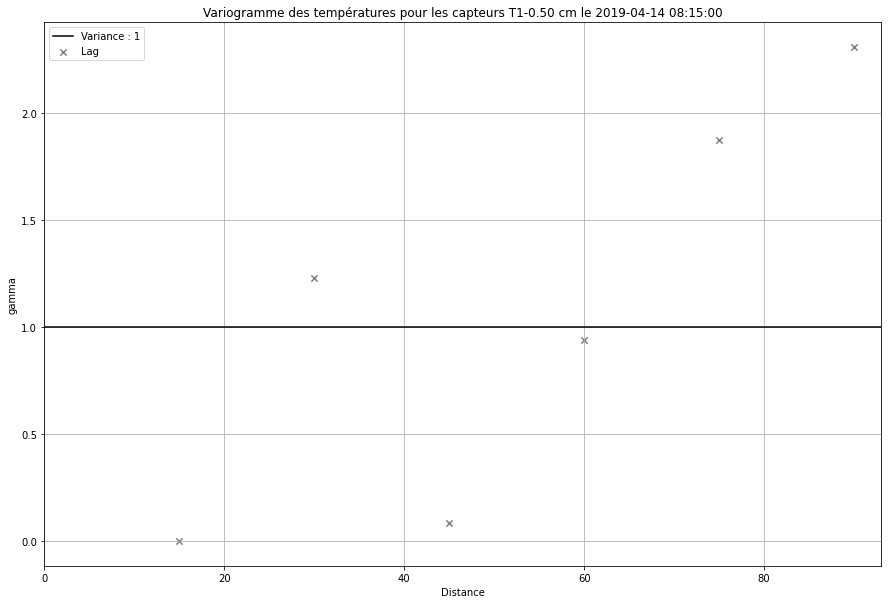

In [144]:
for time_value in dict_variogram_min_plus :
    t = dict_variogram_min_plus[time_value]["Timestamp"]
    Primary_variogram = dict_variogram_min_plus[time_value]["Variogram"]
    gam_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Variogram Value"].values
    print(t,"->","Variogram value :",gam_dir)
for time_value in dict_variogram_min_plus :
    dict_variogram_min_plus[time_value]
    IR_time = dict_variogram_min_plus[time_value]['Timestamp']
    Primary_variogram = dict_variogram_min_plus[time_value]["Variogram"]

    dist_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Lag Distance"].values
    gam_dir = Primary_variogram.loc[Primary_variogram["Variogram Index"]== 1.0]["Variogram Value"].values


    ones = np.ones(shape=(100)) * varr
    H    = np.arange(0,100)
    fig,ax=plt.subplots(1,1,figsize = (15,10))
    LABEL = ['T1-0.50','T2-0.35','T3-0.20','T4-0.05']
    sensor = str(LABEL[int(TEMP[-1])-1])
    ax.scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = "Lag")
    ax.plot(H,ones,"black",label = "Variance : " + str(varr))
    ax.set_xlabel('Distance')
    ax.set_ylabel('gamma')
    ax.grid()
    ax.legend()
    ax.set_title("Variogramme des températures pour les capteurs " + sensor + " cm le " +str(IR_time) )
    ax.set_xlim([0,int(L)])


## Nuée de points Variogramme 

In [327]:
def nuee_variogram(X,Y,Z) :   
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    r = []
    gam_value = []
    for ii in np.arange(0,n):
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            #tht = np.arctan2(y,x) * (180/np.pi)
            r.append(np.sqrt((x)**2+(y)**2))
            gam_value.append((1/2)*(zi-zj)**2)
        
    return r,gam_value

In [584]:
r,gam_value = nuee_variogram(X,Y,Z)

0
1
2
3
4
5
6
7
8


Text(0.5, 1.0, ' Nuage variographique des températures pour les capteurs à 5.0 cm le 14-04-2019 07:00:00  ')

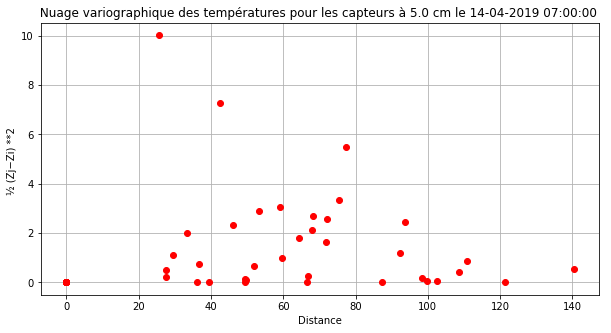

In [586]:
fig,ax=plt.subplots(1,1, figsize = (10,5))
ax.plot(r,gam_value,"ro")
ax.set_xlabel('Distance')
ax.set_ylabel('½ (Zj−Zi) **2 ')
ax.grid()
ax.set_title(" Nuage variographique des températures pour les capteurs à 5.0 cm le 14-04-2019 07:00:00  ")

## Zone de Test

In [2]:
def reading_zzz(filetif,ls_path_tif) :
    dict_IR = {}
    for path_tif in ls_path_tif :
        with rio.open(path_tif) as dataset :
            st1 = timeit.default_timer()

            all_band= dataset.read(1)
            win_transform = dataset.transform
            extent = plotting_extent(all_band,win_transform)
            width  = dataset.width
            height = dataset.height

            x_start = win_transform[2]
            x_res   = win_transform[0]
            x_end   = x_start+(float(x_res)*dataset.width)

            y_end   = win_transform[5]
            y_res   = win_transform[4]
            y_start = y_end + (float(y_res)*dataset.height)

            x = np.linspace(x_start,x_end,num = width)
            x = x[0:-2] # Permet de supprimer la dernière value incorrecte ?  
            y = np.linspace(y_start,y_end,num = height)
            y = y[0:-2] # Permet de supprimer la dernière value incorrecte ? 
            band_1 = []
            x_matrix = []
            y_matrix = []
            for ii in range(len(x)) :
                # Petit timer pour observer l'avancée
                if ii in [len(x)/2,len(x)/3,len(x)/4,len(x)/5,len(x)/6,len(x)/10] : 
                    st2 = timeit.default_timer()
                    # print("ii :", ii ,"RUN TIME : {0}".format(st2-st1))
                    
                for jj in range(len(y)) :
                    for val in dataset.sample([(x[ii],y[jj])]): 
                        band_1.append(float(val))
                        x_matrix.append(x[ii]) # permet de répeter le terme 
                        y_matrix.append(y[jj])
                        mapping = ['x','y','band 1']
                st3 = timeit.default_timer()
                        
        Data_df = pd.DataFrame(np.array([x_matrix,
                                             y_matrix,
                                             band_1],dtype = float).T,
                                   columns=mapping)
            
        Data_df["band 1"] = Data_df["band 1"].replace(1.0,np.NAN)
        Data_df = Data_df.dropna()
        dict_IR[filetif] = Data_df

    return dict_IR

        

In [59]:

S1

array([ 523654.74, 5366287.75])

In [63]:
S1 = Primary.loc[Primary["SensorName"] == "S1"].loc[:,"x" : "y"].astype(float).values[0]
for path_tif in ls_path_tif :
        with rio.open(path_tif) as dataset :
            st1 = timeit.default_timer()

            all_band= dataset.read(1)
            win_transform = dataset.transform
            extent = plotting_extent(all_band,win_transform)
            width  = dataset.width
            height = dataset.height
            print("width :", width)
            print("height :", height)
            print("index :", dataset.index(float(S1[0]),float(S1[1])))
            

width : 3182
height : 4413
index : (1222, 1355)


In [41]:
S1[0]

array(['523654.74', '5366287.75'], dtype=object)

In [ ]:
Secondary = reading_zzz(filetif,ls_path_tif)
Secondary

In [61]:
from rasterio.windows import Window
def reading_1band(LONGUEUR,filetif,ls_path_tif,normalization = True) :
    """ Lit un fichier .tif à 1 band et retourne un patch carré de coté LONGUEUR au format DataFrame [x,y,band 1]
    """
    
    #filename = './traitement_PIREN/vis_piren_phase_HSV.tif'
    #LONGUEUR = 10
    filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
    sensor_coord = reading_gps_file(filename_Sensor_txt)
    dict_IR = {} # va contenir les noms IR + tous les dicts associés à chaque sonde
    
    for m,tif in enumerate(ls_path_tif) : 
        with rio.open(tif) as dataset :
            #Value par défaut
            #win_height = 6303
            #win_width = 3421
            

            ls_index_target = [] # liste des valeurs indexées dans l'image
            win_height = round(LONGUEUR / dataset.res[0])
            win_width  = round(LONGUEUR / dataset.res[1])
            print("Taille de la fenetre :",win_height,"x",win_width)
            print("Résolution ","x:",dataset.res[0],"y:",dataset.res[1])

            # Loop pour recuperer les coordonnées UTM et convertir en indice 
            for k in range(len(sensor_coord["SensorName"])) :
                x = sensor_coord["x"][k] 
                y = sensor_coord["y"][k]
                target = dataset.index(float(x),float(y))
                ls_index_target.append(target)

            dict_windows = {} # liste des paramètres dans la création d'une window
            dict_windows_param = {} # dict des targets : améliore la lisibilité

            for i,index_target in enumerate(ls_index_target) :
                win = Window.from_slices((index_target[0]-(win_height//2),(index_target[0]+(win_height//2))),
                                         (index_target[1]-(win_width//2),(index_target[1]+(win_width//2)))
                                         )
                win_transform = dataset.window_transform(win)
                all_band = dataset.read(1,window = win) # en cas de visualisation

                dict_param = {"win" : win,
                                "win_transform" : win_transform,
                               "all_band" : all_band,
                               "SensorName" : sensor_coord["SensorName"][i],
                             "LONGUEUR" : LONGUEUR,
                             "resolution" : dataset.res}

                dict_windows_param[sensor_coord["SensorName"][i]] = dict_param

                # Vecteurs linéaires avec valeurs uniforméments crées
                x_start = win_transform[2]
                x_res   = win_transform[0]
                x_end   = x_start+(float(x_res)*win.width)

                y_end   = win_transform[5]
                y_res   = win_transform[4]
                y_start = y_end + (float(y_res)*win.height)

                #print("x_end =",x_end)
                #print("y_start =",y_start)

                x = np.linspace(x_start,x_end,num = win.width + 1)
                y = np.linspace(y_start,y_end,num = win.height + 1)

                band_1 = []
                x_matrix = []
                y_matrix = []
                # Loop pour obtenir la valeur de chaque pt pour chaque band
                if normalization == False :
                    for j in range(len(x)) :
                        for l in range(len(y)) :
                            for val in dataset.sample([(x[j],y[l])]): 
                                band_1.append(val[0])
                                x_matrix.append(x[j]) # permet de répeter le terme 
                                y_matrix.append(y[l])
                                mapping = ['x','y','band 1']
                    DATA_WINDOW = pd.DataFrame(np.array([x_matrix,
                                                         y_matrix,
                                                         band_1],dtype = object).T,
                                               columns=mapping)

                else :
                    for j in range(len(x)) :
                        for l in range(len(y)) :
                            for val in dataset.sample([(x[j],y[l])]):
                                print
                                band_1.append(float(val))
                                print("float :",float(val),"val :",val[0])
                                x_matrix.append(x[j]) # permet de répeter le terme 
                                y_matrix.append(y[l])

                    mapping = ['x','y','band 1']
                    DATA_WINDOW = pd.DataFrame(np.array([x_matrix,
                                                         y_matrix,
                                                         band_1],dtype = object).T,
                                               columns=mapping)

                DATA_WINDOW['SensorName'] = sensor_coord["SensorName"][i]

                dict_windows[sensor_coord["SensorName"][i]] = DATA_WINDOW
        dict_IR["IR_"+filetif[m]] = {"dict_windows" : dict_windows,
                                     "dict_windows_param" : dict_windows_param}
        print("complited : ","IR_"+filetif[m])

            
    return dict_IR  

In [63]:
path_tif

'./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif'

In [66]:
with rio.open(path_tif) as dataset :
    win_transform = dataset.transform
    x_start = win_transform[2]
    print('x_start :',x_start)
    x_res   = win_transform[0]
    print("x_res :",x_res)
    x_end   = x_start+(float(x_res)*dataset.width)
    print('x_end :',x_end)

    y_end   = win_transform[5]
    print("y_end :",y_end)
    y_res   = win_transform[4]
    print("y_res :",y_res)
    y_start = y_end + (float(y_res)*dataset.height)
    print("y_start :",y_start)
    
    

x_start : 523582.9770212561
x_res : 0.05292600000000282
x_end : 523751.3875532561
y_end : 5366352.46567382
y_res : -0.052925999999998544
y_start : 5366118.90323582


In [62]:
filetif = ['6H55']
ls_path_tif,filetif = get_tif(filetif)
dict_IR = reading_1band(1,filetif,ls_path_tif)
S10_df = dict_IR["IR_6H55"]['dict_windows']["S10"]

Taille de la fenetre : 19 x 19
Résolution  x: 0.05292600000000282 y: 0.052925999999998544
float : -1.1879499730183203 val : -1.1879499730183203
float : -1.1546756118488748 val : -1.1546756118488748
float : -1.1501434103898347 val : -1.1501434103898347
float : -1.1384248843545177 val : -1.1384248843545177
float : -1.110045920909743 val : -1.110045920909743
float : -1.0637643326992399 val : -1.0637643326992399
float : -0.9768062579437369 val : -0.9768062579437369
float : -0.9545863335902152 val : -0.9545863335902152
float : -0.9879167664620125 val : -0.9879167664620125
float : -1.0660147093982373 val : -1.0660147093982373
float : -1.216116506056097 val : -1.216116506056097
float : -1.3415726862047364 val : -1.3415726862047364
float : -1.4084389131017405 val : -1.4084389131017405
float : -1.491934694144498 val : -1.491934694144498
float : -1.5543702343773684 val : -1.5543702343773684
float : -1.5769848049705932 val : -1.5769848049705932
float : -1.5586572090098803 val : -1.558657209009880

float : -1.3837825806911095 val : -1.3837825806911095
float : -1.4218193292026555 val : -1.4218193292026555
float : -1.4597016648039536 val : -1.4597016648039536
float : -1.5458235973671224 val : -1.5458235973671224
float : -1.565470785756429 val : -1.565470785756429
float : -1.5340006911232025 val : -1.5340006911232025
float : -1.6154423945415497 val : -1.6154423945415497
float : -1.5868143181053114 val : -1.5868143181053114
float : -1.3842171799636054 val : -1.3842171799636054
float : -1.3907222321156407 val : -1.3907222321156407
float : -1.5551075908645988 val : -1.5551075908645988
float : -1.6736843715003882 val : -1.6736843715003882
float : -1.6816659282913897 val : -1.6816659282913897
float : -1.6597137011699166 val : -1.6597137011699166
float : -1.5546467989271795 val : -1.5546467989271795
float : -1.4431412721972001 val : -1.4431412721972001
float : -1.3994873523037792 val : -1.3994873523037792
float : -1.3940452750324923 val : -1.3940452750324923
float : -1.3798145139769067 va

float : -18.910029054210685 val : -18.910029054210685
float : -22.00904543055204 val : -22.00904543055204
float : -20.922714087310688 val : -20.922714087310688
float : -16.920206159836148 val : -16.920206159836148
float : -11.943708167758523 val : -11.943708167758523
float : -8.192499422771613 val : -8.192499422771613
float : -6.048009799376852 val : -6.048009799376852
float : -4.920288165866193 val : -4.920288165866193
float : -3.9979869874010836 val : -3.9979869874010836
float : -3.414842365435855 val : -3.414842365435855
float : -3.178096835837958 val : -3.178096835837958
float : -3.0915514798029786 val : -3.0915514798029786
float : -3.0302278291052405 val : -3.0302278291052405
float : -2.2588400461558225 val : -2.2588400461558225
float : -2.4446373874014755 val : -2.4446373874014755
float : -3.176676928667688 val : -3.176676928667688
float : -4.923326440460695 val : -4.923326440460695
float : -7.877761209754287 val : -7.877761209754287
float : -11.769226993011921 val : -11.76922699

float : -1.216003039726304 val : -1.216003039726304
float : -1.5122155335365157 val : -1.5122155335365157
float : -2.2503036340887586 val : -2.2503036340887586
float : -4.342331741438588 val : -4.342331741438588
float : -4.342331741438588 val : -4.342331741438588
float : -14.19445536964891 val : -14.19445536964891
float : -21.53496756660865 val : -21.53496756660865
float : -27.944419421791224 val : -27.944419421791224
float : -27.944419421791224 val : -27.944419421791224
float : -28.694768474632127 val : -28.694768474632127
float : -23.625709831151443 val : -23.625709831151443
float : -17.039442542470184 val : -17.039442542470184
float : -10.988966658130739 val : -10.988966658130739
float : -10.988966658130739 val : -10.988966658130739
float : -4.483552767904661 val : -4.483552767904661
float : -3.3734171871725804 val : -3.3734171871725804
float : -2.597273888102879 val : -2.597273888102879
float : -2.597273888102879 val : -2.597273888102879
float : -1.4984356567991113 val : -1.4984356

float : -5.930892332957038 val : -5.930892332957038
float : -4.688655871133047 val : -4.688655871133047
float : -4.083260418031627 val : -4.083260418031627
float : -3.108722783408388 val : -3.108722783408388
float : -3.108722783408388 val : -3.108722783408388
float : -2.6910164024200043 val : -2.6910164024200043
float : -2.545914433471345 val : -2.545914433471345
float : -2.73101085549397 val : -2.73101085549397
float : -3.675927277156517 val : -3.675927277156517
float : -4.458960198133669 val : -4.458960198133669
float : -4.458960198133669 val : -4.458960198133669
float : -5.750908559980731 val : -5.750908559980731
float : -7.598805307619285 val : -7.598805307619285
float : -11.989270789987613 val : -11.989270789987613
float : -11.989270789987613 val : -11.989270789987613
float : -13.798711373576202 val : -13.798711373576202
float : -14.520062510721704 val : -14.520062510721704
float : -11.608244471175206 val : -11.608244471175206
float : -8.72075473526964 val : -8.72075473526964
floa

float : -1.0169564637787016 val : -1.0169564637787016
float : -0.9807321820128632 val : -0.9807321820128632
float : -0.852189430583796 val : -0.852189430583796
float : -1.0044567194714948 val : -1.0044567194714948
float : -1.2333780966456496 val : -1.2333780966456496
float : -1.6883332660527666 val : -1.6883332660527666
float : -2.2813350237387544 val : -2.2813350237387544
float : -2.595811179809596 val : -2.595811179809596
float : -2.8167010404848885 val : -2.8167010404848885
float : -2.6721106091361473 val : -2.6721106091361473
float : -2.115076093258124 val : -2.115076093258124
float : -1.8056579536650637 val : -1.8056579536650637
float : -1.8297644575461265 val : -1.8297644575461265
float : -1.7089175550420315 val : -1.7089175550420315
float : -1.5958814597704252 val : -1.5958814597704252
float : -1.4980950680354104 val : -1.4980950680354104
float : -1.3713745203153374 val : -1.3713745203153374
float : -1.2065945913977987 val : -1.2065945913977987
float : -1.1077804653696417 val : 

float : -0.3946524769576122 val : -0.3946524769576122
float : -0.4409069895863398 val : -0.4409069895863398
float : -0.7728923316500871 val : -0.7728923316500871
float : -1.0057386009983134 val : -1.0057386009983134
float : -1.0358954795190787 val : -1.0358954795190787
float : -1.0358954795190787 val : -1.0358954795190787
float : -0.8977263215656233 val : -0.8977263215656233
float : -0.7217292828737221 val : -0.7217292828737221
float : -0.7499077353900168 val : -0.7499077353900168
float : -0.6866897050627867 val : -0.6866897050627867
float : -0.6327763492318997 val : -0.6327763492318997
float : -0.6752568970962882 val : -0.6752568970962882
float : -0.8319914014330532 val : -0.8319914014330532
float : -0.9110144376259616 val : -0.9110144376259616
float : -0.9110144376259616 val : -0.9110144376259616
float : -0.8525601180492618 val : -0.8525601180492618
float : -0.8495941240121341 val : -0.8495941240121341
float : -0.8447058626162526 val : -0.8447058626162526
float : -0.8378585677363553 

float : -0.26771361681792966 val : -0.26771361681792966
float : -0.25500251391888995 val : -0.25500251391888995
float : -0.24939397221026477 val : -0.24939397221026477
float : -0.30832065910005324 val : -0.30832065910005324
float : -0.629216073433619 val : -0.629216073433619
float : -0.629216073433619 val : -0.629216073433619
float : -0.65198562145265 val : -0.65198562145265
float : -0.6141729874425426 val : -0.6141729874425426
float : -0.6860012288657436 val : -0.6860012288657436
float : -0.8949853287899947 val : -0.8949853287899947
float : -0.9657678654304176 val : -0.9657678654304176
float : -1.0234296168437504 val : -1.0234296168437504
float : -0.4095045169397161 val : -0.4095045169397161
float : -0.26314859020605635 val : -0.26314859020605635
float : -0.0777598988993165 val : -0.0777598988993165
float : -0.0777598988993165 val : -0.0777598988993165
float : -0.020631730070077004 val : -0.020631730070077004
float : -0.0054477548243351435 val : -0.0054477548243351435
float : -0.10053

float : -0.8128217812881047 val : -0.8128217812881047
float : -0.6326445773679638 val : -0.6326445773679638
float : -0.5079427299616225 val : -0.5079427299616225
float : -0.5079427299616225 val : -0.5079427299616225
float : -0.3820067915423485 val : -0.3820067915423485
float : -0.28397091854480366 val : -0.28397091854480366
float : -0.21507975604289759 val : -0.21507975604289759
float : -0.21507975604289759 val : -0.21507975604289759
float : -0.16729173917468276 val : -0.16729173917468276
float : -0.24545039615479697 val : -0.24545039615479697
float : -1.3461278752430883 val : -1.3461278752430883
float : -1.323584191505931 val : -1.323584191505931
float : -1.3116372822570304 val : -1.3116372822570304
float : -1.3116372822570304 val : -1.3116372822570304
float : -1.278902858296164 val : -1.278902858296164
float : -1.2212818267137702 val : -1.2212818267137702
float : -1.1319808790780668 val : -1.1319808790780668
float : -1.1319808790780668 val : -1.1319808790780668
float : -1.05205432998

float : -12.802038008267422 val : -12.802038008267422
float : -7.154442757942396 val : -7.154442757942396
float : -3.737709245866478 val : -3.737709245866478
float : -3.737709245866478 val : -3.737709245866478
float : -2.3253678308075303 val : -2.3253678308075303
float : -1.67439721803655 val : -1.67439721803655
float : -0.9759086397087724 val : -0.9759086397087724
float : -0.9514472660146601 val : -0.9514472660146601
float : -0.9429313959916534 val : -0.9429313959916534
float : -0.9429313959916534 val : -0.9429313959916534
float : -1.0876060635498304 val : -1.0876060635498304
float : -1.6451038538805 val : -1.6451038538805
float : -3.234314706111901 val : -3.234314706111901
float : -3.234314706111901 val : -3.234314706111901
float : -6.50842718443301 val : -6.50842718443301
float : -16.474816384846868 val : -16.474816384846868
float : -19.222121695621865 val : -19.222121695621865
float : -18.837878943779977 val : -18.837878943779977
float : -18.837878943779977 val : -18.83787894377997

float : -5.277173849659333 val : -5.277173849659333
float : -3.878457422039025 val : -3.878457422039025
float : -2.785171390275523 val : -2.785171390275523
float : -2.2059450686271305 val : -2.2059450686271305
float : -1.8461637939286002 val : -1.8461637939286002
float : -2.780744488762919 val : -2.780744488762919
float : -3.114259859442145 val : -3.114259859442145
float : -3.348730487229752 val : -3.348730487229752
float : -3.4989983298114593 val : -3.4989983298114593
float : -3.5929691800359693 val : -3.5929691800359693
float : -3.83449633532807 val : -3.83449633532807
float : -4.639046496999166 val : -4.639046496999166
float : -6.213425790669079 val : -6.213425790669079
float : -8.55481230975957 val : -8.55481230975957
float : -11.71910786470335 val : -11.71910786470335
float : -13.93822680356168 val : -13.93822680356168
float : -13.724036437834048 val : -13.724036437834048
float : -10.971585537077978 val : -10.971585537077978
float : -7.467227188098001 val : -7.467227188098001
floa

float : -1.63040825945882 val : -1.63040825945882
float : -1.471658257025246 val : -1.471658257025246
float : -1.3849974425132037 val : -1.3849974425132037
float : -1.428080512437719 val : -1.428080512437719
float : -1.428080512437719 val : -1.428080512437719
float : -1.5653580801799132 val : -1.5653580801799132
float : -1.6676225140862386 val : -1.6676225140862386
float : -1.749070468873248 val : -1.749070468873248
float : -1.749070468873248 val : -1.749070468873248
float : -1.8048816077200533 val : -1.8048816077200533
float : -1.830756164679151 val : -1.830756164679151
float : -1.2564231605284935 val : -1.2564231605284935
float : -1.331157546353488 val : -1.331157546353488
float : -1.358742569918507 val : -1.358742569918507
float : -1.358742569918507 val : -1.358742569918507
float : -1.4095571888772223 val : -1.4095571888772223
float : -1.4572623950290227 val : -1.4572623950290227
float : -1.4826378068852195 val : -1.4826378068852195
float : -1.4826378068852195 val : -1.4826378068852

In [27]:
S10 = Primary.loc[Primary["SensorName"] == "S10"].loc[:,"x" : "y"].astype(float).values[0]

In [53]:
X = S10_df["x"]
Y = S10_df["y"]
Z = S10_df["band 1"]

In [29]:
print("X :",S10[0],"\nY :",S10[1])

X : 523628.71 
Y : 5366296.81


In [30]:
exp  = "x <="+str(S10[0]+0.1)+" &"+" x>="+str(S10[0]-0.1)
exp += " & y <="+str(S10[1]+0.1)+" &"+" y>="+str(S10[1]-0.1)
S10_df.query(exp)

x               y    band 1 SensorName
17669  523628.652159  5366296.734596 -1.587605        S10
17670  523628.652159  5366296.787522 -1.731427        S10
17671  523628.652159  5366296.840448 -1.794954        S10
17672  523628.652159  5366296.893374 -1.817081        S10
17858  523628.705085  5366296.734596 -1.589843        S10
17859  523628.705085  5366296.787522 -1.735925        S10
17860  523628.705085  5366296.840448 -1.850868        S10
17861  523628.705085  5366296.893374 -1.973695        S10
18047  523628.758011  5366296.734596 -1.407567        S10
18048  523628.758011  5366296.787522 -1.627713        S10
18049  523628.758011  5366296.840448 -1.786992        S10
18050  523628.758011  5366296.893374 -1.945565        S10

In [31]:
exp  = "x <="+str(S10[0]+0.1)+" &"+" x>="+str(S10[0]-0.1)
exp += " & y <="+str(S10[1]+0.1)+" &"+" y>="+str(S10[1]-0.1)
S10_df.query(exp)

x               y    band 1 SensorName
17669  523628.652159  5366296.734596 -1.587605        S10
17670  523628.652159  5366296.787522 -1.731427        S10
17671  523628.652159  5366296.840448 -1.794954        S10
17672  523628.652159  5366296.893374 -1.817081        S10
17858  523628.705085  5366296.734596 -1.589843        S10
17859  523628.705085  5366296.787522 -1.735925        S10
17860  523628.705085  5366296.840448 -1.850868        S10
17861  523628.705085  5366296.893374 -1.973695        S10
18047  523628.758011  5366296.734596 -1.407567        S10
18048  523628.758011  5366296.787522 -1.627713        S10
18049  523628.758011  5366296.840448 -1.786992        S10
18050  523628.758011  5366296.893374 -1.945565        S10

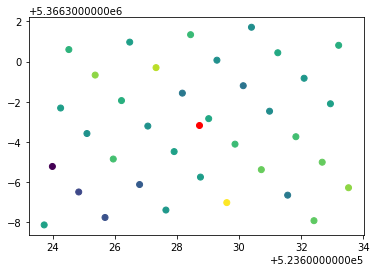

In [54]:
fig,ax = plt.subplots(1) 
ax.scatter(X[::1000],Y[::1000],c = Z[::1000])
ax.scatter(X[len(X)//2],Y[len(Y)//2],c = "red")

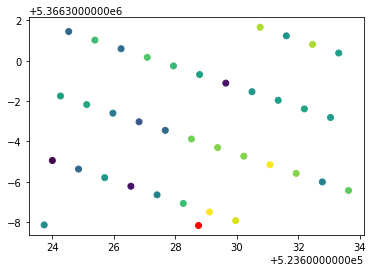

In [49]:
fig,ax = plt.subplots(1) 
ax.scatter(X[::1000],Y[::1000],c = Z[::1000])
ax.scatter(X[len(X)//2],Y[len(Y)//2],c = "red")

In [229]:
X = Secondary_2["x"].astype(float).values
Y = Secondary_2["y"].astype(float).values
Z = Secondary_2["Secondary"].astype(float).values

In [146]:
np.isfinite(Z)


array([ True, False, False, ..., False, False, False])

In [208]:
Z

array([-1.82953205e-01,  1.00000000e+03,  1.00000000e+03, ...,
        1.00000000e+03,  1.00000000e+03,  1.00000000e+03])

In [204]:
print("X :", X.shape)
print("Y :", Y.shape)
print("Z :", Z.shape)

X : (10169506,)
Y : (10169506,)
Z : (10169506,)


In [150]:
Z

array([-0.1829532 ,  0.74685939,  0.74685939, ..., -0.1829532 ,
       -0.1829532 , -0.1829532 ])

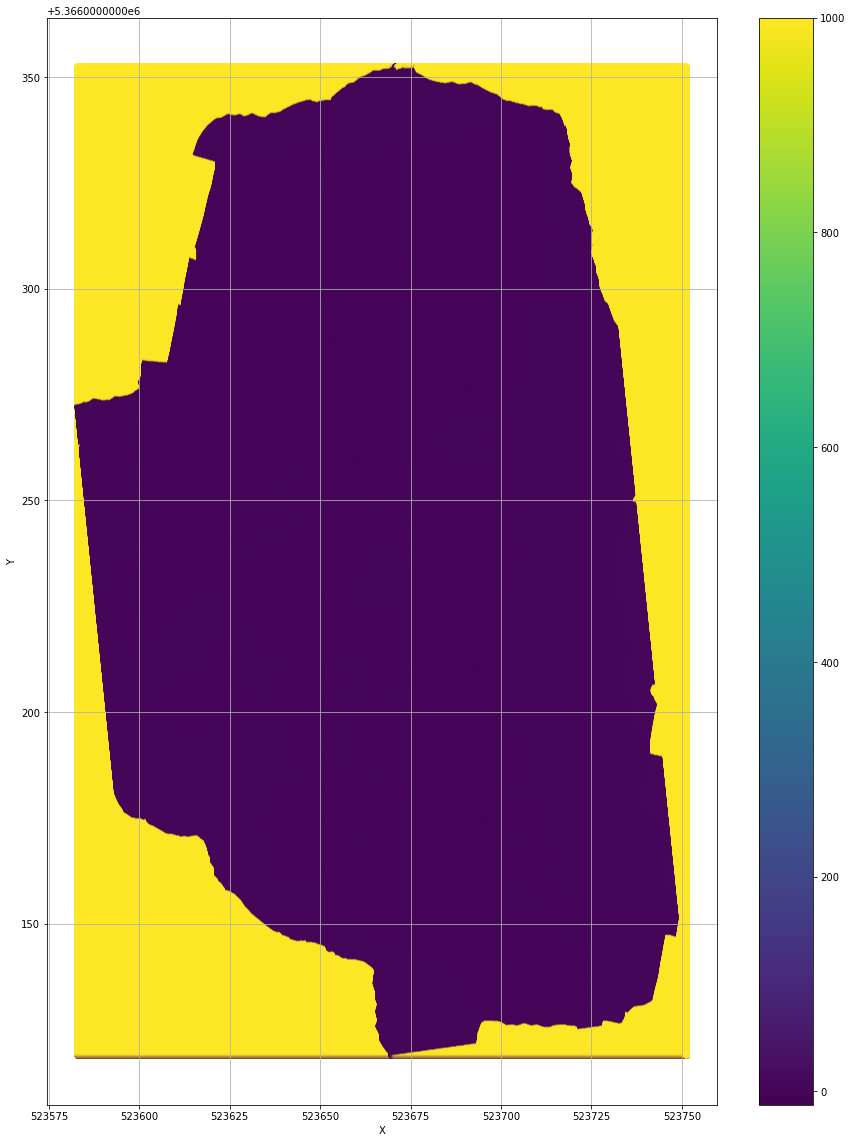

In [209]:
# On check les matrices crées, prend du temps à zaper si on s'en fout
ech = 1
fig,ax=plt.subplots(1,1, figsize = (15,20))
img0 = ax.scatter(X[::ech],Y[::ech],c = Z[::ech])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
fig.colorbar(img0, ax=ax)

In [234]:
X_2 = X[np.isnan(Z)]
Y_2 = Y[np.isnan(Z)]
Z_2 = Z[np.isnan(Z)]
Z_2[np.isnan(Z_2)] = 10

In [236]:
Z_2.shape

(3865066,)

In [195]:
print("X :", X_2.shape)
print("Y :", Y_2.shape)
print("Z :", Z_2.shape)

X : (100000,)
Y : (100000,)
Z : (100000,)


In [189]:
Y_2

array([5366351.56593182, 5366351.61885782, 5366351.67178382, ...,
       5366273.28837782, 5366273.34130382, 5366273.39422982])

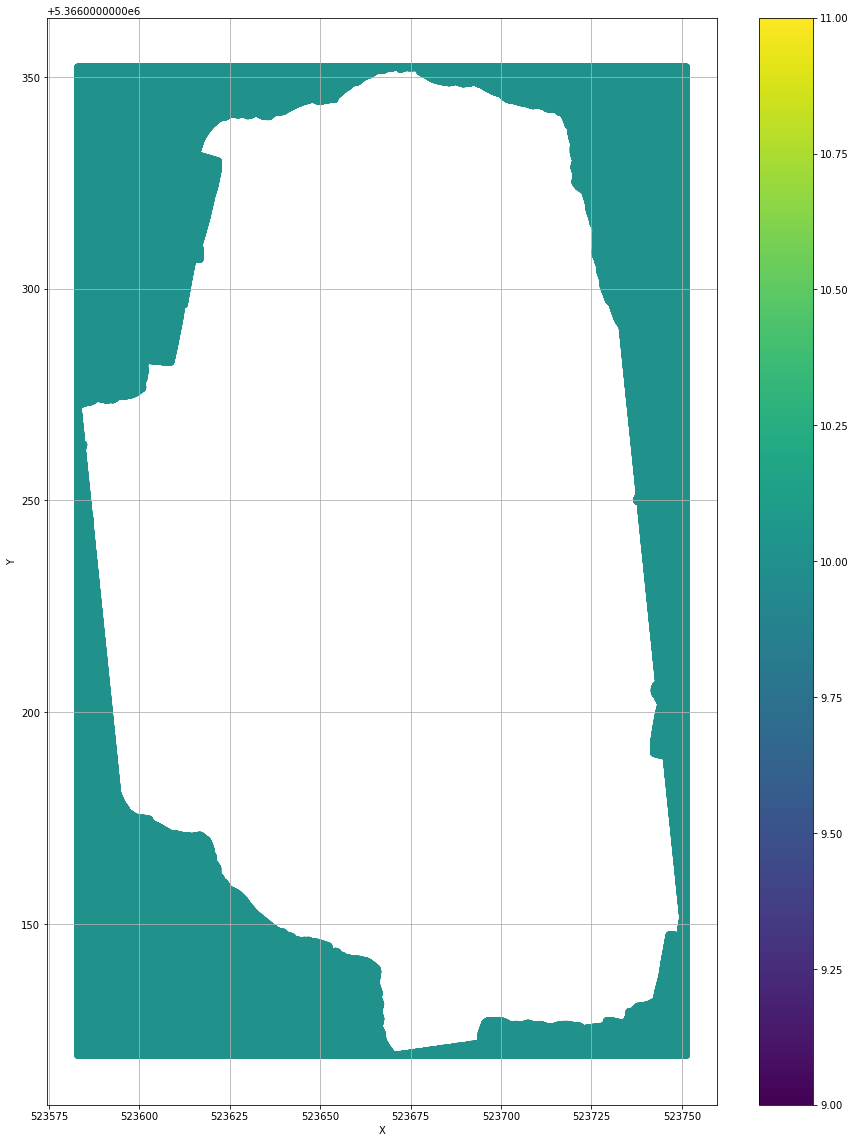

In [237]:
# On check les matrices crées, prend du temps à zaper si on s'en fout
ech = 1
fig,ax=plt.subplots(1,1, figsize = (15,20))
img0 = ax.scatter(X_2[::ech],Y_2[::ech],c = Z_2[::ech])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
fig.colorbar(img0, ax=ax)

In [37]:
ls_path_tif

['./traitement_PIREN/001_6H55_ortho_UTM31N_IR.tif',
 './traitement_PIREN/002_7H29_ortho_UTM31N_IR.tif',
 './traitement_PIREN/003_8H22_ortho_UTM31N_IR.tif',
 './traitement_PIREN/004_9H28_ortho_UTM31N_IR.tif',
 './traitement_PIREN/005_10H22_ortho_UTM31N_IR.tif',
 './traitement_PIREN/006_11H27_ortho_UTM31N_IR.tif',
 './traitement_PIREN/007_12H31_ortho_UTM31N_IR.tif',
 './traitement_PIREN/008_13H26_ortho_UTM31N_IR.tif',
 './traitement_PIREN/009_15H59_ortho_UTM31N_IR.tif',
 './traitement_PIREN/010_17H27_ortho_UTM31N_IR.tif']

In [212]:
dict_IR = {}
for kk,path_tif in enumerate(ls_path_tif) :
    print(filetif[kk])
    with rio.open(path_tif) as dataset :
        all_band= dataset.read(1)
        win_transform = dataset.transform
        extent = plotting_extent(all_band,win_transform)
        width  = dataset.width
        height = dataset.height

        x_start = win_transform[2]
        x_res   = win_transform[0]
        x_end   = x_start+(float(x_res)*dataset.width)

        y_end   = win_transform[5]
        y_res   = win_transform[4]
        y_start = y_end + (float(y_res)*dataset.height)

        x = np.linspace(x_start,x_end,num = width+1)
        #x = x[0:-2] # Permet de supprimer la dernière value incorrecte ?  
        y = np.linspace(y_start,y_end,num = height+1)
        #y = y[0:-2] # Permet de supprimer la dernière value incorrecte ? 
        band_1 = []
        x_matrix = []
        y_matrix = []

6H55


Affine(0.05292600000000282, 0.0, 523582.9770212561,
       0.0, -0.052925999999998544, 5366352.46567382)

In [63]:
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_df = reading_gps_file(filename_Sensor_txt)
Sensor_df = Sensor_df.loc[Sensor_df["SensorName"] != "S3-AIR"]

In [65]:
ls_path_tif

['./traitement_PIREN/005_10H22_ortho_UTM31N_IR.tif']

In [48]:
filetif

['10H22']

In [58]:
Sensor_df["x"].iloc[0]

'523628.71'

In [83]:
for kk,path_tif in enumerate(ls_path_tif) :
    with rio.open(path_tif) as dataset :
        win_transform = dataset.transform
        x_start = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["x"].values.astype(float)[0]
        x_res   = win_transform[0]
        x_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["x"].values.astype(float)[0]
        width   = int(np.absolute(x_end - x_start) / x_res) + 1

        y_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["y"].values.astype(float)[0]
        y_res   = win_transform[4]
        y_start = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["y"].values.astype(float)[0]
        height  = int(np.absolute(y_end - y_start) / np.absolute(y_res)) + 1
        x = np.linspace(x_start,x_end,num = width)
        #x = x[0:-2] # Permet de supprimer la dernière value incorrecte ?  
        y = np.linspace(y_start,y_end,num = height)
        #y = y[0:-2] # Permet de supprimer la dernière value incorrecte ? 
        

In [88]:
def reading_IR_only_sensor(filetif,ls_path_tif,Sensor_df,ech = 1000) :
    """
    filetif : nom de l'IR en cas de dictionnaire
    ls_path_tif : chemin d'accès du fichier .tif
    ech : echantillonage
    Cette fonction calcul un DataFrame selon l'espace convexe associé aux limites des sondes
    """
    dict_IR = {}
    for kk,path_tif in enumerate(ls_path_tif) :
        print(filetif[kk])
        with rio.open(path_tif) as dataset :
            win_transform = dataset.transform
            x_start = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["x"].values.astype(float)[0]
            x_res   = win_transform[0]
            x_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["x"].values.astype(float)[0]
            width   = int(np.absolute(x_end - x_start) / x_res) + 1

            y_end   = Sensor_df.loc[Sensor_df["SensorName"] == "S10"]["y"].values.astype(float)[0]
            y_res   = win_transform[4]
            y_start = Sensor_df.loc[Sensor_df["SensorName"] == "S7"]["y"].values.astype(float)[0]
            height  = int(np.absolute(y_end - y_start) / np.absolute(y_res)) + 1
            x = np.linspace(x_start,x_end,num = width)
            #x = x[0:-2] # Permet de supprimer la dernière value incorrecte ?  
            y = np.linspace(y_start,y_end,num = height)
            #y = y[0:-2] # Permet de supprimer la dernière value incorrecte ? 
            band_1 = []
            x_matrix = []
            y_matrix = []
            count = 0
            for ii in range(len(x)) :        
                for jj in range(len(y)) :
                    count +=1
                    if count == ech :
                        for val in dataset.sample([(x[ii],y[jj])]):
                            #print("ii :",ii,"jj :",jj,"count :",count)
                            band_1.append(float(val))
                            x_matrix.append(x[ii]) 
                            y_matrix.append(y[jj])
                        count = 0
                        
        mapping = ['X','Y','band 1']            
        Data_df = pd.DataFrame(np.array([x_matrix,
                                             y_matrix,
                                             band_1],dtype = float).T,
                                   columns=mapping)
            
        Data_df["band 1"] = Data_df["band 1"].replace(1.0,np.NAN)
        #Data_df = Data_df.dropna()
        # Transformation Normal Score
        Data_df["Secondary"] = (Data_df["band 1"] - Data_df["band 1"].mean())/Data_df["band 1"].std()
        dict_IR["IR_"+filetif[kk]] = {"Secondary" : Data_df,
                                     "echantillonage" : ech}

    return dict_IR

        

In [89]:
Condition = True 
if Condition :
    echantillonage = 100
    filetif = ['6H55', '7H29', '8H22', '9H28', '10H22', '11H27', '12H31', '13H26', '15H59', '17H27']
    ls_path_tif,filetif = get_tif(filetif)
    dict_IR_convex_space = reading_IR_only_sensor(filetif,ls_path_tif,Sensor_df,echantillonage)

6H55
7H29
8H22
9H28
10H22
11H27
12H31
13H26
15H59
17H27


In [91]:
requested_IR = ["IR_10H22"]
filetif = [requested_IR[0][requested_IR[0].find("_")+1::]]
ls_path_tif,filetif = get_tif(filetif)

for IR in requested_IR :
    Secondary_convex = dict_IR_convex_space[IR]["Secondary"]
    echantillonage_convex = dict_IR_convex_space[IR]["echantillonage"]

In [94]:
X = Secondary_convex["X"].astype(float).values
Y = Secondary_convex["Y"].astype(float).values
Z = Secondary_convex["Secondary"].astype(float).values

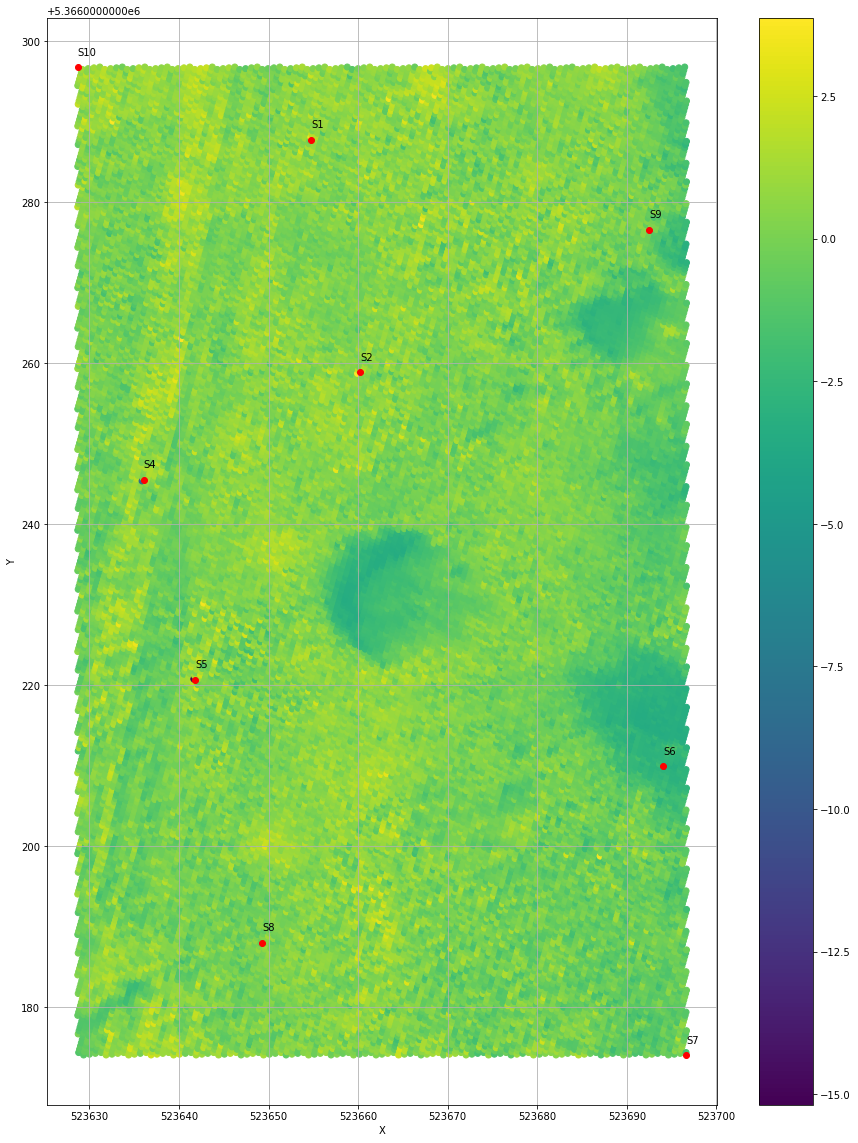

In [97]:
# On check les matrices crées, prend du temps à zaper si on s'en fout
ech = 1
fig,ax=plt.subplots(1,1, figsize = (15,20))
img0 = ax.scatter(X[::ech],Y[::ech],c = Z[::ech])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
fig.colorbar(img0, ax=ax)

Target_x = np.array(Sensor_df["x"],dtype = float)
Target_y = np.array(Sensor_df["y"],dtype = float)
Sensor_Name = np.array(Sensor_df["SensorName"],dtype = str)

plt.plot(Target_x,Target_y,"ro")
for k in range(len(Target_x)) :
    plt.text(Target_x[k],Target_y[k]+1.5,Sensor_Name[k])


# ANNEXE 


In [97]:
INDICE = 2 # Permet de choisir une valeur
Dir    = 45  # Direction en degrée 
angle_tolerance = 360
index_dict = direction_angle_test(X,Y,Z,INDICE,w,L,Dir,angle_tolerance)

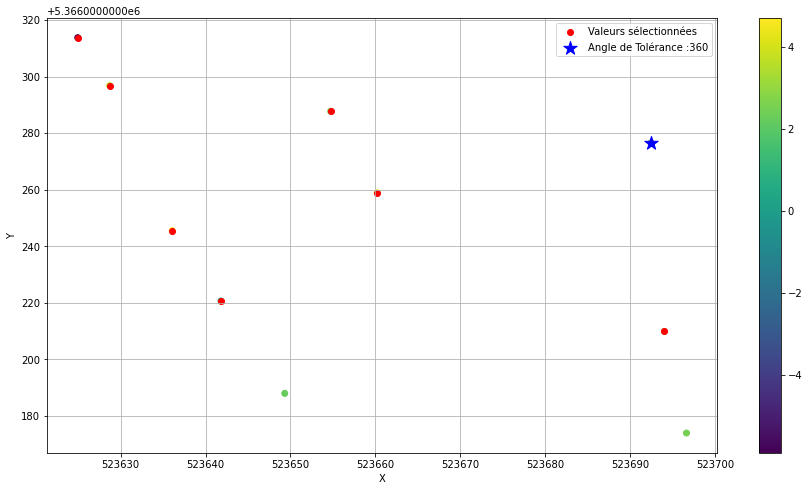

In [114]:
index = index_dict[INDICE]
LABEL = str("Angle de Tolérance :" + str(angle_tolerance) )

fig,ax=plt.subplots(1,1, figsize = (15,8))
img0 = ax.scatter(X,Y,c = Z)
X_value,Y_value = [],[]
for ii in index :
    X_value.append(X[ii])
    Y_value.append(Y[ii])

ax.scatter(X_value,Y_value,c = 'r', label = "Valeurs sélectionnées")
ax.scatter(X[INDICE],Y[INDICE],c = 'blue',marker = '*', s = 200,label = LABEL)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
fig.colorbar(img0, ax=ax)

In [7]:
np.random.standard_normal(10)

array([ 3.02436846e-01,  2.17140973e-01,  2.13335776e+00,  3.69762723e-01,
       -2.81815167e+00,  8.63008793e-01,  1.83364859e-02, -5.84324081e-01,
        2.64332248e-03,  3.95775597e-01])

In [14]:
dict_test_lol = {}
for ii in np.arange(0,10) :
    df = pd.DataFrame(np.array([np.random.standard_normal(1000),np.random.standard_normal(1000)]).T)
    dict_test_lol[ii] = df

In [13]:
dict_test_lol[0]

0         1
0   -1.683744 -2.118143
1   -0.286304 -0.523057
2    1.620011  1.107821
3   -1.351070  0.115966
4    1.508598 -1.855181
..        ...       ...
995  1.298198 -1.331380
996  1.522677 -1.399635
997 -0.980201 -1.145522
998  0.137639 -0.249064
999  0.175336  0.368502

[1000 rows x 2 columns]

In [15]:
np.save('my_file.npy', dict_test_lol) 

In [16]:
read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()

In [26]:
direction = [0,45,90,135]
print("Direction à effectuer :",*direction)

Direction à effectuer : 0 45 90 135


## On test les fonctions de variogramme pour observer les différences

In [38]:
def Variogram(X,Y,Z,width,leng):
# Creates a variogram from the data X, Y, Z, with width of lag interval, max
# length for the variogram, normalement c'est 1/2 la distance max ici c'est 2/3
# function [dist,gamma]=Variogram(X,Y,Z,width,leng)
# exit data: dist and gamma 
    n=len(X)
    if(len(Y)!=n):
        print('X and Y must be the same length')
    elif (len(Z)!=n):
        print('X and Z must be the same length')
    else:  
        print('Allgood')

    nlag=np.int(np.fix(leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    for ii in np.arange(0,n):
        for jj in np.arange(ii,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            dis=np.sqrt((xi-xj)**2+(yi-yj)**2) # distance euclidienne
            if(dis<leng):
                index=np.int(np.fix(dis/width))  # chaque distance/width est associée à un index,
                # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                ###C'est pas justement la tolérance qu'on cherche ?
                dev[index]=dev[index]+(zi-zj)**2 # 
                
                counts[index]=counts[index]+1
    gam=np.divide(dev,2*counts)
    return dist,gam,dev


In [313]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # 25, nombre de lag généré, fiw : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
    
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45
    
    for ii in np.arange(0,n):
        if ii % 100 == 0 :
            print("Iteration",ii,"/",n)
        for jj in np.arange(0,n): # 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                # Ajout de la directionalité 
                
                if (direction + theta_tolerance) < 360 and (direction - theta_tolerance) > 0  :
                    if ((tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance))) or ((tht >= (direction - theta_tolerance)+180) and (tht <= (direction + theta_tolerance)+180)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un index,
                    # permet de regrouper les valeurs entre elles (paires), ex : distance/width = 2.9-> 2, etc etc
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
        
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam

##### Fonction compilée

In [47]:
direction = [0,45,90,135]
angle_tolerance = 22.5

dist, counts, gam = {}, {}, {}
st1 = timeit.default_timer()

for Dir in direction :   
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiledv2(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
st2 = timeit.default_timer()
print("RUN TIME : {0}".format(st2-st1))

direction done : 0
direction done : 45
direction done : 90
direction done : 135
RUN TIME : 0.07817590000013297


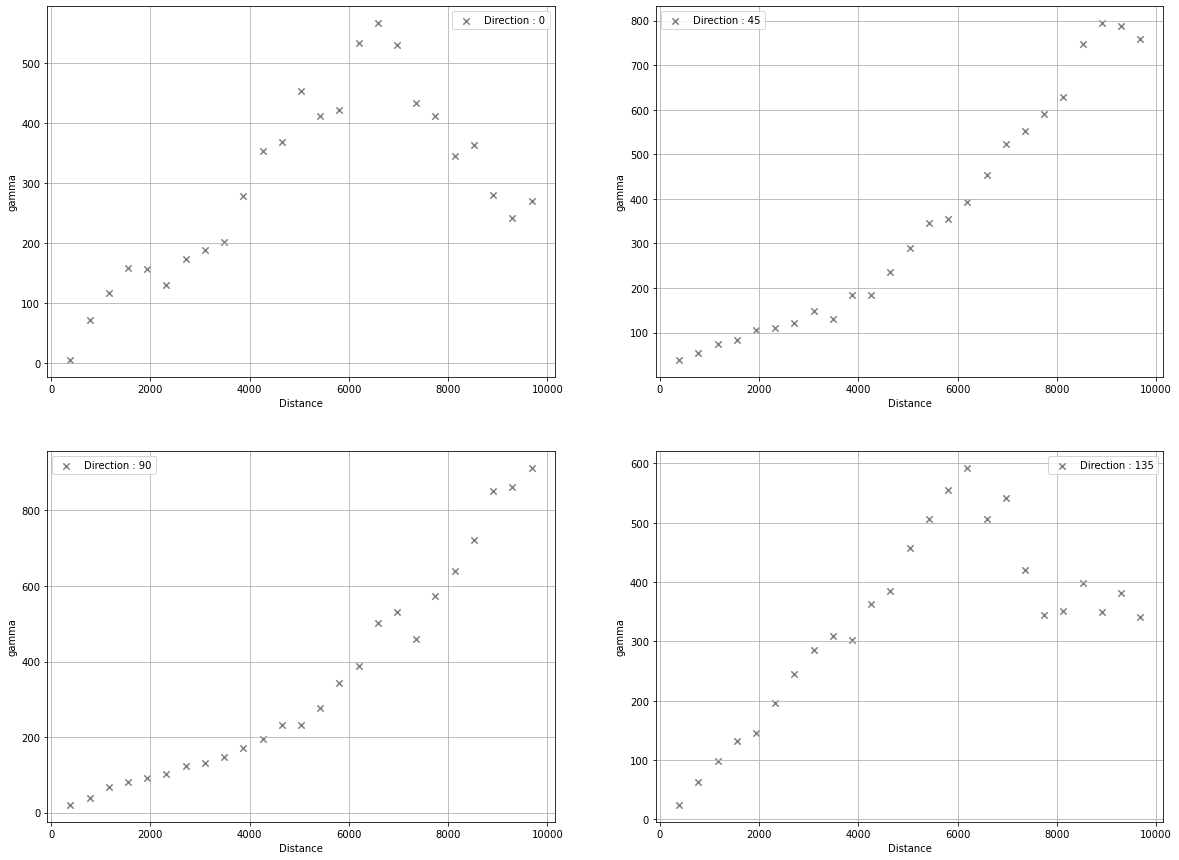

In [48]:
plt.close('all')
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    #ax[ii,jj].set_ylim([0,1])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

##### Fonction DataFrame

In [44]:
data=pd.read_csv('PlancoetContact2.txt',header=0,delimiter='\t',names=['X','Y','Z'])
data.head()
X=data.X.tolist()
Y=data.Y.tolist()
Z=data.Z.tolist()
L=(max(X)-min(X))*2/3;
w=L/25; #25 : nombre de points

direction = [0,45,90,135]
angle_tolerance = 22.5
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

<ipython-input-20-16c5ce9f0a07>:52: RuntimeWarning: invalid value encountered in true_divide
  gam = np.divide(dev,2*counts)


direction done : 0
RUN TIME : 78.55175950000012


<ipython-input-20-16c5ce9f0a07>:52: RuntimeWarning: invalid value encountered in true_divide
  gam = np.divide(dev,2*counts)


direction done : 45
RUN TIME : 77.6028623000002


<ipython-input-20-16c5ce9f0a07>:52: RuntimeWarning: invalid value encountered in true_divide
  gam = np.divide(dev,2*counts)


direction done : 90
RUN TIME : 72.73449530000016
direction done : 135
RUN TIME : 72.5135852000003


<ipython-input-20-16c5ce9f0a07>:52: RuntimeWarning: invalid value encountered in true_divide
  gam = np.divide(dev,2*counts)


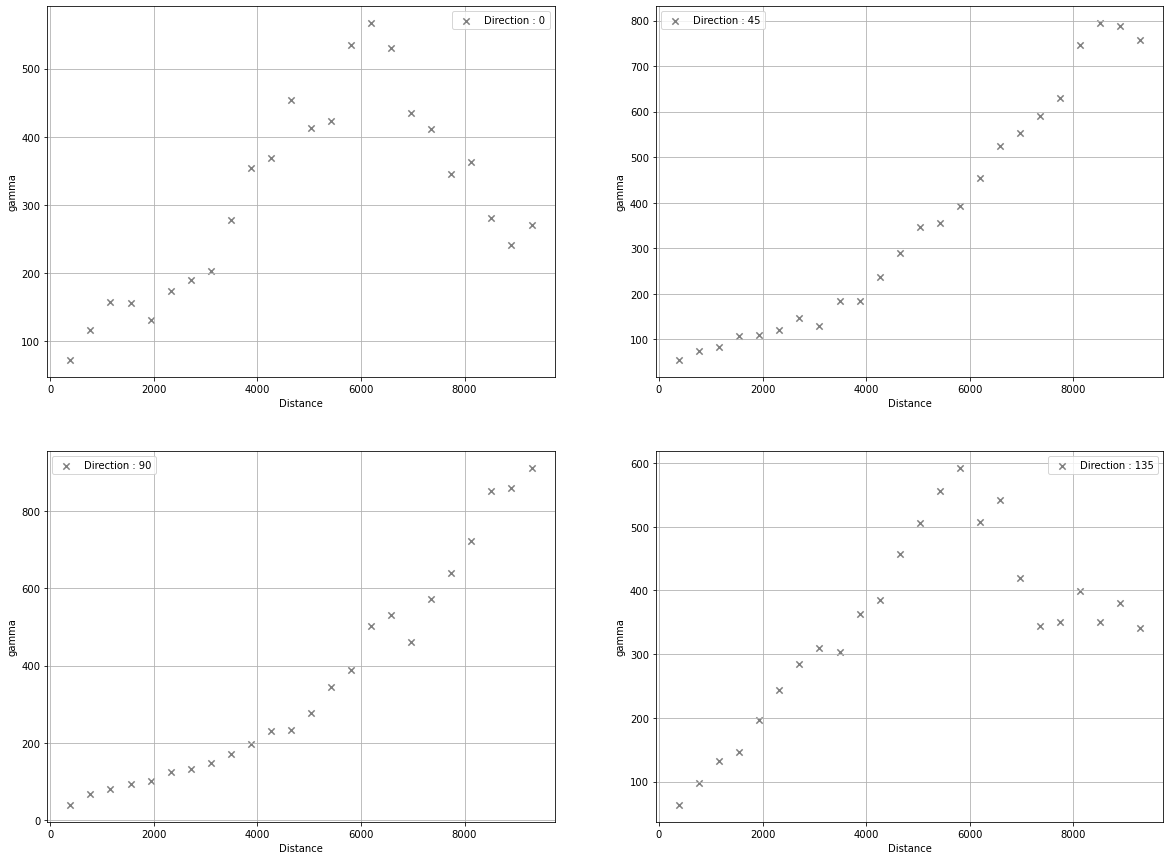

In [45]:
plt.close('all')
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    #ax[ii,jj].set_ylim([0,1])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

##### Fonction initiale

In [40]:
data=pd.read_csv('PlancoetContact2.txt',header=0,delimiter='\t',names=['X','Y','Z'])
data.head()
X=data.X.tolist()
Y=data.Y.tolist()
Z=data.Z.tolist()
L=(max(X)-min(X))*2/3;
w=L/25; #25 : nombre de points

direction = [0,45,90,135]
angle_tolerance = 22.5
dist, gam, dev = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], gam[Dir], dev[Dir] = Variogram(X,Y,Z,w,L)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

Allgood
direction done : 0
RUN TIME : 2.6903830000001108
Allgood
direction done : 45
RUN TIME : 2.518560499999694
Allgood
direction done : 90
RUN TIME : 2.496902599999885
Allgood
direction done : 135
RUN TIME : 2.4678268000006938


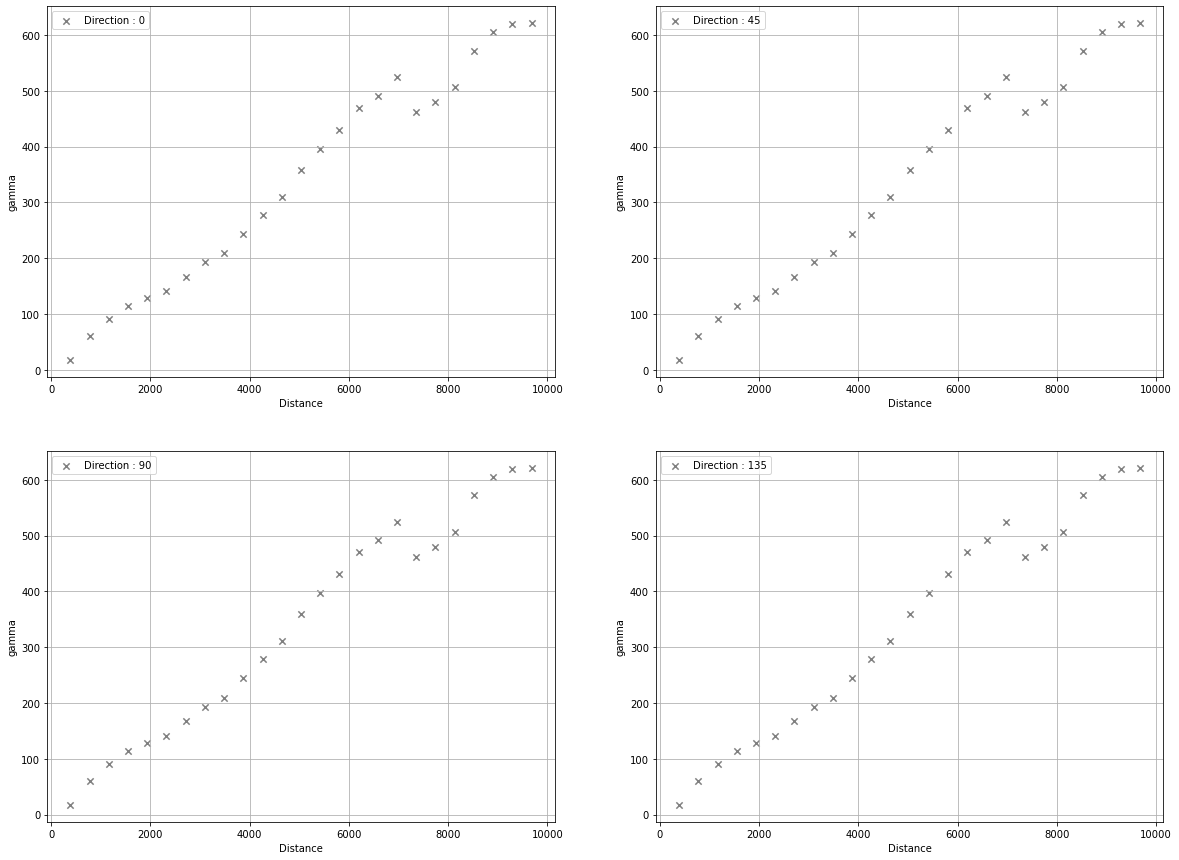

In [41]:
plt.close('all')
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    #ax[ii,jj].set_ylim([0,1])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

## Test sur la variable Primaire (Z)

In [137]:
direction = [0,45,90,135]
angle_tolerance = 360
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

direction done : 0
RUN TIME : 0.7286017000005813
direction done : 45
RUN TIME : 0.7177237000014429
direction done : 90
RUN TIME : 0.6412694999999076
direction done : 135
RUN TIME : 0.6809041000014986


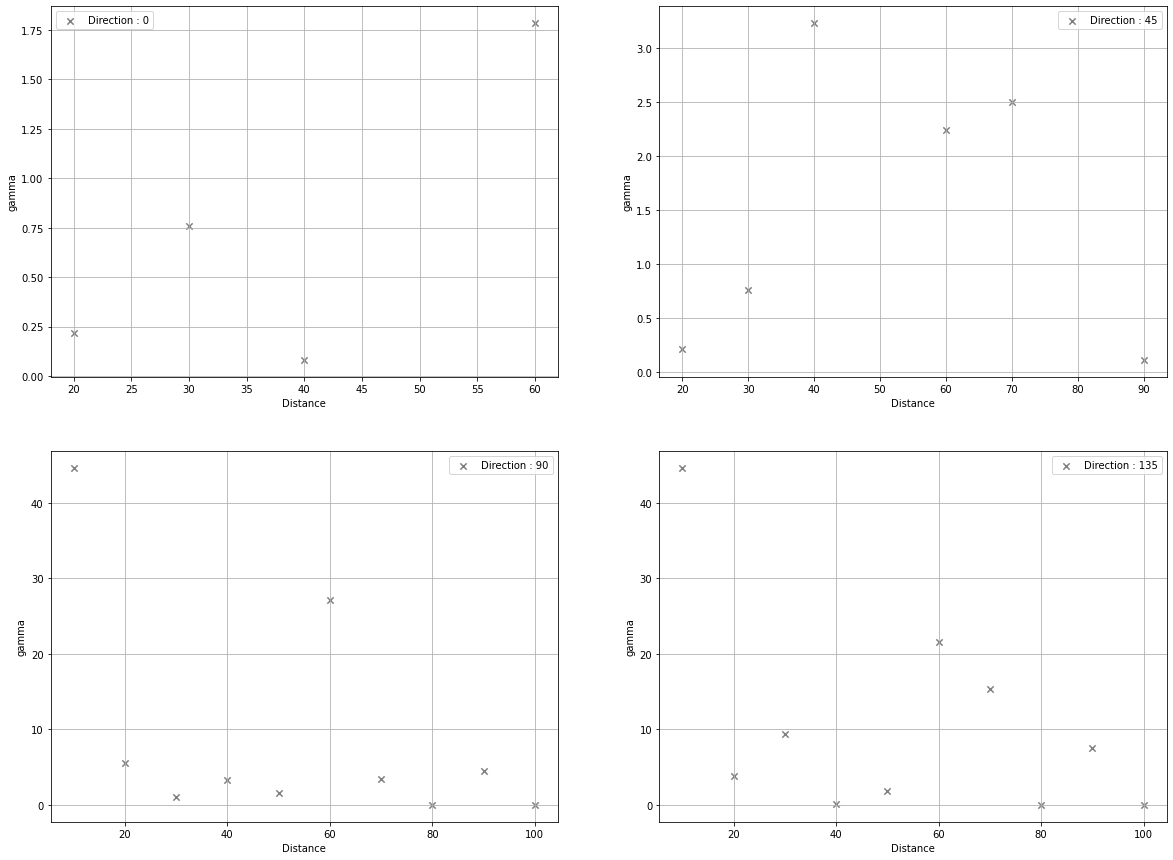

In [134]:
plt.close('all')
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    #ax[ii,jj].set_ylim([0,1])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [167]:
INDICE = 2 # Permet de choisir une valeur
Dir    = 45  # Direction en degrée 
angle_tolerance = 360
value_df,selected_value = direction_angle_testv2(X,Y,Z,INDICE,w,L,Dir,angle_tolerance)

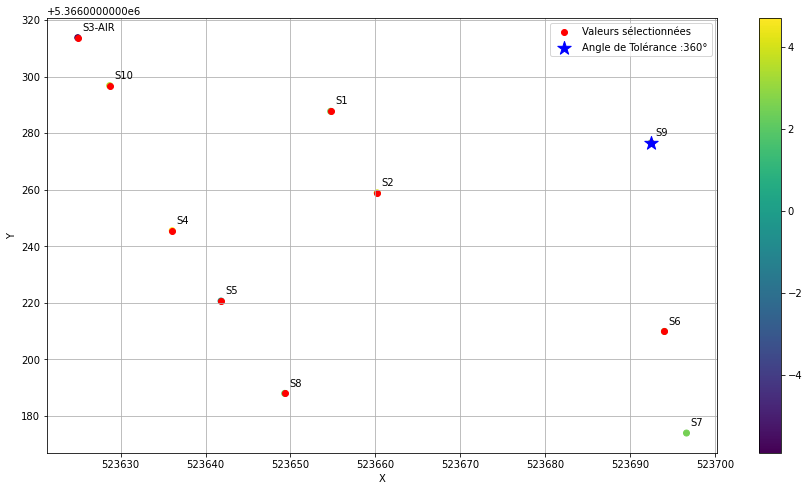

In [156]:
index = index_dict[INDICE]
LABEL = str("Angle de Tolérance :" + str(angle_tolerance) + "°" )

Target_x = np.array(Primary["x"],dtype = float)
Target_y = np.array(Primary["y"],dtype = float)
Sensor_Name = np.array(Primary["SensorName"],dtype = str)

fig,ax=plt.subplots(1,1, figsize = (15,8))
img0 = ax.scatter(X,Y,c = Z)
X_value,Y_value = [],[]
for ii in index :
    X_value.append(X[ii])
    Y_value.append(Y[ii])

ax.scatter(X_value,Y_value,c = 'r', label = "Valeurs sélectionnées")
ax.scatter(X[INDICE],Y[INDICE],c = 'blue',marker = '*', s = 200,label = LABEL)

for k in range(len(Target_x)) :
    plt.text(Target_x[k]+0.5,Target_y[k]+2.5,Sensor_Name[k])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
fig.colorbar(img0, ax=ax)

In [609]:
#low_secondary = pd.read_csv('./varr/low_secondary.csv',header = 0 ,names=['X','Y','Secondary'])
Secondary = pd.read_csv('Secondary.csv',header = 0 ,names=['X','Y','Secondary'])


In [610]:
Secondary["NS_Secondary"] = (Secondary["Secondary"]- np.mean(Secondary["Secondary"].values)) / np.sqrt(np.var(Secondary["Secondary"].values)) # Normal score

In [613]:
np.var(Secondary["NS_Secondary"].values)

1.000000000000001

In [614]:
# Création d'une colonne Secondary avec l'echantillonage de la Primary Variable
sec_value = []
for i in np.arange(0,len(Primary)) :
    
    exp = "X >=" + str(Primary["X"].iloc[i]-0.05) + "& X <=" + str(Primary["X"].iloc[i]+0.05)
    exp += "& Y >=" + str(Primary["Y"].iloc[i]-0.05) + "& Y <=" + str(Primary["Y"].iloc[i]+0.05)
    sec_value.append(Secondary.query(exp)["NS_Secondary"].mean())

Primary["Secondary"] = sec_value


In [616]:
Primary

SensorName            X      Y        T4    Primary  Secondary
S10  523628.710  5366296.810  3.543  0.617270  -0.928996        NaN
S1   523654.740  5366287.750  2.552 -0.212111  -7.901996        NaN
S9   523692.470  5366276.570  2.815  0.007997 -12.268687        NaN
S2   523660.220  5366258.910  4.046  1.038238 -11.832696        NaN
S4   523636.075  5366245.545  4.704  1.588927  -2.546996        NaN
S5   523641.825  5366220.670  0.228 -2.157098  -5.136196        NaN
S8   523649.330  5366188.020  2.232 -0.479923  -1.832680        NaN
S7   523696.655  5366174.000  2.496 -0.258978  -4.086205        NaN
S6   523694.050  5366209.930  2.633 -0.144321  -7.151897        NaN

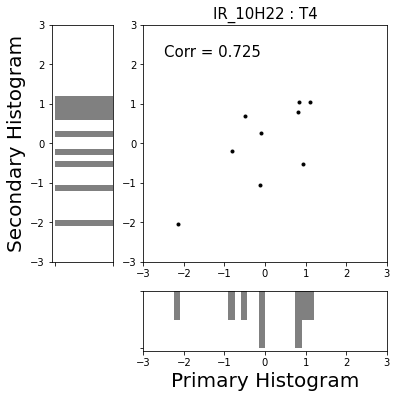

In [44]:
requested_filename = requested_IR[0]


# Set up the axes with gridspec
corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
vlim = (-3, 3)
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)m
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(Primary["Primary"], Primary["Secondary"], "ok", markersize=3)
main_ax.set_xlim(vlim)
main_ax.set_ylim(vlim)
main_ax.set_title(requested_filename +' : '+ TEMP , size=15)
main_ax.text(-2.5, 2.2,
    "Corr = {0:.3f}".format(
        np.corrcoef(Primary["Primary"], Primary["Secondary"])[0, 1]
    ),
    size=15
)

# histogram on the attached axes
x_hist.hist(
    Primary["Primary"],
    40,
    histtype="stepfilled",
    label="Primary",
    orientation="vertical",
    color="gray",
    range=vlim,
)
x_hist.set_xlabel("Primary Histogram", size=20)
x_hist.invert_yaxis()


y_hist.hist(
    Primary["Secondary"],
    40,
    histtype="stepfilled",
    orientation="horizontal",
    color="gray",
    range=vlim,
)
y_hist.set_ylabel("Secondary Histogram", size=20)
y_hist.invert_xaxis()

SAVE = False
if SAVE : 
    filepath = "C:/Users/Alexandre/Desktop/Cours/Stage/CoCalc/DTP/linear_all_IR/distr/" + requested_filename +'_'+TEMP+'.png'
    plt.savefig(filepath, bbox_inches="tight")